<a href="https://colab.research.google.com/github/SiddharthVijayVargiya/Grammerly_with_python/blob/main/Copy_of_apple(sev)_Price_predicator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

Grubbs's Test:
Grubbs's Statistic: 2.5008405585693048, Critical Value: 3.463693524782415, Outlier Detected: False


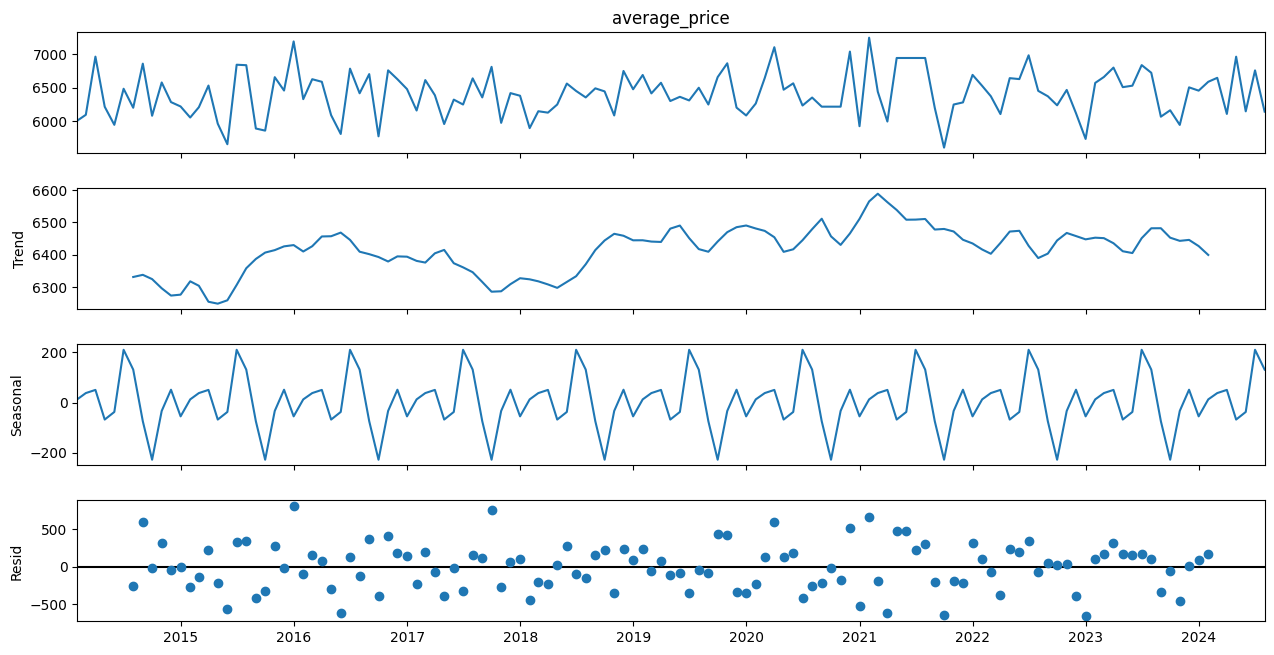

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats
import numpy as np

# Load the dataset
file = '/content/apple_cleaned.csv'
data = pd.read_csv(file)

# Convert the 'date' column to datetime format
data['date'] = pd.to_datetime(data['date'])

# Extract year and month from the 'date' column
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month

# Calculate the average price for each day by taking the mean of 'Min Price' and 'Max Price'
data['average_price'] = data[['Min Price (Rs./Quintal)', 'Max Price (Rs./Quintal)']].mean(axis=1)

# Set the 'date' column as the index for the time series
data.set_index('date', inplace=True)

# Resample the data to get monthly average prices
monthly_resampled = data['average_price'].resample('M').mean()

# Fill missing values using forward fill (to handle missing months)
monthly_resampled = monthly_resampled.ffill()  # Fixed the deprecated method

# Perform Grubbs's test for outliers
def grubbs_test(data):
    N = len(data)
    mean_data = np.mean(data)
    std_data = np.std(data)
    G = max(abs(data - mean_data)) / std_data  # Grubbs's statistic

    # Critical value
    t_dist = stats.t.ppf(1 - 0.05 / (2 * N), N - 2)
    critical_value = ((N - 1) / np.sqrt(N)) * np.sqrt(t_dist**2 / (N - 2 + t_dist**2))

    return G, critical_value, G > critical_value

# Grubbs's test result
grubbs_stat, critical_val, is_outlier = grubbs_test(monthly_resampled.values)
print(f"Grubbs's Test:\nGrubbs's Statistic: {grubbs_stat}, Critical Value: {critical_val}, Outlier Detected: {is_outlier}")

# Plot the original time series and decomposition
decomposition = seasonal_decompose(monthly_resampled, model='additive')

# Plot the decomposition result (trend, seasonality, residuals)
fig = decomposition.plot()
fig.set_size_inches(14, 7)
plt.show()


In [ ]:
def generalized_esd_test(data, max_outliers=None, alpha=0.05):
    """
    Perform the Generalized ESD test for multiple outliers.

    Parameters:
    - data: array-like, input data.
    - max_outliers: int, maximum number of outliers to test for. Defaults to 10% of data length.
    - alpha: significance level.

    Returns:
    - outliers: list of detected outliers.
    """
    data = np.array(data)
    n = len(data)
    if max_outliers is None:
        max_outliers = int(np.floor(0.1 * n))  # Default to 10% of data

    outliers = []
    for i in range(1, max_outliers + 1):
        mean = np.mean(data)
        std = np.std(data, ddof=1)
        if std == 0:
            break
        # Calculate the absolute deviation from the mean
        abs_deviation = np.abs(data - mean)
        # Find the maximum deviation
        R = np.max(abs_deviation) / std
        # Compute the critical value
        p = 1 - alpha / (2 * (n - i + 1))
        t = stats.t.ppf(p, n - i - 1)
        lam = ((n - i) * t) / (np.sqrt((n - i - 1 + t**2) * (n - i + 1)))
        if R > lam:
            # Identify the outlier
            outlier_index = np.argmax(abs_deviation)
            outlier = data[outlier_index]
            outliers.append(outlier)
            # Remove the outlier for the next iteration
            data = np.delete(data, outlier_index)
        else:
            break
    return outliers


Grubbs's Test:
Grubbs's Statistic: 2.5008, Critical Value: 3.4637, Outlier Detected: False
Generalized ESD Test:
Detected Outliers: []


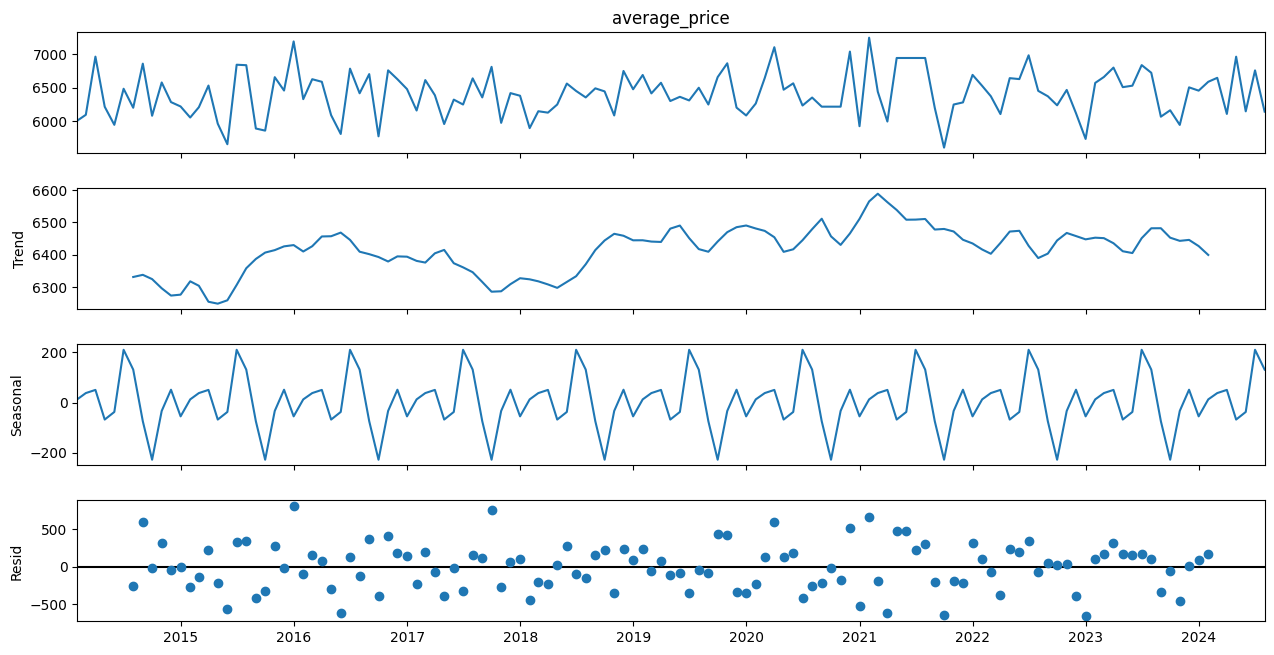

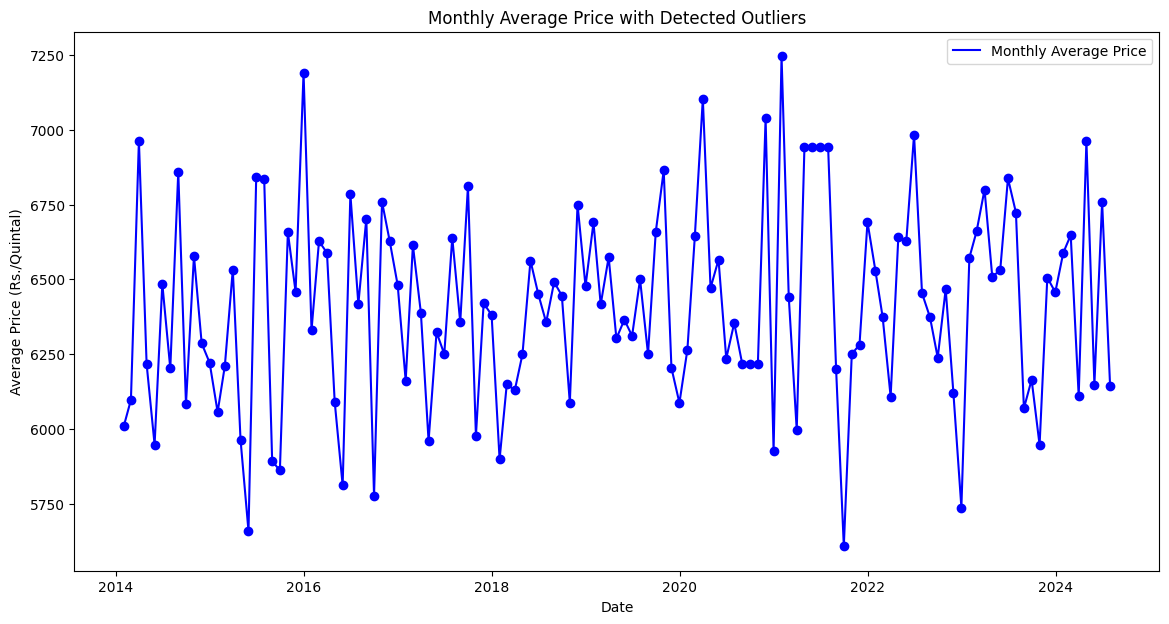

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats
import numpy as np

# Load the dataset
file = '/content/apple_cleaned.csv'
data = pd.read_csv(file)

# Convert the 'date' column to datetime format
data['date'] = pd.to_datetime(data['date'])

# Extract year and month from the 'date' column
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month

# Calculate the average price for each day by taking the mean of 'Min Price' and 'Max Price'
data['average_price'] = data[['Min Price (Rs./Quintal)', 'Max Price (Rs./Quintal)']].mean(axis=1)

# Set the 'date' column as the index for the time series
data.set_index('date', inplace=True)

# Resample the data to get monthly average prices
monthly_resampled = data['average_price'].resample('M').mean()

# Fill missing values using forward fill (to handle missing months)
monthly_resampled = monthly_resampled.ffill()  # Updated to avoid FutureWarning

# Perform Grubbs's test for outliers
grubbs_stat, critical_val, is_outlier = grubbs_test(monthly_resampled.values)
print(f"Grubbs's Test:\nGrubbs's Statistic: {grubbs_stat:.4f}, Critical Value: {critical_val:.4f}, Outlier Detected: {is_outlier}")

# Perform Generalized ESD test for outliers
esd_outliers = generalized_esd_test(monthly_resampled.values)
print(f"Generalized ESD Test:\nDetected Outliers: {esd_outliers}")

# Perform seasonal decomposition
decomposition = seasonal_decompose(monthly_resampled, model='additive')

# Plot the decomposition result (trend, seasonality, residuals)
fig = decomposition.plot()
fig.set_size_inches(14, 7)
plt.show()

# Visualize detected outliers on the time series
plt.figure(figsize=(14, 7))
plt.plot(monthly_resampled, label='Monthly Average Price', color='blue')
plt.scatter(monthly_resampled.index, monthly_resampled.values, color='blue')

# Highlight Grubbs's outlier if detected
if is_outlier:
    # Identify the Grubbs's outlier
    mean = np.mean(monthly_resampled.values)
    std = np.std(monthly_resampled.values, ddof=1)
    outlier_value = mean + np.sign(monthly_resampled.max() - mean) * (grubbs_stat * std)
    outlier_date = monthly_resampled.idxmax()
    plt.scatter(outlier_date, monthly_resampled.max(), color='red', label='Grubbs Outlier', zorder=5)

# Highlight Generalized ESD outliers
for outlier in esd_outliers:
    outlier_date = monthly_resampled[monthly_resampled == outlier].index
    plt.scatter(outlier_date, outlier, color='orange', label='ESD Outlier', zorder=5)

# To avoid duplicate labels in the legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.title('Monthly Average Price with Detected Outliers')
plt.xlabel('Date')
plt.ylabel('Average Price (Rs./Quintal)')
plt.show()


In [ ]:
!pip install prophet


In [ ]:
from prophet import Prophet

import pandas as pd
import matplotlib.pyplot as plt

# Load the data
file = '/content/apple_cleaned.csv'
data = pd.read_csv(file)

# Prepare the data for Prophet
# Prophet expects the data to have two columns: 'ds' (date) and 'y' (value to forecast)
data['date'] = pd.to_datetime(data['date'])
data['average_price'] = data[['Min Price (Rs./Quintal)', 'Max Price (Rs./Quintal)']].mean(axis=1)
data_prophet = data[['date', 'average_price']].rename(columns={'date': 'ds', 'average_price': 'y'})

# Initialize and fit the Prophet model
model = Prophet()
model.fit(data_prophet)

# Make a future dataframe for the next 365 days
future = model.make_future_dataframe(periods=365)

# Predict future values
forecast = model.predict(future)

# Plot the forecast
model.plot(forecast)
plt.show()

# Plot the components (trend, weekly seasonality, yearly seasonality)
model.plot_components(forecast)
plt.show()


ValueError: Found NaN in column ds.

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpls1h8s69/9qdr0f3a.json


2


DEBUG:cmdstanpy:input tempfile: /tmp/tmpls1h8s69/hrzyg_2i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=916', 'data', 'file=/tmp/tmpls1h8s69/9qdr0f3a.json', 'init=/tmp/tmpls1h8s69/hrzyg_2i.json', 'output', 'file=/tmp/tmpls1h8s69/prophet_model6rd716b1/prophet_model-20240927092000.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:20:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:20:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst

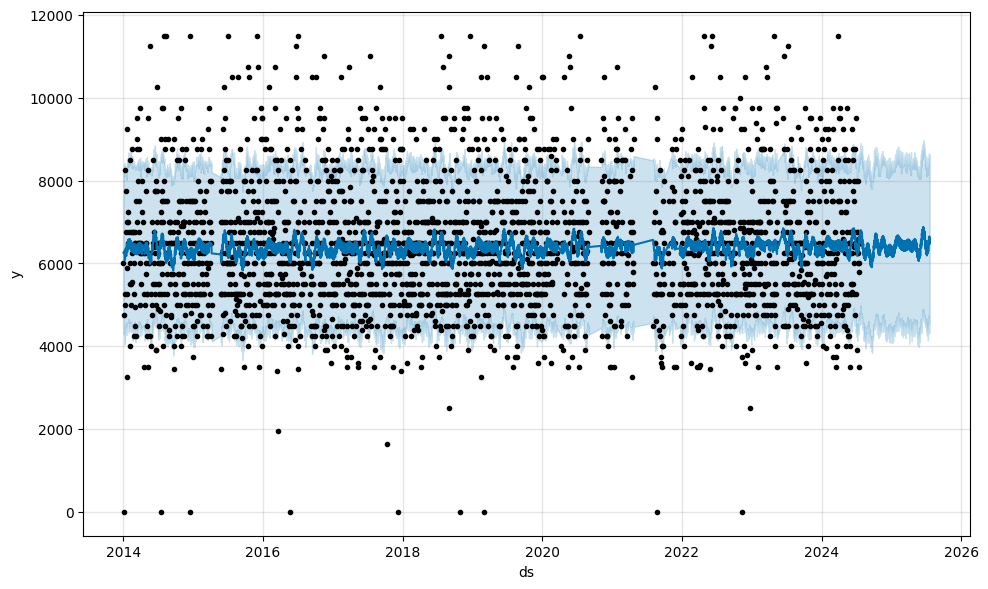

/usr/local/lib/python3.10/dist-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` o

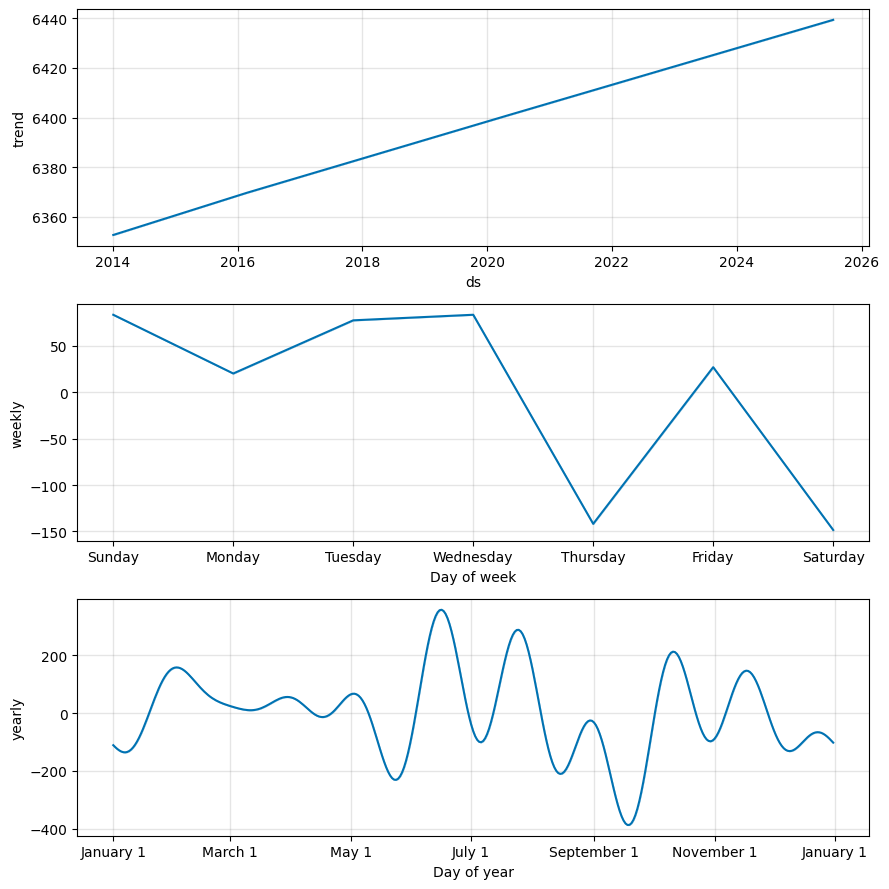

In [ ]:
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
file = '/content/apple_cleaned.csv'
data = pd.read_csv(file)

# Check for missing values in the 'date' column
print(data['date'].isnull().sum())

# Remove rows with NaN in the 'date' column
data = data.dropna(subset=['date'])

# Prepare the data for Prophet
data['date'] = pd.to_datetime(data['date'])
data['average_price'] = data[['Min Price (Rs./Quintal)', 'Max Price (Rs./Quintal)']].mean(axis=1)
data_prophet = data[['date', 'average_price']].rename(columns={'date': 'ds', 'average_price': 'y'})

# Initialize and fit the Prophet model
model = Prophet()
model.fit(data_prophet)

# Make a future dataframe for the next 365 days
future = model.make_future_dataframe(periods=365)

# Predict future values
forecast = model.predict(future)

# Plot the forecast
model.plot(forecast)
plt.show()

# Plot the components (trend, weekly seasonality, yearly seasonality)
model.plot_components(forecast)
plt.show()


DEBUG:cmdstanpy:input tempfile: /tmp/tmpls1h8s69/dc2bc3xn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpls1h8s69/67xq03yr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14165', 'data', 'file=/tmp/tmpls1h8s69/dc2bc3xn.json', 'init=/tmp/tmpls1h8s69/67xq03yr.json', 'output', 'file=/tmp/tmpls1h8s69/prophet_modelkm91hll6/prophet_model-20240927092448.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:24:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:24:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray.

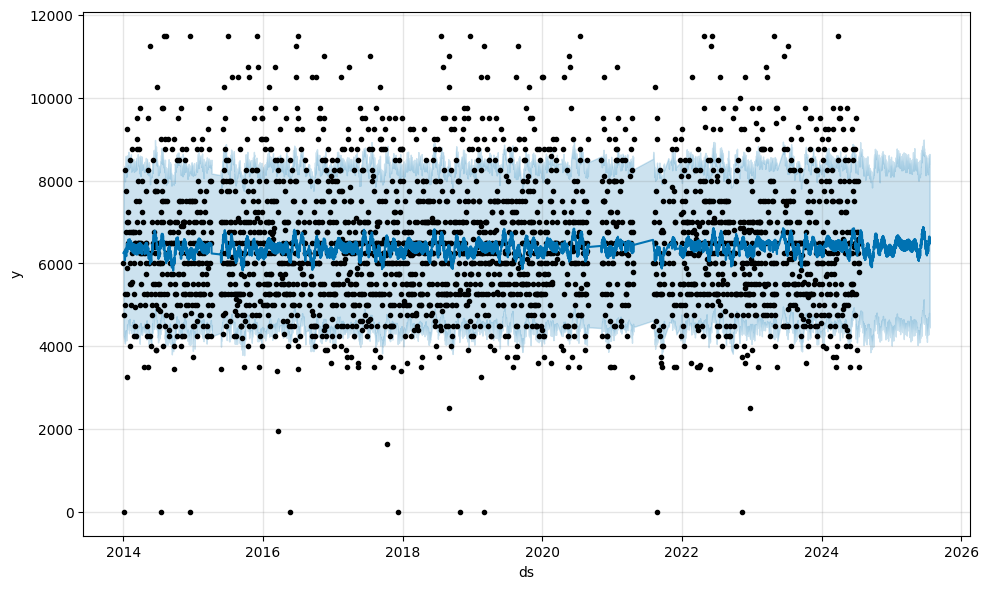

/usr/local/lib/python3.10/dist-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` o

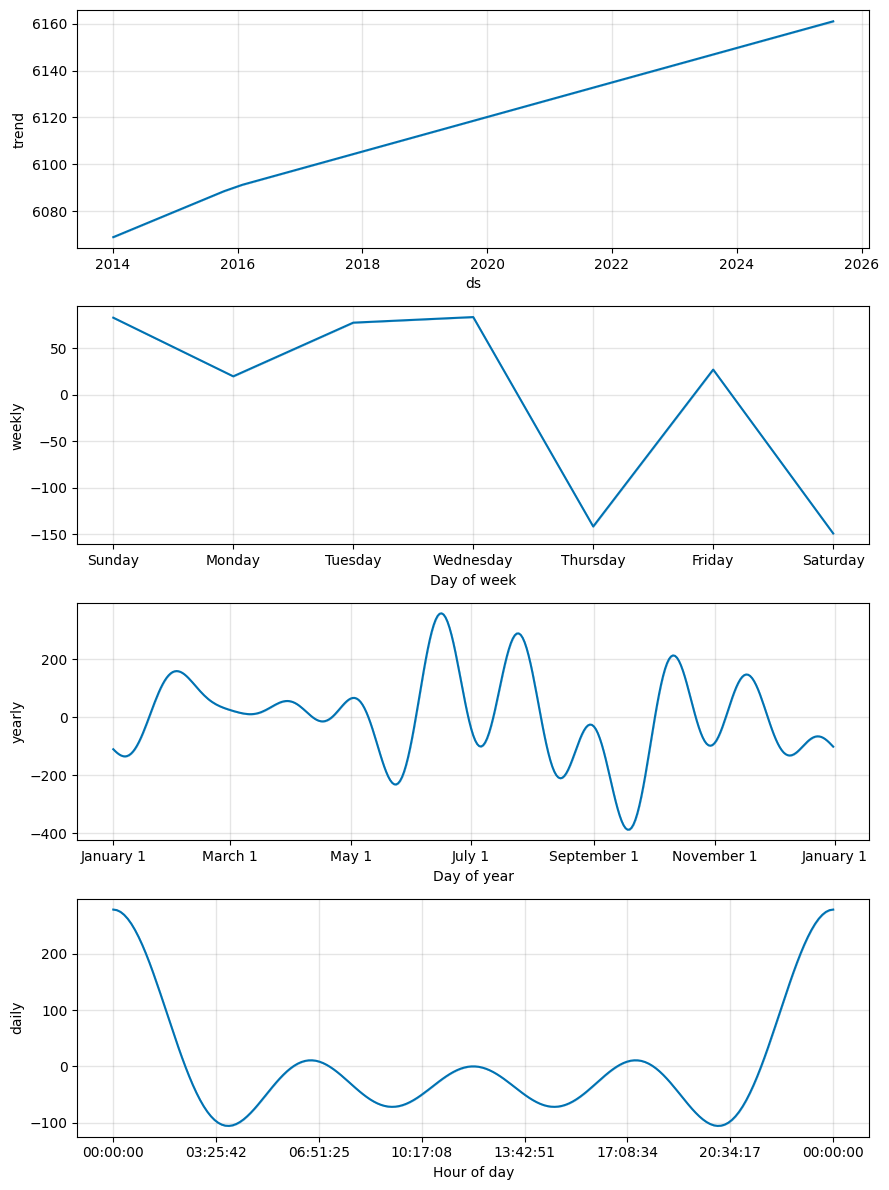

        Date  Predicted Price  Lower Bound  Upper Bound
0 2014-01-03      6252.244012  4265.977800  8206.916184
1 2014-01-07      6289.398831  4138.728900  8160.432145
2 2014-01-08      6296.144022  4229.899710  8352.144432
3 2014-01-09      6074.025322  4100.957772  8085.431894
4 2014-01-11      6078.061605  4064.012149  7981.055393


In [ ]:
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
file = '/content/apple_cleaned.csv'
data = pd.read_csv(file)

# Remove rows with NaN in the 'date' column
data = data.dropna(subset=['date'])

# Prepare the data for Prophet
data['date'] = pd.to_datetime(data['date'])
data['average_price'] = data[['Min Price (Rs./Quintal)', 'Max Price (Rs./Quintal)']].mean(axis=1)
data_prophet = data[['date', 'average_price']].rename(columns={'date': 'ds', 'average_price': 'y'})

# Initialize and fit the Prophet model with daily seasonality enabled
model = Prophet(daily_seasonality=True)
model.fit(data_prophet)

# Make a future dataframe for the next 365 days
future = model.make_future_dataframe(periods=365)

# Predict future values
forecast = model.predict(future)

# Plot the forecast
model.plot(forecast)
plt.show()

# Plot the components (trend, weekly seasonality, yearly seasonality)
model.plot_components(forecast)
plt.show()

# Extract the relevant columns for predicted prices
predicted_prices = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

# Rename columns for clarity
predicted_prices.columns = ['Date', 'Predicted Price', 'Lower Bound', 'Upper Bound']

# Display the predicted prices table
print(predicted_prices.head())  # Display the first few rows


In [ ]:
# Make a future dataframe for the next 365 days starting from today
future = model.make_future_dataframe(periods=365, freq='D')

# Filter out only the predictions from October 2024 onwards
future_predictions = forecast[forecast['ds'] >= '2024-10-01']

# Prepare a DataFrame for better readability
predicted_prices = future_predictions[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
predicted_prices.rename(columns={'ds': 'Date', 'yhat': 'Predicted Price', 'yhat_lower': 'Lower Bound', 'yhat_upper': 'Upper Bound'}, inplace=True)

# Display the predicted prices
print(predicted_prices)


           Date  Predicted Price  Lower Bound  Upper Bound
2834 2024-10-01      6486.032968  4436.081745  8569.139166
2835 2024-10-02      6532.404448  4632.376021  8626.065179
2836 2024-10-03      6345.847292  4376.875944  8302.617375
2837 2024-10-04      6549.668373  4570.354817  8609.757485
2838 2024-10-05      6405.652811  4425.956293  8335.945031
...         ...              ...          ...          ...
3121 2025-07-15      6604.578782  4695.831042  8625.884076
3122 2025-07-16      6642.943579  4803.142443  8595.524480
3123 2025-07-17      6449.782851  4446.962752  8401.664318
3124 2025-07-18      6648.284185  4480.840031  8642.843316
3125 2025-07-19      6500.079072  4463.179202  8431.726859

[292 rows x 4 columns]


<ipython-input-24-42a98c08dbfd>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predicted_prices.rename(columns={'ds': 'Date', 'yhat': 'Predicted Price', 'yhat_lower': 'Lower Bound', 'yhat_upper': 'Upper Bound'}, inplace=True)


DEBUG:cmdstanpy:input tempfile: /tmp/tmpls1h8s69/h3y3b9au.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpls1h8s69/j2v3gcxr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47080', 'data', 'file=/tmp/tmpls1h8s69/h3y3b9au.json', 'init=/tmp/tmpls1h8s69/j2v3gcxr.json', 'output', 'file=/tmp/tmpls1h8s69/prophet_modelh02ox6cg/prophet_model-20240927093353.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:33:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:33:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 16 forecasts with cutoffs between 2016-02-27 00:00:00 and 2023-07-20 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7eada35de4d0>
DEBUG:cmdstanpy:input tempfile:

  horizon           mse         rmse          mae     mdape     smape  \
0 35 days  2.539166e+06  1593.475962  1162.391490  0.145936  0.185386   
1 36 days  2.552090e+06  1597.526138  1172.194028  0.147623  0.187282   
2 37 days  2.542923e+06  1594.654647  1168.702133  0.146848  0.186517   
3 38 days  2.560748e+06  1600.233875  1179.021724  0.147623  0.187684   
4 39 days  2.533587e+06  1591.724414  1172.131074  0.148167  0.186220   

   coverage  
0  0.823703  
1  0.818399  
2  0.816507  
3  0.820942  
4  0.824807  


/usr/local/lib/python3.10/dist-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


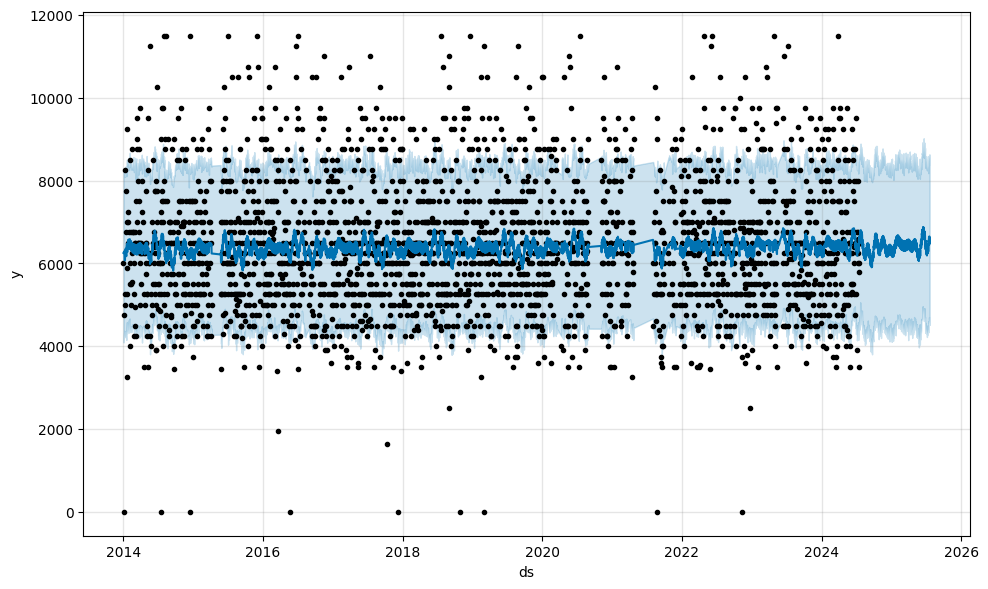

/usr/local/lib/python3.10/dist-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` o

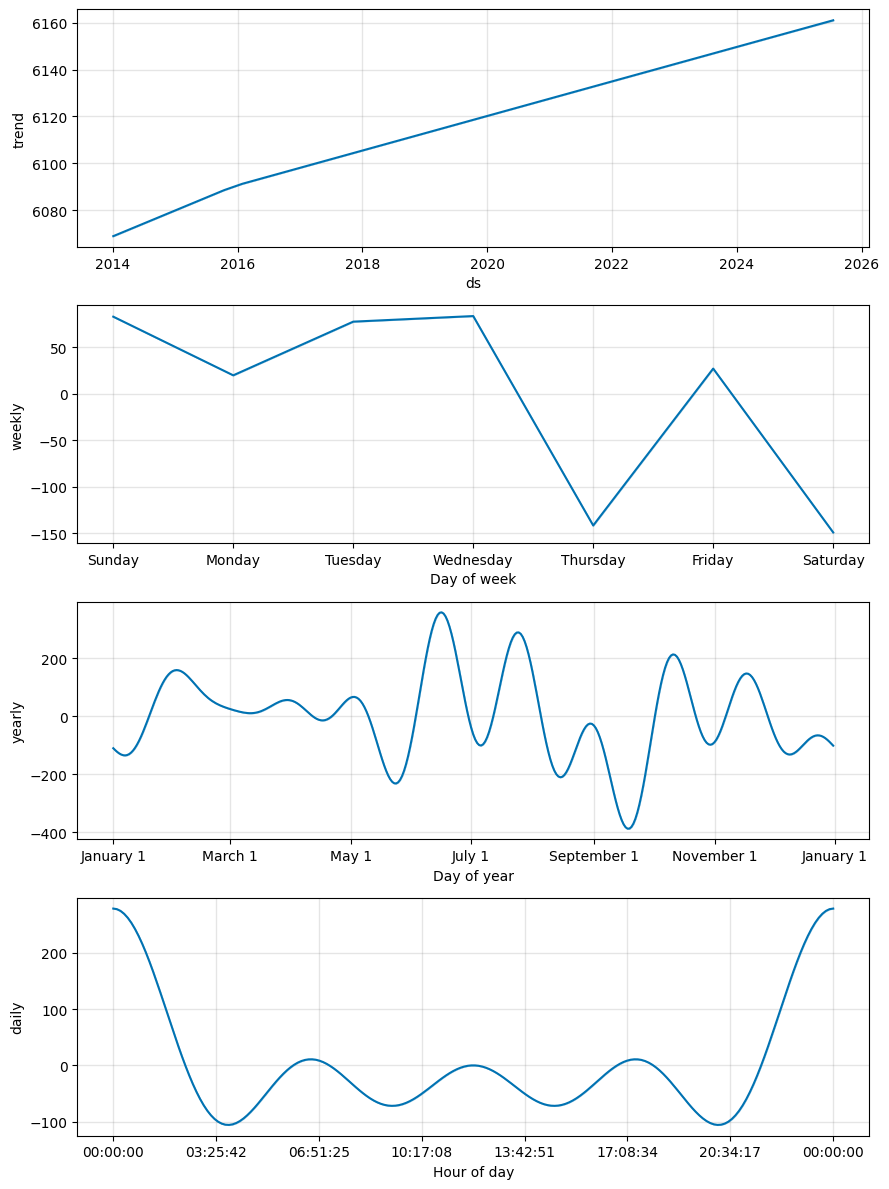

        Date  Predicted Price  Lower Bound  Upper Bound
0 2014-01-03      6252.244012  4090.873116  8277.100965
1 2014-01-07      6289.398831  4371.502011  8244.537756
2 2014-01-08      6296.144022  4262.568496  8270.274661
3 2014-01-09      6074.025322  4215.739445  8088.592378
4 2014-01-11      6078.061605  4246.065216  8093.457118


In [ ]:
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
file = '/content/apple_cleaned.csv'
data = pd.read_csv(file)

# Remove rows with NaN in the 'date' column
data = data.dropna(subset=['date'])

# Prepare the data for Prophet
data['date'] = pd.to_datetime(data['date'])
data['average_price'] = data[['Min Price (Rs./Quintal)', 'Max Price (Rs./Quintal)']].mean(axis=1)
data_prophet = data[['date', 'average_price']].rename(columns={'date': 'ds', 'average_price': 'y'})

# Initialize and fit the Prophet model with daily seasonality enabled
model = Prophet(daily_seasonality=True)
model.fit(data_prophet)

# Perform cross-validation
# You can set the initial period and the horizon as per your requirements
df_cv = cross_validation(model, initial='730 days', period='180 days', horizon='365 days', parallel='processes')

# Calculate performance metrics
df_p = performance_metrics(df_cv)

# Display the performance metrics
print(df_p.head())  # Display the first few rows of performance metrics

# Make a future dataframe for the next 365 days
future = model.make_future_dataframe(periods=365)

# Predict future values
forecast = model.predict(future)

# Plot the forecast
model.plot(forecast)
plt.show()

# Plot the components (trend, weekly seasonality, yearly seasonality)
model.plot_components(forecast)
plt.show()

# Extract the relevant columns for predicted prices
predicted_prices = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

# Rename columns for clarity
predicted_prices.columns = ['Date', 'Predicted Price', 'Lower Bound', 'Upper Bound']

# Display the predicted prices table
print(predicted_prices.head())  # Display the first few rows


DEBUG:cmdstanpy:input tempfile: /tmp/tmpls1h8s69/nnkt_4fh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpls1h8s69/dud62r9i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63116', 'data', 'file=/tmp/tmpls1h8s69/nnkt_4fh.json', 'init=/tmp/tmpls1h8s69/dud62r9i.json', 'output', 'file=/tmp/tmpls1h8s69/prophet_modelne9r9hxe/prophet_model-20240927093418.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:34:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:34:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 16 forecasts with cutoffs between 2016-02-27 00:00:00 and 2023-07-20 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7eada31c03a0>
DEBUG:cmdstanpy:input tempfile:

  horizon           mse         rmse          mae     mdape     smape  \
0 35 days  2.539166e+06  1593.475962  1162.391490  0.145936  0.185386   
1 36 days  2.552090e+06  1597.526138  1172.194028  0.147623  0.187282   
2 37 days  2.542923e+06  1594.654647  1168.702133  0.146848  0.186517   
3 38 days  2.560748e+06  1600.233875  1179.021724  0.147623  0.187684   
4 39 days  2.533587e+06  1591.724414  1172.131074  0.148167  0.186220   

   coverage  
0  0.809349  
1  0.804045  
2  0.802153  
3  0.806588  
4  0.810453  


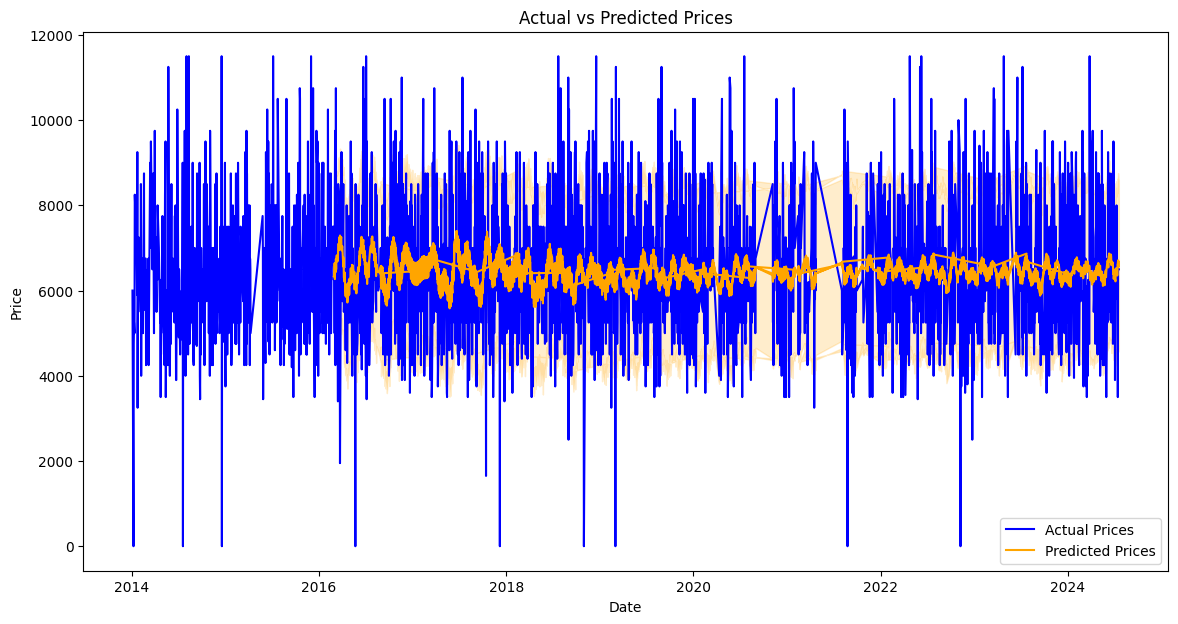

/usr/local/lib/python3.10/dist-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


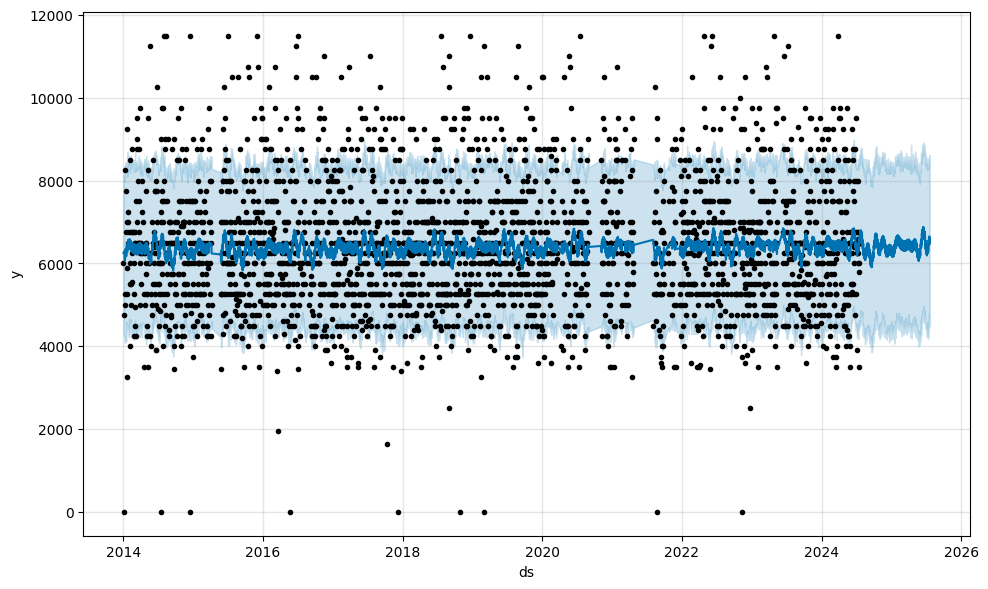

/usr/local/lib/python3.10/dist-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` o

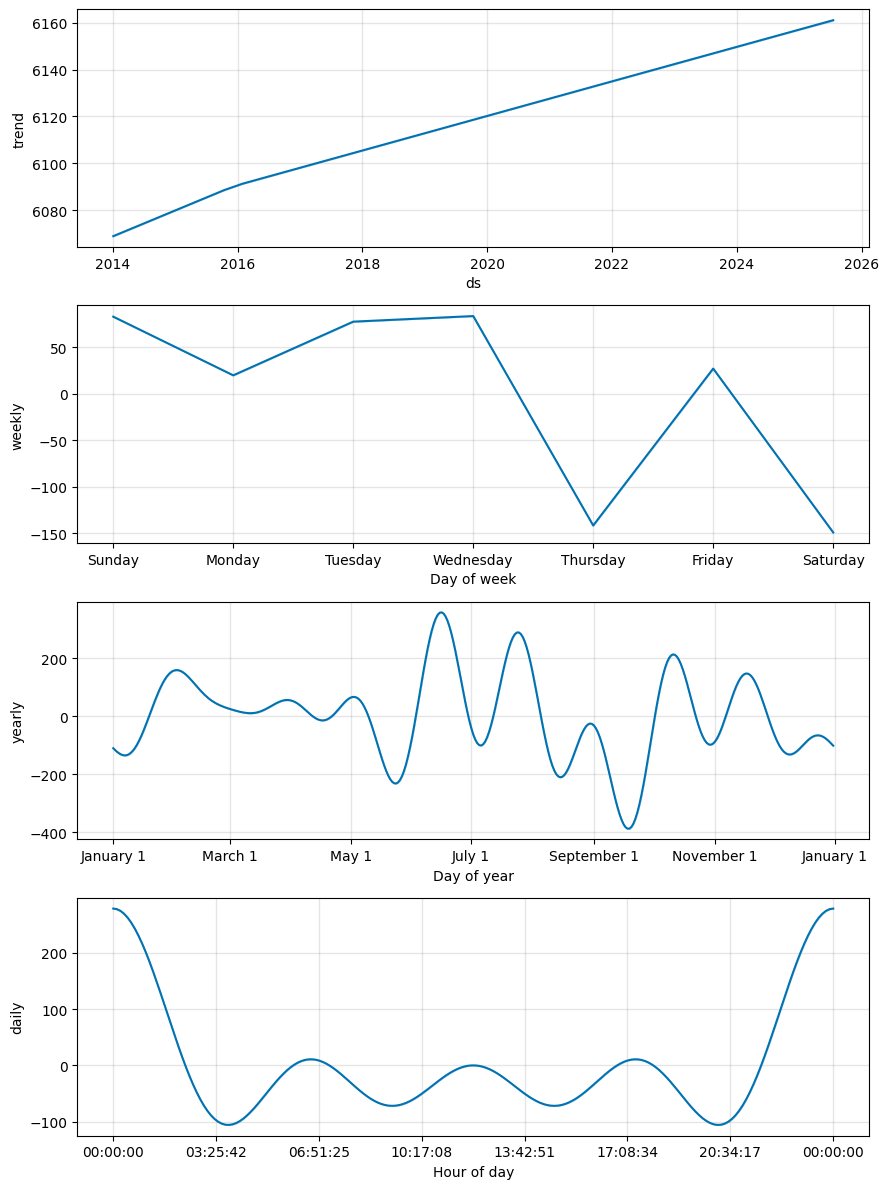

        Date  Predicted Price  Lower Bound  Upper Bound
0 2014-01-03      6252.244012  4276.208987  8140.463934
1 2014-01-07      6289.398831  4243.472185  8163.815845
2 2014-01-08      6296.144022  4220.717106  8351.043554
3 2014-01-09      6074.025322  4086.391839  7967.402601
4 2014-01-11      6078.061605  4088.219025  8027.268822


In [ ]:
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
file = '/content/apple_cleaned.csv'
data = pd.read_csv(file)

# Remove rows with NaN in the 'date' column
data = data.dropna(subset=['date'])

# Prepare the data for Prophet
data['date'] = pd.to_datetime(data['date'])
data['average_price'] = data[['Min Price (Rs./Quintal)', 'Max Price (Rs./Quintal)']].mean(axis=1)
data_prophet = data[['date', 'average_price']].rename(columns={'date': 'ds', 'average_price': 'y'})

# Initialize and fit the Prophet model with daily seasonality enabled
model = Prophet(daily_seasonality=True)
model.fit(data_prophet)

# Perform cross-validation
df_cv = cross_validation(model, initial='730 days', period='180 days', horizon='365 days', parallel='processes')

# Calculate performance metrics
df_p = performance_metrics(df_cv)

# Display the performance metrics
print(df_p.head())  # Display the first few rows of performance metrics

# Plot the actual vs predicted
plt.figure(figsize=(14, 7))
plt.plot(data_prophet['ds'], data_prophet['y'], label='Actual Prices', color='blue')
plt.plot(df_cv['ds'], df_cv['yhat'], label='Predicted Prices', color='orange')
plt.fill_between(df_cv['ds'], df_cv['yhat_lower'], df_cv['yhat_upper'], color='orange', alpha=0.2)
plt.title('Actual vs Predicted Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Make a future dataframe for the next 365 days
future = model.make_future_dataframe(periods=365)

# Predict future values
forecast = model.predict(future)

# Plot the forecast
model.plot(forecast)
plt.show()

# Plot the components (trend, weekly seasonality, yearly seasonality)
model.plot_components(forecast)
plt.show()

# Extract the relevant columns for predicted prices
predicted_prices = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

# Rename columns for clarity
predicted_prices.columns = ['Date', 'Predicted Price', 'Lower Bound', 'Upper Bound']

# Display the predicted prices table
print(predicted_prices.head())  # Display the first few rows


<ipython-input-2-e8b52f850f1e>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['date'] = pd.to_datetime(data['date'])
<ipython-input-2-e8b52f850f1e>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['average_price'] = data[['Min Price (Rs./Quintal)', 'Max Price (Rs./Quintal)']].mean(axis=1)
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/k9dnol6j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/pi8nnf2n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmd

  horizon           mse         rmse          mae      mape     mdape  \
0 35 days  2.380509e+06  1542.889682  1141.973592  0.188534  0.141073   
1 36 days  2.401400e+06  1549.645150  1155.161438  0.191540  0.145918   
2 37 days  2.387524e+06  1545.161622  1149.941301  0.190047  0.141774   
3 38 days  2.410671e+06  1552.633430  1161.341548  0.190982  0.148100   
4 39 days  2.383133e+06  1543.739911  1154.569153  0.188769  0.148100   

      smape  coverage  
0  0.177325  0.803726  
1  0.179812  0.800959  
2  0.178764  0.799041  
3  0.180148  0.795979  
4  0.178674  0.800775  


DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/x_q1gojn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89055', 'data', 'file=/tmp/tmpbzbtl85n/05s22v66.json', 'init=/tmp/tmpbzbtl85n/x_q1gojn.json', 'output', 'file=/tmp/tmpbzbtl85n/prophet_modelqfh3xfg3/prophet_model-20240927204417.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:44:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:44:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 16 forecasts with cutoffs between 2016-02-27 00:00:00 and 2023-07-20 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7d9db0ddf970>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/nawr2v6x.json
DEBUG:cmdstanpy:input tempfile:

  horizon           mse         rmse          mae      mape     mdape  \
0 35 days  2.376448e+06  1541.573187  1140.233633  0.188310  0.141392   
1 36 days  2.397113e+06  1548.261246  1153.472829  0.191325  0.146179   
2 37 days  2.383915e+06  1543.993237  1148.589045  0.189892  0.145156   
3 38 days  2.406365e+06  1551.246380  1159.900386  0.190815  0.146808   
4 39 days  2.378706e+06  1542.305449  1153.257477  0.188617  0.146808   

      smape  coverage  
0  0.177048  0.806124  
1  0.179545  0.803357  
2  0.178551  0.801439  
3  0.179922  0.798377  
4  0.178467  0.803173  


DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/ke2b5r4g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1893', 'data', 'file=/tmp/tmpbzbtl85n/zxn02gr4.json', 'init=/tmp/tmpbzbtl85n/ke2b5r4g.json', 'output', 'file=/tmp/tmpbzbtl85n/prophet_modelbd8kavxe/prophet_model-20240927204433.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:44:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:44:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 16 forecasts with cutoffs between 2016-02-27 00:00:00 and 2023-07-20 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7d9db09a7fd0>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/_ai4kt9u.json
DEBUG:cmdstanpy:input tempfile: 

  horizon           mse         rmse          mae      mape     mdape  \
0 35 days  2.380369e+06  1542.844417  1142.599546  0.188693  0.142842   
1 36 days  2.401568e+06  1549.699177  1155.916946  0.191721  0.145692   
2 37 days  2.388446e+06  1545.459677  1150.932756  0.190270  0.143079   
3 38 days  2.411508e+06  1552.902998  1162.325835  0.191197  0.148388   
4 39 days  2.383579e+06  1543.884520  1155.411732  0.188960  0.148388   

      smape  coverage  
0  0.177415  0.811105  
1  0.179924  0.808153  
2  0.178912  0.806235  
3  0.180295  0.807969  
4  0.178800  0.812765  


DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/qev31q6j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51816', 'data', 'file=/tmp/tmpbzbtl85n/bch40ztq.json', 'init=/tmp/tmpbzbtl85n/qev31q6j.json', 'output', 'file=/tmp/tmpbzbtl85n/prophet_modelun9zvb0e/prophet_model-20240927204448.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:44:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:44:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 16 forecasts with cutoffs between 2016-02-27 00:00:00 and 2023-07-20 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7d9db0ddf970>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/9pnahps9.json
DEBUG:cmdstanpy:input tempfile:

  horizon           mse         rmse          mae      mape     mdape  \
0 35 days  2.380387e+06  1542.850136  1142.323464  0.188548  0.140158   
1 36 days  2.401630e+06  1549.719329  1155.499925  0.191558  0.146946   
2 37 days  2.388361e+06  1545.432181  1150.337843  0.190072  0.141020   
3 38 days  2.411885e+06  1553.024480  1161.795956  0.191012  0.148615   
4 39 days  2.384144e+06  1544.067261  1154.939692  0.188782  0.148615   

      smape  coverage  
0  0.177380  0.808522  
1  0.179866  0.803357  
2  0.178824  0.801439  
3  0.180217  0.798377  
4  0.178732  0.803173  


DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/cl56bf5b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91871', 'data', 'file=/tmp/tmpbzbtl85n/gqe40jhi.json', 'init=/tmp/tmpbzbtl85n/cl56bf5b.json', 'output', 'file=/tmp/tmpbzbtl85n/prophet_modell2oi7yft/prophet_model-20240927204459.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:44:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:44:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 16 forecasts with cutoffs between 2016-02-27 00:00:00 and 2023-07-20 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7d9db0df40d0>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/1yw5bn17.json
DEBUG:cmdstanpy:input tempfile:

  horizon           mse         rmse          mae      mape     mdape  \
0 35 days  2.375674e+06  1541.322236  1140.398667  0.188367  0.141362   
1 36 days  2.396493e+06  1548.061193  1153.605161  0.191377  0.145656   
2 37 days  2.383546e+06  1543.873769  1148.811011  0.189959  0.144239   
3 38 days  2.406108e+06  1551.163491  1160.134273  0.190881  0.146737   
4 39 days  2.378404e+06  1542.207391  1153.447067  0.188676  0.146737   

      smape  coverage  
0  0.177075  0.811105  
1  0.179567  0.808153  
2  0.178585  0.806235  
3  0.179958  0.807969  
4  0.178496  0.812765  


DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/g06zgwyc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45736', 'data', 'file=/tmp/tmpbzbtl85n/jzs2qqla.json', 'init=/tmp/tmpbzbtl85n/g06zgwyc.json', 'output', 'file=/tmp/tmpbzbtl85n/prophet_modelz9h4v5ep/prophet_model-20240927204511.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:45:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:45:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 16 forecasts with cutoffs between 2016-02-27 00:00:00 and 2023-07-20 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7d9db0ddffd0>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/2wc7l8rq.json
DEBUG:cmdstanpy:input tempfile:

  horizon           mse         rmse          mae      mape     mdape  \
0 35 days  2.379676e+06  1542.619694  1141.489817  0.188395  0.142022   
1 36 days  2.400336e+06  1549.301891  1154.717755  0.191408  0.145692   
2 37 days  2.387123e+06  1545.031706  1149.729695  0.189962  0.142948   
3 38 days  2.409840e+06  1552.365827  1161.038085  0.190881  0.149084   
4 39 days  2.382000e+06  1543.373089  1154.220837  0.188659  0.149084   

      smape  coverage  
0  0.177240  0.813319  
1  0.179736  0.810552  
2  0.178726  0.811031  
3  0.180098  0.812765  
4  0.178616  0.817561  


DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/hvxxj5pn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68736', 'data', 'file=/tmp/tmpbzbtl85n/kbyfscon.json', 'init=/tmp/tmpbzbtl85n/hvxxj5pn.json', 'output', 'file=/tmp/tmpbzbtl85n/prophet_modelsc57rwtc/prophet_model-20240927204521.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:45:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:45:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 16 forecasts with cutoffs between 2016-02-27 00:00:00 and 2023-07-20 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7d9dffd98b50>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/_hh6hizp.json
DEBUG:cmdstanpy:input tempfile:

  horizon           mse         rmse          mae      mape     mdape  \
0 35 days  2.380270e+06  1542.812385  1141.764217  0.188299  0.141712   
1 36 days  2.401784e+06  1549.769125  1154.702142  0.191271  0.144608   
2 37 days  2.388968e+06  1545.628573  1149.841451  0.189836  0.141917   
3 38 days  2.413040e+06  1553.396308  1161.404008  0.190795  0.145918   
4 39 days  2.384734e+06  1544.258425  1154.412772  0.188546  0.145918   

      smape  coverage  
0  0.177298  0.811105  
1  0.179748  0.808153  
2  0.178752  0.806235  
3  0.180160  0.807969  
4  0.178655  0.812765  


DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/repk9jkf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44714', 'data', 'file=/tmp/tmpbzbtl85n/_8gikr2m.json', 'init=/tmp/tmpbzbtl85n/repk9jkf.json', 'output', 'file=/tmp/tmpbzbtl85n/prophet_modelkgmli5h5/prophet_model-20240927204532.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:45:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:45:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 16 forecasts with cutoffs between 2016-02-27 00:00:00 and 2023-07-20 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7d9db153fbb0>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/relnb9sj.json
DEBUG:cmdstanpy:input tempfile:

  horizon           mse         rmse          mae      mape     mdape  \
0 35 days  2.376769e+06  1541.677443  1140.653121  0.188310  0.142100   
1 36 days  2.397485e+06  1548.381475  1153.831585  0.191313  0.145656   
2 37 days  2.385212e+06  1544.413136  1149.180749  0.189914  0.144232   
3 38 days  2.408588e+06  1551.962624  1160.708986  0.190861  0.149269   
4 39 days  2.380576e+06  1542.911581  1153.906961  0.188635  0.149269   

      smape  coverage  
0  0.177118  0.813319  
1  0.179606  0.808153  
2  0.178644  0.808633  
3  0.180048  0.810367  
4  0.178569  0.815163  


DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/_9ocbq2g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69418', 'data', 'file=/tmp/tmpbzbtl85n/4xj5zrwa.json', 'init=/tmp/tmpbzbtl85n/_9ocbq2g.json', 'output', 'file=/tmp/tmpbzbtl85n/prophet_model589vnl60/prophet_model-20240927204544.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:45:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:45:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 16 forecasts with cutoffs between 2016-02-27 00:00:00 and 2023-07-20 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7d9db0df4100>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/52_dr632.json
DEBUG:cmdstanpy:input tempfile:

  horizon           mse         rmse          mae      mape     mdape  \
0 35 days  2.378426e+06  1542.214673  1141.714968  0.188503  0.142029   
1 36 days  2.399286e+06  1548.962865  1154.947990  0.191524  0.145738   
2 37 days  2.386088e+06  1544.696659  1149.894781  0.190070  0.142996   
3 38 days  2.408399e+06  1551.901593  1161.104204  0.190977  0.150712   
4 39 days  2.380679e+06  1542.944804  1154.318368  0.188760  0.150712   

      smape  coverage  
0  0.177274  0.808522  
1  0.179770  0.803357  
2  0.178750  0.801439  
3  0.180107  0.800775  
4  0.178630  0.805571  


DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/nnmlfhyb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35717', 'data', 'file=/tmp/tmpbzbtl85n/d891emt_.json', 'init=/tmp/tmpbzbtl85n/nnmlfhyb.json', 'output', 'file=/tmp/tmpbzbtl85n/prophet_modelmmbck2yd/prophet_model-20240927204554.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:45:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:45:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 16 forecasts with cutoffs between 2016-02-27 00:00:00 and 2023-07-20 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7d9db1a6aec0>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/22_glqsa.json
DEBUG:cmdstanpy:input tempfile:

  horizon           mse         rmse          mae      mape     mdape  \
0 35 days  2.388360e+06  1545.431820  1145.375928  0.189129  0.145646   
1 36 days  2.408992e+06  1552.092879  1158.516456  0.192149  0.149768   
2 37 days  2.396926e+06  1548.200811  1153.753584  0.190737  0.147239   
3 38 days  2.418509e+06  1555.155723  1165.010619  0.191648  0.152609   
4 39 days  2.392276e+06  1546.698373  1159.208366  0.189565  0.152609   

      smape  coverage  
0  0.177832  0.806124  
1  0.180312  0.800959  
2  0.179330  0.796643  
3  0.180691  0.795979  
4  0.179368  0.800775  


DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/jsfw0ez0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81834', 'data', 'file=/tmp/tmpbzbtl85n/mfk_2kvf.json', 'init=/tmp/tmpbzbtl85n/jsfw0ez0.json', 'output', 'file=/tmp/tmpbzbtl85n/prophet_modelcckqh9j3/prophet_model-20240927204607.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:46:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:46:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 16 forecasts with cutoffs between 2016-02-27 00:00:00 and 2023-07-20 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7d9db0df4040>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/3hb2r_bg.json
DEBUG:cmdstanpy:input tempfile:

  horizon           mse         rmse          mae      mape     mdape  \
0 35 days  2.389625e+06  1545.841207  1145.507430  0.189165  0.144840   
1 36 days  2.410484e+06  1552.573254  1158.775295  0.192202  0.150179   
2 37 days  2.398122e+06  1548.587011  1153.895920  0.190772  0.145100   
3 38 days  2.419644e+06  1555.520636  1165.136492  0.191681  0.151894   
4 39 days  2.393516e+06  1547.099232  1159.291826  0.189596  0.151894   

      smape  coverage  
0  0.177855  0.810920  
1  0.180355  0.805755  
2  0.179355  0.801439  
3  0.180713  0.803173  
4  0.179383  0.807969  


DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/5y3zlzni.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98647', 'data', 'file=/tmp/tmpbzbtl85n/pvgrt_wt.json', 'init=/tmp/tmpbzbtl85n/5y3zlzni.json', 'output', 'file=/tmp/tmpbzbtl85n/prophet_model7buashwv/prophet_model-20240927204616.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:46:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:46:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 16 forecasts with cutoffs between 2016-02-27 00:00:00 and 2023-07-20 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7d9db0a3e410>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/f94y3f4f.json
DEBUG:cmdstanpy:input tempfile:

  horizon           mse         rmse          mae      mape     mdape  \
0 35 days  2.391637e+06  1546.491994  1146.237779  0.189200  0.145029   
1 36 days  2.412500e+06  1553.222437  1159.432991  0.192226  0.150276   
2 37 days  2.400130e+06  1549.235290  1154.513572  0.190790  0.146112   
3 38 days  2.421849e+06  1556.229034  1165.783038  0.191704  0.150915   
4 39 days  2.395700e+06  1547.804938  1159.967553  0.189623  0.150915   

      smape  coverage  
0  0.177966  0.808522  
1  0.180454  0.803357  
2  0.179448  0.799041  
3  0.180811  0.798377  
4  0.179486  0.803173  


DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/tksbj4nt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8341', 'data', 'file=/tmp/tmpbzbtl85n/9cvcqkgy.json', 'init=/tmp/tmpbzbtl85n/tksbj4nt.json', 'output', 'file=/tmp/tmpbzbtl85n/prophet_modeljmq08_r9/prophet_model-20240927204630.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:46:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:46:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 16 forecasts with cutoffs between 2016-02-27 00:00:00 and 2023-07-20 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7d9db0a80820>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/33khbpca.json
DEBUG:cmdstanpy:input tempfile: 

  horizon           mse         rmse          mae      mape     mdape  \
0 35 days  2.408486e+06  1551.929708  1150.960955  0.189940  0.144978   
1 36 days  2.429550e+06  1558.701438  1164.288781  0.192985  0.149781   
2 37 days  2.417007e+06  1554.672507  1159.330234  0.191540  0.146528   
3 38 days  2.438760e+06  1561.652898  1170.631388  0.192460  0.152609   
4 39 days  2.412498e+06  1553.221916  1164.771919  0.190370  0.152609   

      smape  coverage  
0  0.178559  0.806124  
1  0.181067  0.800959  
2  0.180057  0.799041  
3  0.181425  0.798377  
4  0.180094  0.803173  


DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/uv2dsnl8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8004', 'data', 'file=/tmp/tmpbzbtl85n/ur1vjnm8.json', 'init=/tmp/tmpbzbtl85n/uv2dsnl8.json', 'output', 'file=/tmp/tmpbzbtl85n/prophet_modelu7621yjs/prophet_model-20240927204641.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:46:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:46:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 16 forecasts with cutoffs between 2016-02-27 00:00:00 and 2023-07-20 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7d9dffd98d00>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/liumz7c6.json
DEBUG:cmdstanpy:input tempfile: 

  horizon           mse         rmse          mae      mape     mdape  \
0 35 days  2.398621e+06  1548.748243  1148.555599  0.189561  0.144840   
1 36 days  2.419433e+06  1555.452615  1161.804613  0.192593  0.151413   
2 37 days  2.407153e+06  1551.500133  1156.911875  0.191162  0.146616   
3 38 days  2.428936e+06  1558.504325  1168.240655  0.192084  0.151894   
4 39 days  2.402824e+06  1550.104354  1162.401989  0.189998  0.151894   

      smape  coverage  
0  0.178276  0.810920  
1  0.180773  0.805755  
2  0.179772  0.801439  
3  0.181144  0.803173  
4  0.179816  0.807969  


DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/njrv6rob.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1255', 'data', 'file=/tmp/tmpbzbtl85n/vz4m4ika.json', 'init=/tmp/tmpbzbtl85n/njrv6rob.json', 'output', 'file=/tmp/tmpbzbtl85n/prophet_model37ygfgkc/prophet_model-20240927204653.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:46:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:46:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 16 forecasts with cutoffs between 2016-02-27 00:00:00 and 2023-07-20 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7d9db0a830d0>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/u2mbxdvp.json
DEBUG:cmdstanpy:input tempfile: 

  horizon           mse         rmse          mae      mape     mdape  \
0 35 days  2.412951e+06  1553.367690  1152.023244  0.190072  0.144988   
1 36 days  2.433978e+06  1560.121112  1165.258392  0.193103  0.150915   
2 37 days  2.421626e+06  1556.157493  1160.319213  0.191663  0.146684   
3 38 days  2.443484e+06  1563.164653  1171.640377  0.192583  0.151442   
4 39 days  2.417341e+06  1554.780081  1165.794879  0.190497  0.151442   

      smape  coverage  
0  0.178698  0.806124  
1  0.181193  0.800959  
2  0.180183  0.796643  
3  0.181554  0.795979  
4  0.180225  0.800775  


DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/p77yi1e7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60414', 'data', 'file=/tmp/tmpbzbtl85n/1ngpujln.json', 'init=/tmp/tmpbzbtl85n/p77yi1e7.json', 'output', 'file=/tmp/tmpbzbtl85n/prophet_modelp86667hp/prophet_model-20240927204705.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:47:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:47:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 16 forecasts with cutoffs between 2016-02-27 00:00:00 and 2023-07-20 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7d9db03351b0>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/dv89h1_g.json
DEBUG:cmdstanpy:input tempfile:

  horizon           mse         rmse          mae      mape     mdape  \
0 35 days  2.411327e+06  1552.844953  1151.628402  0.190056  0.144948   
1 36 days  2.432190e+06  1559.547975  1164.850465  0.193081  0.151474   
2 37 days  2.419994e+06  1555.632861  1160.041785  0.191663  0.146437   
3 38 days  2.441854e+06  1562.643187  1171.390452  0.192588  0.152609   
4 39 days  2.415687e+06  1554.247964  1165.529036  0.190498  0.152609   

      smape  coverage  
0  0.178638  0.801328  
1  0.181131  0.798561  
2  0.180142  0.794245  
3  0.181517  0.791182  
4  0.180185  0.795979  


DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/ph4425w6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66866', 'data', 'file=/tmp/tmpbzbtl85n/nh2ey9dt.json', 'init=/tmp/tmpbzbtl85n/ph4425w6.json', 'output', 'file=/tmp/tmpbzbtl85n/prophet_modelh0d5yeyy/prophet_model-20240927204716.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:47:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:47:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 16 forecasts with cutoffs between 2016-02-27 00:00:00 and 2023-07-20 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7d9db036d360>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/64iy_zqf.json
DEBUG:cmdstanpy:input tempfile:

  horizon           mse         rmse          mae      mape     mdape  \
0 35 days  2.407172e+06  1551.506429  1150.783775  0.189916  0.144490   
1 36 days  2.428122e+06  1558.243294  1164.054549  0.192951  0.151359   
2 37 days  2.415702e+06  1554.252795  1159.119515  0.191513  0.146349   
3 38 days  2.437294e+06  1561.183608  1170.369685  0.192425  0.151894   
4 39 days  2.411132e+06  1552.781908  1164.520633  0.190338  0.151894   

      smape  coverage  
0  0.178544  0.806309  
1  0.181044  0.803357  
2  0.180036  0.799041  
3  0.181397  0.800775  
4  0.180067  0.805571  


DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/1rit8jgn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19167', 'data', 'file=/tmp/tmpbzbtl85n/2s6pei49.json', 'init=/tmp/tmpbzbtl85n/1rit8jgn.json', 'output', 'file=/tmp/tmpbzbtl85n/prophet_model8l1kcq6j/prophet_model-20240927204729.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:47:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:47:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 16 forecasts with cutoffs between 2016-02-27 00:00:00 and 2023-07-20 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7d9dffd98d00>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/o9cya0kx.json
DEBUG:cmdstanpy:input tempfile:

  horizon           mse         rmse          mae      mape     mdape  \
0 35 days  2.410782e+06  1552.669418  1151.311592  0.189887  0.145029   
1 36 days  2.431719e+06  1559.397024  1164.463702  0.192902  0.148962   
2 37 days  2.419443e+06  1555.455906  1159.571937  0.191469  0.145521   
3 38 days  2.441638e+06  1562.574296  1170.980865  0.192403  0.150915   
4 39 days  2.415422e+06  1554.162946  1165.116666  0.190315  0.150915   

      smape  coverage  
0  0.178604  0.806124  
1  0.181086  0.800959  
2  0.180084  0.796643  
3  0.181468  0.793581  
4  0.180137  0.798377  


DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/vy8kmfe_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15358', 'data', 'file=/tmp/tmpbzbtl85n/40swkvzw.json', 'init=/tmp/tmpbzbtl85n/vy8kmfe_.json', 'output', 'file=/tmp/tmpbzbtl85n/prophet_modelrq9mz6rx/prophet_model-20240927204739.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:47:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:47:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 16 forecasts with cutoffs between 2016-02-27 00:00:00 and 2023-07-20 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7d9db0a83fd0>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/hqlrq8av.json
DEBUG:cmdstanpy:input tempfile:

  horizon           mse         rmse          mae      mape     mdape  \
0 35 days  2.404464e+06  1550.633412  1146.921147  0.189580  0.144794   
1 36 days  2.423488e+06  1556.755527  1159.108816  0.192454  0.148401   
2 37 days  2.411377e+06  1552.860815  1154.671459  0.191084  0.145355   
3 38 days  2.429054e+06  1558.542294  1165.293676  0.191891  0.149832   
4 39 days  2.403627e+06  1550.363453  1160.517137  0.189938  0.154334   

      smape  coverage  
0  0.178025  0.806309  
1  0.180356  0.803357  
2  0.179422  0.801439  
3  0.180691  0.803173  
4  0.179525  0.807231  


DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/5xsbnkq6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89179', 'data', 'file=/tmp/tmpbzbtl85n/py9dyzhp.json', 'init=/tmp/tmpbzbtl85n/5xsbnkq6.json', 'output', 'file=/tmp/tmpbzbtl85n/prophet_model6p76p0ed/prophet_model-20240927204753.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:47:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:47:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 16 forecasts with cutoffs between 2016-02-27 00:00:00 and 2023-07-20 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7d9db09e07c0>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/cxrpsr7b.json
DEBUG:cmdstanpy:input tempfile:

  horizon           mse         rmse          mae      mape     mdape  \
0 35 days  2.405272e+06  1550.893804  1147.022229  0.189642  0.142672   
1 36 days  2.424196e+06  1556.983124  1159.177416  0.192511  0.147426   
2 37 days  2.411972e+06  1553.052541  1154.647238  0.191126  0.144144   
3 38 days  2.429405e+06  1558.654748  1165.215455  0.191927  0.150015   
4 39 days  2.404096e+06  1550.514680  1160.454389  0.189977  0.152959   

      smape  coverage  
0  0.178035  0.806124  
1  0.180362  0.800959  
2  0.179413  0.799041  
3  0.180674  0.800775  
4  0.179511  0.804833  


DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/14zlxkf0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70833', 'data', 'file=/tmp/tmpbzbtl85n/okgw81tn.json', 'init=/tmp/tmpbzbtl85n/14zlxkf0.json', 'output', 'file=/tmp/tmpbzbtl85n/prophet_modelaw97e9hz/prophet_model-20240927204806.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:48:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:48:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 16 forecasts with cutoffs between 2016-02-27 00:00:00 and 2023-07-20 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7d9db0a80d90>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/3eq44aql.json
DEBUG:cmdstanpy:input tempfile:

  horizon           mse         rmse          mae      mape     mdape  \
0 35 days  2.406168e+06  1551.182875  1146.940776  0.189512  0.145145   
1 36 days  2.425323e+06  1557.344892  1159.160692  0.192389  0.148351   
2 37 days  2.413199e+06  1553.447410  1154.707836  0.191018  0.145255   
3 38 days  2.431049e+06  1559.182156  1165.399794  0.191837  0.150391   
4 39 days  2.405601e+06  1551.000050  1160.645103  0.189889  0.152767   

      smape  coverage  
0  0.178027  0.808707  
1  0.180363  0.805755  
2  0.179427  0.803837  
3  0.180707  0.805571  
4  0.179546  0.809629  


DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/gp7_rf0h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89378', 'data', 'file=/tmp/tmpbzbtl85n/vzoqnjbp.json', 'init=/tmp/tmpbzbtl85n/gp7_rf0h.json', 'output', 'file=/tmp/tmpbzbtl85n/prophet_model6xmaks9d/prophet_model-20240927204818.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:48:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:48:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 16 forecasts with cutoffs between 2016-02-27 00:00:00 and 2023-07-20 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7d9db0a3e800>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/j0mp_waj.json
DEBUG:cmdstanpy:input tempfile:

  horizon           mse         rmse          mae      mape     mdape  \
0 35 days  2.423523e+06  1556.766747  1152.713937  0.190484  0.142820   
1 36 days  2.442222e+06  1562.761124  1164.796183  0.193339  0.148401   
2 37 days  2.430226e+06  1558.918288  1160.341914  0.191965  0.144315   
3 38 days  2.448016e+06  1564.613725  1170.996978  0.192774  0.152729   
4 39 days  2.422666e+06  1556.491673  1166.248496  0.190821  0.154320   

      smape  coverage  
0  0.178775  0.810920  
1  0.181091  0.805755  
2  0.180153  0.803837  
3  0.181427  0.807969  
4  0.180267  0.812027  


DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/mymqck7p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74353', 'data', 'file=/tmp/tmpbzbtl85n/nerflyyo.json', 'init=/tmp/tmpbzbtl85n/mymqck7p.json', 'output', 'file=/tmp/tmpbzbtl85n/prophet_modelrxc5473b/prophet_model-20240927204832.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:48:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:48:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 16 forecasts with cutoffs between 2016-02-27 00:00:00 and 2023-07-20 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7d9db0a81ea0>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/3pf79zuh.json
DEBUG:cmdstanpy:input tempfile:

  horizon           mse         rmse          mae      mape     mdape  \
0 35 days  2.426739e+06  1557.799383  1153.019105  0.190540  0.143469   
1 36 days  2.445753e+06  1563.890351  1165.243988  0.193418  0.149639   
2 37 days  2.433479e+06  1559.961268  1160.637467  0.192018  0.144076   
3 38 days  2.451272e+06  1565.653905  1171.326049  0.192835  0.152959   
4 39 days  2.425958e+06  1557.548717  1166.564195  0.190883  0.153627   

      smape  coverage  
0  0.178810  0.803726  
1  0.181148  0.798561  
2  0.180186  0.796643  
3  0.181466  0.798377  
4  0.180305  0.802435  


DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/qg4kpqgm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87176', 'data', 'file=/tmp/tmpbzbtl85n/7oe0houu.json', 'init=/tmp/tmpbzbtl85n/qg4kpqgm.json', 'output', 'file=/tmp/tmpbzbtl85n/prophet_modeltm84ehb2/prophet_model-20240927204844.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:48:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:48:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 16 forecasts with cutoffs between 2016-02-27 00:00:00 and 2023-07-20 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7d9db09a7e80>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/3twrvgi5.json
DEBUG:cmdstanpy:input tempfile:

  horizon           mse         rmse          mae      mape     mdape  \
0 35 days  2.426465e+06  1557.711494  1153.043195  0.190543  0.143081   
1 36 days  2.445655e+06  1563.858951  1165.298093  0.193425  0.148747   
2 37 days  2.433436e+06  1559.947534  1160.735541  0.192034  0.144506   
3 38 days  2.451338e+06  1565.674916  1171.447344  0.192856  0.154107   
4 39 days  2.426087e+06  1557.589985  1166.718156  0.190911  0.154454   

      smape  coverage  
0  0.178813  0.803911  
1  0.181155  0.800959  
2  0.180200  0.799041  
3  0.181484  0.803173  
4  0.180327  0.807231  


DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/ujj4rzim.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5814', 'data', 'file=/tmp/tmpbzbtl85n/6eus50ss.json', 'init=/tmp/tmpbzbtl85n/ujj4rzim.json', 'output', 'file=/tmp/tmpbzbtl85n/prophet_modelc233zdf9/prophet_model-20240927204856.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:48:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:48:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 16 forecasts with cutoffs between 2016-02-27 00:00:00 and 2023-07-20 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7d9db0a3d5d0>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/8dzgqn03.json
DEBUG:cmdstanpy:input tempfile: 

  horizon           mse         rmse          mae      mape     mdape  \
0 35 days  2.426448e+06  1557.705943  1153.168327  0.190535  0.143827   
1 36 days  2.445446e+06  1563.792242  1165.323784  0.193401  0.148700   
2 37 days  2.433393e+06  1559.933777  1160.857800  0.192025  0.145226   
3 38 days  2.451346e+06  1565.677531  1171.558328  0.192842  0.153527   
4 39 days  2.425934e+06  1557.540988  1166.776469  0.190886  0.153672   

      smape  coverage  
0  0.178829  0.803726  
1  0.181155  0.798561  
2  0.180215  0.796643  
3  0.181497  0.798377  
4  0.180332  0.802435  


DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/af8txq2p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39486', 'data', 'file=/tmp/tmpbzbtl85n/q98i59tz.json', 'init=/tmp/tmpbzbtl85n/af8txq2p.json', 'output', 'file=/tmp/tmpbzbtl85n/prophet_modeldjlh9fvg/prophet_model-20240927204911.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:49:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:49:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 16 forecasts with cutoffs between 2016-02-27 00:00:00 and 2023-07-20 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7d9db0a83790>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/_v2_vt4g.json
DEBUG:cmdstanpy:input tempfile:

  horizon           mse         rmse          mae      mape     mdape  \
0 35 days  2.428113e+06  1558.240213  1153.389076  0.190622  0.144512   
1 36 days  2.447344e+06  1564.398815  1165.621154  0.193499  0.149532   
2 37 days  2.435135e+06  1560.491857  1161.116674  0.192115  0.146196   
3 38 days  2.452894e+06  1566.171884  1171.779628  0.192926  0.152959   
4 39 days  2.427378e+06  1558.004599  1166.979376  0.190968  0.154181   

      smape  coverage  
0  0.178857  0.803726  
1  0.181195  0.798561  
2  0.180249  0.796643  
3  0.181525  0.798377  
4  0.180357  0.802435  


DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/c_ukzvil.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1344', 'data', 'file=/tmp/tmpbzbtl85n/nqh3do53.json', 'init=/tmp/tmpbzbtl85n/c_ukzvil.json', 'output', 'file=/tmp/tmpbzbtl85n/prophet_modelioaxbd7a/prophet_model-20240927204922.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:49:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:49:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 16 forecasts with cutoffs between 2016-02-27 00:00:00 and 2023-07-20 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7d9db0336350>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/uz8kwnt5.json
DEBUG:cmdstanpy:input tempfile: 

  horizon           mse         rmse          mae      mape     mdape  \
0 35 days  2.426456e+06  1557.708514  1153.022454  0.190522  0.143164   
1 36 days  2.445639e+06  1563.853929  1165.255438  0.193401  0.148703   
2 37 days  2.433431e+06  1559.945904  1160.706987  0.192012  0.144590   
3 38 days  2.451333e+06  1565.673206  1171.405416  0.192832  0.153195   
4 39 days  2.425976e+06  1557.554645  1166.659148  0.190884  0.153473   

      smape  coverage  
0  0.178810  0.813319  
1  0.181148  0.808153  
2  0.180196  0.806235  
3  0.181477  0.810367  
4  0.180318  0.814425  
Best model MSE: 2395422.2698586155


DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/36lrvs6s.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/3yenpja9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/m8ormi36.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/c8eg1dla.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11739', 'data', 'file=/tmp/tmpbzbtl85n/36lrvs6s.json', 'init=/tmp/tmpbzbtl85n/m8ormi36.json', 'output', 'file=/tmp/tmpbzbtl85n/prophet_model6ug046p7/prophet_model-20240927204935.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
DEBUG:cmdstanpy:running CmdStan, num_threads: None
20:49:35 - cmdstanpy - INFO - Chain [1] start processing
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37340', 'data', 'file=/tmp/tmpbzbtl85n/3yenpja9.json', 

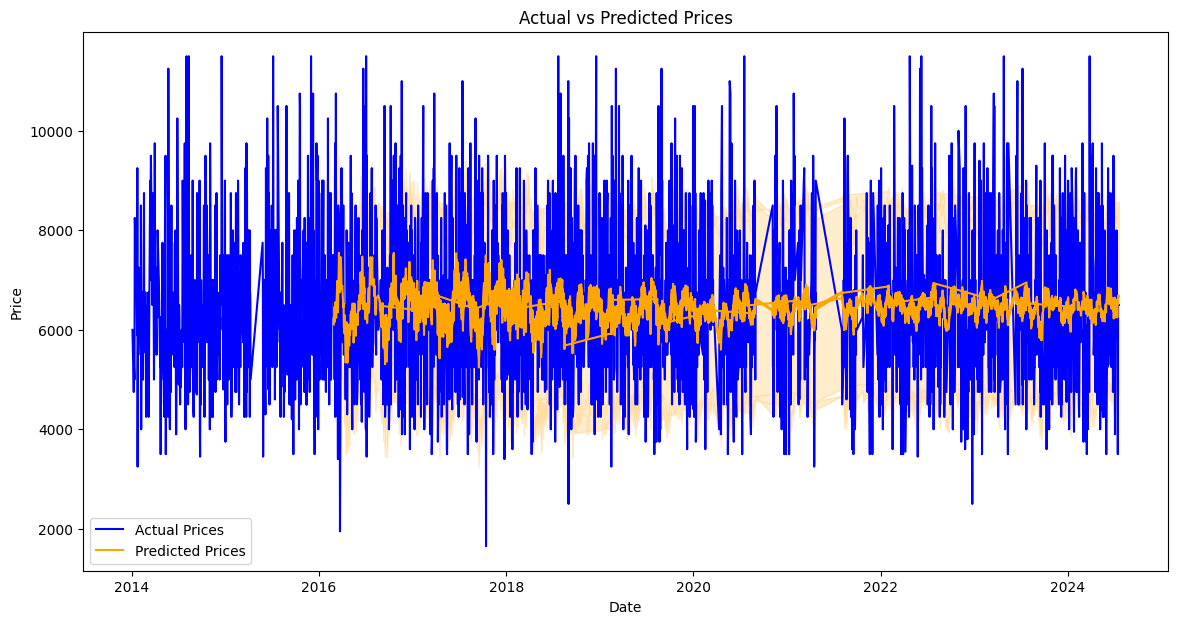

/usr/local/lib/python3.10/dist-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


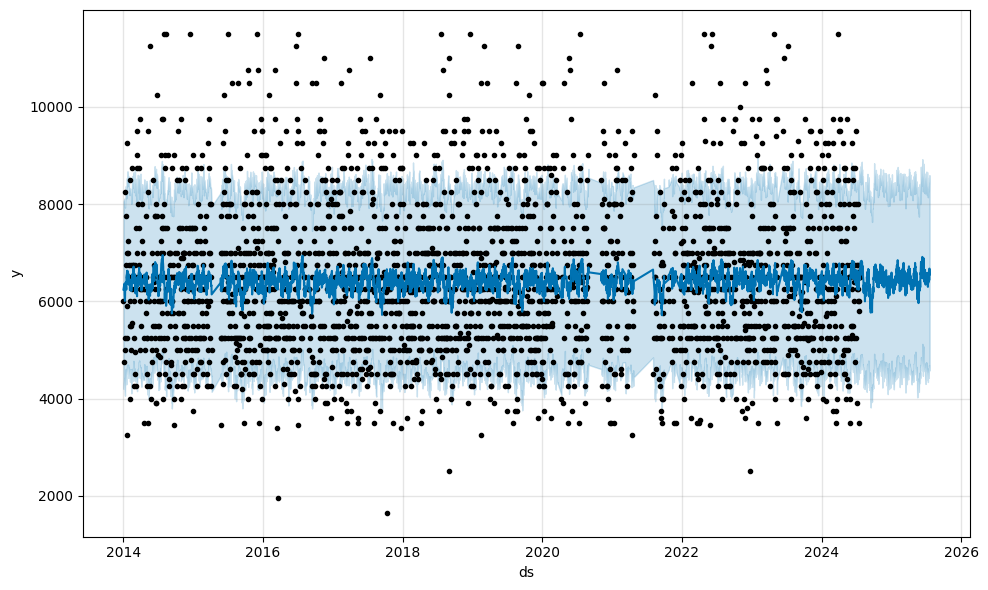

/usr/local/lib/python3.10/dist-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` o

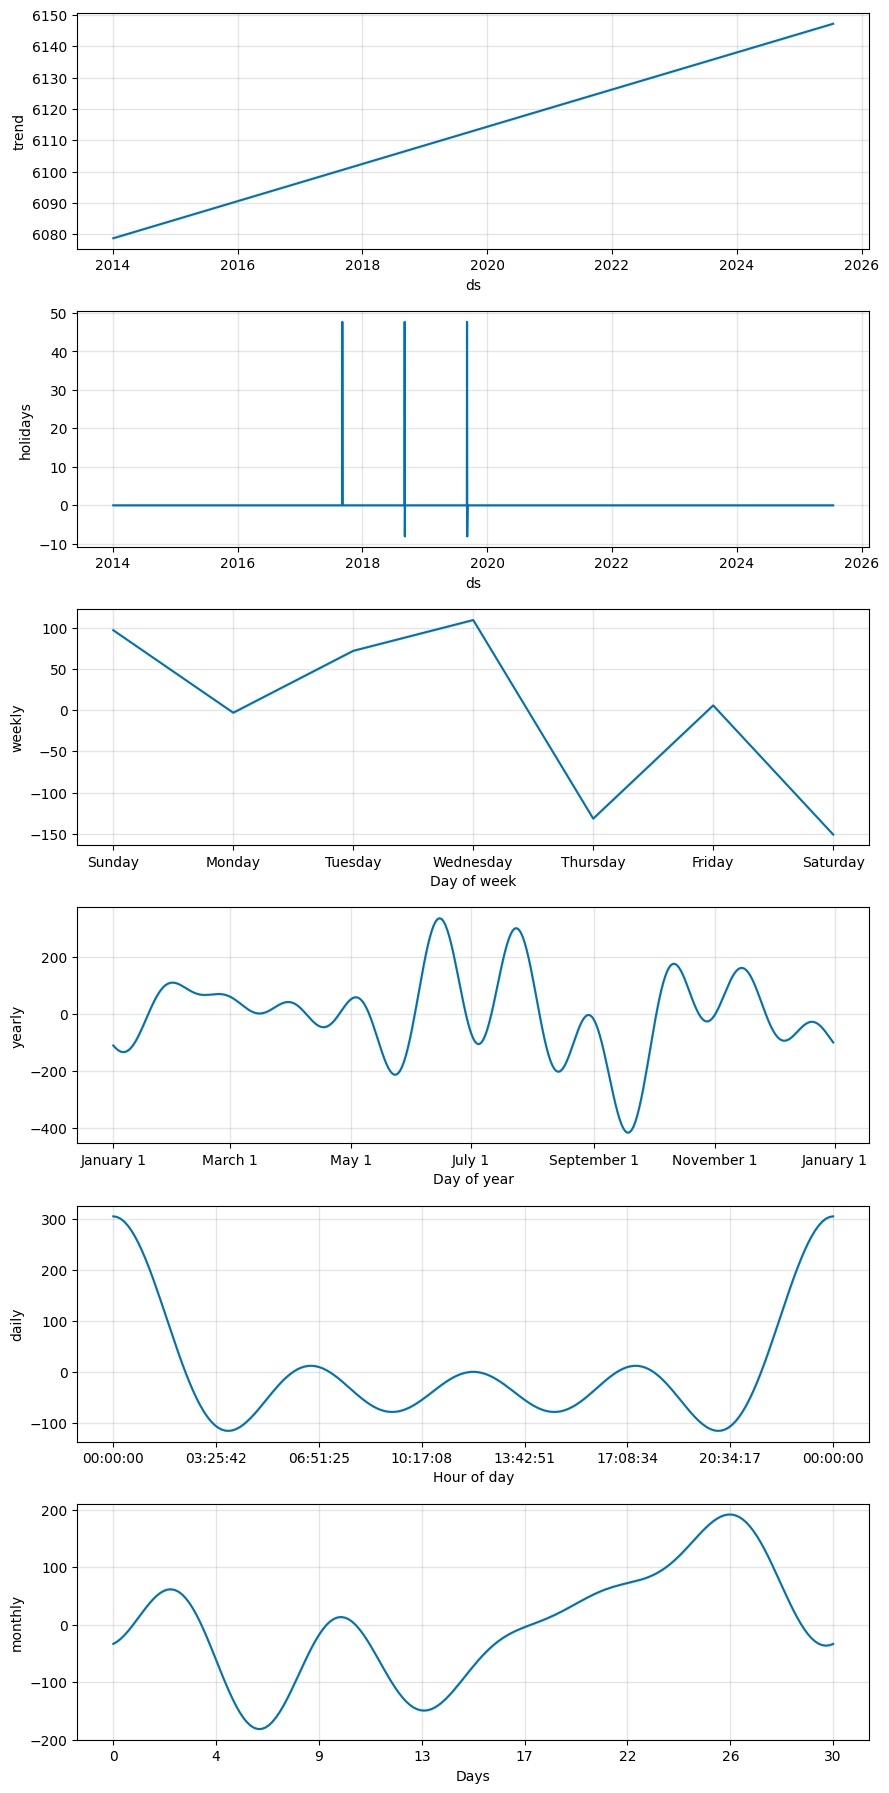

        Date  Predicted Price  Lower Bound  Upper Bound
0 2014-01-03      6241.687283  4200.198095  8054.901715
1 2014-01-08      6361.209866  4423.940782  8113.451021
2 2014-01-09      6134.759065  4203.612922  7962.185349
3 2014-01-11      6008.361394  4058.970200  7928.049980
4 2014-01-12      6231.269902  4355.713177  8028.488795


In [ ]:
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid

# Load the data
file = '/content/apple_cleaned.csv'
data = pd.read_csv(file)

# Remove rows with NaN in the 'date' column
data = data.dropna(subset=['date'])

# Prepare the data for Prophet
data['date'] = pd.to_datetime(data['date'])
data['average_price'] = data[['Min Price (Rs./Quintal)', 'Max Price (Rs./Quintal)']].mean(axis=1)
data_prophet = data[['date', 'average_price']].rename(columns={'date': 'ds', 'average_price': 'y'})

# Outlier Removal (adjust thresholds as per your data)
threshold_high = 15000  # Example high price threshold
threshold_low = 500     # Example low price threshold
data_prophet = data_prophet[(data_prophet['y'] < threshold_high) & (data_prophet['y'] > threshold_low)]

# Define custom seasonality (e.g., monthly seasonality)
monthly_seasonality = 30.5  # Approximate number of days in a month

# Define holidays (this is an example, adjust based on actual data)
holidays = pd.DataFrame({
    'holiday': 'apple_holiday',
    'ds': pd.to_datetime(['2017-09-05', '2018-09-05', '2019-09-05']),  # Example dates
    'lower_window': 0,
    'upper_window': 1,
})

# Initialize parameter grid for tuning
param_grid = {
    'changepoint_prior_scale': [0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.1, 1.0, 10.0],
    'holidays_prior_scale': [0.1, 1.0, 10.0],
}

# Create a grid search loop for hyperparameter tuning
best_model = None
best_performance = float('inf')

for params in ParameterGrid(param_grid):
    # Initialize and fit the Prophet model with custom seasonality, holidays, and parameters
    model = Prophet(
        daily_seasonality=True,
        yearly_seasonality=True,
        holidays=holidays,
        changepoint_prior_scale=params['changepoint_prior_scale'],
        seasonality_prior_scale=params['seasonality_prior_scale'],
        holidays_prior_scale=params['holidays_prior_scale']
    )

    # Add monthly seasonality
    model.add_seasonality(name='monthly', period=monthly_seasonality, fourier_order=5)

    # Fit the model
    model.fit(data_prophet)

    # Perform cross-validation
    df_cv = cross_validation(model, initial='730 days', period='180 days', horizon='365 days', parallel='processes')

    # Calculate performance metrics
    df_p = performance_metrics(df_cv)

    # Display the performance metrics
    print(df_p.head())  # Display the first few rows of performance metrics

    # Track best performance
    mse = df_p['mse'].mean()
    if mse < best_performance:
        best_performance = mse
        best_model = model

# Display the best performance model
print(f"Best model MSE: {best_performance}")

# Plot the actual vs predicted prices from the best model
df_cv_best = cross_validation(best_model, initial='730 days', period='180 days', horizon='365 days', parallel='processes')

plt.figure(figsize=(14, 7))
plt.plot(data_prophet['ds'], data_prophet['y'], label='Actual Prices', color='blue')
plt.plot(df_cv_best['ds'], df_cv_best['yhat'], label='Predicted Prices', color='orange')
plt.fill_between(df_cv_best['ds'], df_cv_best['yhat_lower'], df_cv_best['yhat_upper'], color='orange', alpha=0.2)
plt.title('Actual vs Predicted Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Make a future dataframe for the next 365 days using the best model
future = best_model.make_future_dataframe(periods=365)

# Predict future values
forecast = best_model.predict(future)

# Plot the forecast
best_model.plot(forecast)
plt.show()

# Plot the components (trend, weekly seasonality, yearly seasonality)
best_model.plot_components(forecast)
plt.show()

# Extract the relevant columns for predicted prices
predicted_prices = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

# Rename columns for clarity
predicted_prices.columns = ['Date', 'Predicted Price', 'Lower Bound', 'Upper Bound']

# Display the predicted prices table
print(predicted_prices.head())  # Display the first few rows of predicted prices

# Optionally, you can save this model for future use if needed


DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/0hqj8f6f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/gxsnpj7z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57469', 'data', 'file=/tmp/tmpbzbtl85n/0hqj8f6f.json', 'init=/tmp/tmpbzbtl85n/gxsnpj7z.json', 'output', 'file=/tmp/tmpbzbtl85n/prophet_modeld0hnmc0a/prophet_model-20240927205624.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:56:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:56:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 33 forecasts with cutoffs between 2016-03-03 00:00:00 and 2024-01-21 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7d9db047cc10>
DEBUG:cmdstanpy:input tempfile:

  horizon           mse         rmse          mae      mape     mdape  \
0 17 days  2.568201e+06  1602.560609  1227.392950  0.198084  0.154750   
1 18 days  2.558143e+06  1599.419557  1228.376433  0.199818  0.150816   
2 19 days  2.514236e+06  1585.634294  1215.133556  0.197853  0.150816   
3 20 days  2.532412e+06  1591.355524  1219.042403  0.202827  0.150013   
4 21 days  2.483284e+06  1575.843977  1199.572004  0.200044  0.149304   

      smape  coverage  
0  0.188562  0.788260  
1  0.189438  0.779874  
2  0.187634  0.786792  
3  0.189189  0.788747  
4  0.186400  0.797170  


DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/mh3wt_nh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59349', 'data', 'file=/tmp/tmpbzbtl85n/ttbr4jis.json', 'init=/tmp/tmpbzbtl85n/mh3wt_nh.json', 'output', 'file=/tmp/tmpbzbtl85n/prophet_modelyumi5ljz/prophet_model-20240927205646.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:56:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:56:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 33 forecasts with cutoffs between 2016-03-03 00:00:00 and 2024-01-21 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7d9db0336200>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/g635nm28.json
DEBUG:cmdstanpy:input tempfile:

  horizon           mse         rmse          mae      mape     mdape  \
0 17 days  2.570089e+06  1603.149568  1225.873876  0.197827  0.155724   
1 18 days  2.558045e+06  1599.388807  1226.310583  0.199463  0.150069   
2 19 days  2.513525e+06  1585.410035  1212.752320  0.197436  0.150069   
3 20 days  2.532643e+06  1591.427879  1216.517741  0.202421  0.148814   
4 21 days  2.483413e+06  1575.884925  1196.970190  0.199625  0.147734   

      smape  coverage  
0  0.188347  0.790618  
1  0.189132  0.786950  
2  0.187276  0.793868  
3  0.188802  0.795822  
4  0.185995  0.804245  


DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/vq5v9d1l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29390', 'data', 'file=/tmp/tmpbzbtl85n/m0tm45xa.json', 'init=/tmp/tmpbzbtl85n/vq5v9d1l.json', 'output', 'file=/tmp/tmpbzbtl85n/prophet_modelgzvaoi07/prophet_model-20240927205710.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:57:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:57:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 33 forecasts with cutoffs between 2016-03-03 00:00:00 and 2024-01-21 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7d9db1a6aec0>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/kwld4wxa.json
DEBUG:cmdstanpy:input tempfile:

  horizon           mse         rmse          mae      mape     mdape  \
0 17 days  2.574043e+06  1604.382453  1227.107044  0.197827  0.154206   
1 18 days  2.562080e+06  1600.649747  1227.050210  0.199389  0.149046   
2 19 days  2.518787e+06  1587.068742  1213.778471  0.197411  0.149046   
3 20 days  2.536256e+06  1592.562683  1217.488659  0.202338  0.147856   
4 21 days  2.486584e+06  1576.890643  1197.827150  0.199543  0.146787   

      smape  coverage  
0  0.188501  0.790618  
1  0.189210  0.786950  
2  0.187396  0.793868  
3  0.188924  0.795822  
4  0.186107  0.804245  


DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/ob9vc2i9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15759', 'data', 'file=/tmp/tmpbzbtl85n/d4zvldh_.json', 'init=/tmp/tmpbzbtl85n/ob9vc2i9.json', 'output', 'file=/tmp/tmpbzbtl85n/prophet_modelpkk31yso/prophet_model-20240927205733.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:57:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:57:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 33 forecasts with cutoffs between 2016-03-03 00:00:00 and 2024-01-21 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7d9dffd98d00>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/7fh1o200.json
DEBUG:cmdstanpy:input tempfile:

  horizon           mse         rmse          mae      mape     mdape  \
0 17 days  2.573287e+06  1604.146964  1226.407411  0.197769  0.153416   
1 18 days  2.560863e+06  1600.269780  1226.302937  0.199323  0.148692   
2 19 days  2.516952e+06  1586.490594  1212.963386  0.197337  0.148692   
3 20 days  2.534191e+06  1591.914300  1216.604899  0.202259  0.147940   
4 21 days  2.484557e+06  1576.247820  1197.013692  0.199467  0.147614   

      smape  coverage  
0  0.188419  0.792977  
1  0.189120  0.789308  
2  0.187297  0.796226  
3  0.188816  0.798181  
4  0.186009  0.806604  


DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/qsc7peaq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75800', 'data', 'file=/tmp/tmpbzbtl85n/m65ym__2.json', 'init=/tmp/tmpbzbtl85n/qsc7peaq.json', 'output', 'file=/tmp/tmpbzbtl85n/prophet_model8ix0ht05/prophet_model-20240927205757.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:57:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:57:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 33 forecasts with cutoffs between 2016-03-03 00:00:00 and 2024-01-21 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7d9db1501600>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/r80o6762.json
DEBUG:cmdstanpy:input tempfile:

  horizon           mse         rmse          mae      mape     mdape  \
0 17 days  2.564832e+06  1601.509388  1226.099779  0.197830  0.154044   
1 18 days  2.555076e+06  1598.460474  1227.223852  0.199583  0.150918   
2 19 days  2.511113e+06  1584.649083  1214.074387  0.197636  0.150918   
3 20 days  2.528853e+06  1590.236698  1217.824660  0.202577  0.149998   
4 21 days  2.480094e+06  1574.831462  1198.294465  0.199789  0.149047   

      smape  coverage  
0  0.188367  0.788260  
1  0.189265  0.782233  
2  0.187477  0.789151  
3  0.189007  0.791105  
4  0.186209  0.799528  


DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/ixsv48hz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9410', 'data', 'file=/tmp/tmpbzbtl85n/cy5ffga2.json', 'init=/tmp/tmpbzbtl85n/ixsv48hz.json', 'output', 'file=/tmp/tmpbzbtl85n/prophet_modelsql93553/prophet_model-20240927205820.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:58:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:58:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 33 forecasts with cutoffs between 2016-03-03 00:00:00 and 2024-01-21 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7d9db1502800>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/czhlx72g.json
DEBUG:cmdstanpy:input tempfile: 

  horizon           mse         rmse          mae      mape     mdape  \
0 17 days  2.572911e+06  1604.029700  1227.590555  0.198116  0.154980   
1 18 days  2.561813e+06  1600.566340  1228.117987  0.199762  0.152168   
2 19 days  2.517917e+06  1586.794549  1214.736161  0.197763  0.152168   
3 20 days  2.536951e+06  1592.780985  1218.594209  0.202760  0.150667   
4 21 days  2.488424e+06  1577.474031  1199.067654  0.199959  0.149882   

      smape  coverage  
0  0.188587  0.792977  
1  0.189386  0.789308  
2  0.187557  0.796226  
3  0.189098  0.798181  
4  0.186294  0.808962  


DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/46tglzt_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85799', 'data', 'file=/tmp/tmpbzbtl85n/a6twgx1t.json', 'init=/tmp/tmpbzbtl85n/46tglzt_.json', 'output', 'file=/tmp/tmpbzbtl85n/prophet_modelpha62tt3/prophet_model-20240927205844.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:58:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:58:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 33 forecasts with cutoffs between 2016-03-03 00:00:00 and 2024-01-21 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7d9db0231780>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/q0lttze5.json
DEBUG:cmdstanpy:input tempfile:

  horizon           mse         rmse          mae      mape     mdape  \
0 17 days  2.573363e+06  1604.170581  1227.061181  0.197820  0.153374   
1 18 days  2.562822e+06  1600.881762  1227.668765  0.199489  0.149123   
2 19 days  2.519421e+06  1587.268425  1214.407906  0.197517  0.149123   
3 20 days  2.536743e+06  1592.715710  1218.154693  0.202440  0.148363   
4 21 days  2.487453e+06  1577.166194  1198.461583  0.199635  0.148277   

      smape  coverage  
0  0.188492  0.789308  
1  0.189304  0.784591  
2  0.187495  0.791509  
3  0.189029  0.793464  
4  0.186208  0.801887  


DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/0vwraok_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53555', 'data', 'file=/tmp/tmpbzbtl85n/17cx5ap7.json', 'init=/tmp/tmpbzbtl85n/0vwraok_.json', 'output', 'file=/tmp/tmpbzbtl85n/prophet_modelikudb0co/prophet_model-20240927205909.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:59:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:59:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 33 forecasts with cutoffs between 2016-03-03 00:00:00 and 2024-01-21 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7d9db0333880>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/k8ic7c8v.json
DEBUG:cmdstanpy:input tempfile:

  horizon           mse         rmse          mae      mape     mdape  \
0 17 days  2.571856e+06  1603.700800  1225.719035  0.197611  0.153770   
1 18 days  2.559934e+06  1599.979409  1225.935133  0.199215  0.150002   
2 19 days  2.516052e+06  1586.206716  1212.738464  0.197253  0.150002   
3 20 days  2.532863e+06  1591.497152  1216.348154  0.202160  0.148576   
4 21 days  2.483368e+06  1575.870599  1196.634080  0.199346  0.147335   

      smape  coverage  
0  0.188307  0.788260  
1  0.189058  0.784591  
2  0.187261  0.791509  
3  0.188774  0.793464  
4  0.185949  0.801887  


DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/y5w1ere2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37245', 'data', 'file=/tmp/tmpbzbtl85n/sj4_cm1b.json', 'init=/tmp/tmpbzbtl85n/y5w1ere2.json', 'output', 'file=/tmp/tmpbzbtl85n/prophet_modelhuewnfqf/prophet_model-20240927205934.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:59:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:59:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 33 forecasts with cutoffs between 2016-03-03 00:00:00 and 2024-01-21 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7d9db1a6aec0>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/nn03e0lq.json
DEBUG:cmdstanpy:input tempfile:

  horizon           mse         rmse          mae      mape     mdape  \
0 17 days  2.565988e+06  1601.870154  1226.517813  0.197936  0.154328   
1 18 days  2.555927e+06  1598.726630  1227.556324  0.199677  0.150013   
2 19 days  2.511923e+06  1584.904632  1214.261235  0.197706  0.150013   
3 20 days  2.529958e+06  1590.584051  1218.091571  0.202666  0.149304   
4 21 days  2.480723e+06  1575.031216  1198.563381  0.199875  0.149171   

      smape  coverage  
0  0.188429  0.788260  
1  0.189314  0.784591  
2  0.187502  0.791509  
3  0.189045  0.793464  
4  0.186248  0.801887  


DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/do9svogs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84494', 'data', 'file=/tmp/tmpbzbtl85n/ig7hlqzq.json', 'init=/tmp/tmpbzbtl85n/do9svogs.json', 'output', 'file=/tmp/tmpbzbtl85n/prophet_modelqg3qrtz6/prophet_model-20240927205957.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:59:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:59:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 33 forecasts with cutoffs between 2016-03-03 00:00:00 and 2024-01-21 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7d9db0330670>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/eoya09pm.json
DEBUG:cmdstanpy:input tempfile:

  horizon           mse         rmse          mae      mape     mdape  \
0 17 days  2.571572e+06  1603.612299  1225.984880  0.197863  0.155179   
1 18 days  2.559982e+06  1599.994393  1226.504555  0.199507  0.150707   
2 19 days  2.515306e+06  1585.971499  1212.884469  0.197470  0.150707   
3 20 days  2.534102e+06  1591.886419  1216.629022  0.202452  0.149100   
4 21 days  2.485530e+06  1576.556239  1197.144497  0.199658  0.147543   

      smape  coverage  
0  0.188362  0.788260  
1  0.189160  0.783368  
2  0.187295  0.789151  
3  0.188819  0.791105  
4  0.186022  0.799528  


DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/4wnatejh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53453', 'data', 'file=/tmp/tmpbzbtl85n/wy77f15s.json', 'init=/tmp/tmpbzbtl85n/4wnatejh.json', 'output', 'file=/tmp/tmpbzbtl85n/prophet_modeltrip8esw/prophet_model-20240927210021.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:00:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:00:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 33 forecasts with cutoffs between 2016-03-03 00:00:00 and 2024-01-21 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7d9db08f97b0>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/z2nao4lq.json
DEBUG:cmdstanpy:input tempfile:

  horizon           mse         rmse          mae      mape     mdape  \
0 17 days  2.575405e+06  1604.806797  1227.826080  0.198042  0.154368   
1 18 days  2.564308e+06  1601.345818  1228.189699  0.199667  0.150524   
2 19 days  2.520892e+06  1587.731643  1214.828310  0.197667  0.150524   
3 20 days  2.539048e+06  1593.439119  1218.830370  0.202646  0.149650   
4 21 days  2.490108e+06  1578.007532  1199.323092  0.199864  0.148890   

      smape  coverage  
0  0.188609  0.788260  
1  0.189382  0.783368  
2  0.187557  0.789151  
3  0.189131  0.791105  
4  0.186335  0.799528  


DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/43ba8iae.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74096', 'data', 'file=/tmp/tmpbzbtl85n/b4x0m20l.json', 'init=/tmp/tmpbzbtl85n/43ba8iae.json', 'output', 'file=/tmp/tmpbzbtl85n/prophet_modelpkh21mt7/prophet_model-20240927210045.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:00:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:00:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 33 forecasts with cutoffs between 2016-03-03 00:00:00 and 2024-01-21 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7d9db0763ac0>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/k8traxo3.json
DEBUG:cmdstanpy:input tempfile:

  horizon           mse         rmse          mae      mape     mdape  \
0 17 days  2.574115e+06  1604.404884  1227.602214  0.197963  0.153484   
1 18 days  2.562834e+06  1600.885299  1227.988250  0.199594  0.150121   
2 19 days  2.519524e+06  1587.300701  1214.825244  0.197634  0.150121   
3 20 days  2.537339e+06  1592.902807  1218.681147  0.202596  0.149827   
4 21 days  2.488649e+06  1577.545109  1199.461848  0.199857  0.148568   

      smape  coverage  
0  0.188578  0.790618  
1  0.189354  0.784591  
2  0.187559  0.791509  
3  0.189111  0.793464  
4  0.186360  0.801887  


DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/f2962r52.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62501', 'data', 'file=/tmp/tmpbzbtl85n/koi6chwz.json', 'init=/tmp/tmpbzbtl85n/f2962r52.json', 'output', 'file=/tmp/tmpbzbtl85n/prophet_modelb3379jqc/prophet_model-20240927210110.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:01:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:01:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 33 forecasts with cutoffs between 2016-03-03 00:00:00 and 2024-01-21 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7d9db0a83790>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/zoq6nq5x.json
DEBUG:cmdstanpy:input tempfile:

  horizon           mse         rmse          mae      mape     mdape  \
0 17 days  2.567419e+06  1602.316802  1227.091717  0.198070  0.154980   
1 18 days  2.557413e+06  1599.191285  1228.152765  0.199816  0.149998   
2 19 days  2.513539e+06  1585.414302  1214.880438  0.197847  0.149998   
3 20 days  2.531276e+06  1590.998524  1218.622604  0.202791  0.149215   
4 21 days  2.482241e+06  1575.513052  1199.011806  0.199988  0.149096   

      smape  coverage  
0  0.188513  0.785901  
1  0.189401  0.782233  
2  0.187593  0.789151  
3  0.189123  0.791105  
4  0.186313  0.799528  


DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/xqgmbe7f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=791', 'data', 'file=/tmp/tmpbzbtl85n/tgxso4mv.json', 'init=/tmp/tmpbzbtl85n/xqgmbe7f.json', 'output', 'file=/tmp/tmpbzbtl85n/prophet_modelg_r1417o/prophet_model-20240927210135.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:01:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:01:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 33 forecasts with cutoffs between 2016-03-03 00:00:00 and 2024-01-21 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7d9db02303a0>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/kajirld8.json
DEBUG:cmdstanpy:input tempfile: /

  horizon           mse         rmse          mae      mape     mdape  \
0 17 days  2.571605e+06  1603.622468  1225.635882  0.197786  0.155303   
1 18 days  2.560084e+06  1600.026243  1226.202882  0.199440  0.150723   
2 19 days  2.515158e+06  1585.924889  1212.575837  0.197404  0.150723   
3 20 days  2.533809e+06  1591.794377  1216.301606  0.202380  0.148857   
4 21 days  2.485130e+06  1576.429577  1196.731614  0.199577  0.147013   

      smape  coverage  
0  0.188309  0.785901  
1  0.189115  0.782233  
2  0.187250  0.789151  
3  0.188770  0.791105  
4  0.185960  0.797170  


DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/w6h0xfft.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84324', 'data', 'file=/tmp/tmpbzbtl85n/e361uzke.json', 'init=/tmp/tmpbzbtl85n/w6h0xfft.json', 'output', 'file=/tmp/tmpbzbtl85n/prophet_modelu84nmkxw/prophet_model-20240927210200.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:02:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:02:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 33 forecasts with cutoffs between 2016-03-03 00:00:00 and 2024-01-21 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7d9db0330bb0>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/1qcou_b8.json
DEBUG:cmdstanpy:input tempfile:

  horizon           mse         rmse          mae      mape     mdape  \
0 17 days  2.575169e+06  1604.733225  1227.430868  0.197920  0.154409   
1 18 days  2.564377e+06  1601.367274  1227.916620  0.199567  0.149724   
2 19 days  2.521180e+06  1587.822286  1214.753357  0.197605  0.149724   
3 20 days  2.538081e+06  1593.135586  1218.327595  0.202500  0.148964   
4 21 days  2.488840e+06  1577.605764  1198.485736  0.199667  0.147972   

      smape  coverage  
0  0.188543  0.792977  
1  0.189336  0.789308  
2  0.187542  0.796226  
3  0.189051  0.795822  
4  0.186206  0.799528  


DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/g6bnkeo3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27265', 'data', 'file=/tmp/tmpbzbtl85n/j1j7r96i.json', 'init=/tmp/tmpbzbtl85n/g6bnkeo3.json', 'output', 'file=/tmp/tmpbzbtl85n/prophet_model50oh4ene/prophet_model-20240927210224.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:02:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:02:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 33 forecasts with cutoffs between 2016-03-03 00:00:00 and 2024-01-21 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7d9db08fb3a0>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/19je9ijt.json
DEBUG:cmdstanpy:input tempfile:

  horizon           mse         rmse          mae      mape     mdape  \
0 17 days  2.571240e+06  1603.508790  1225.075591  0.197475  0.152402   
1 18 days  2.559745e+06  1599.920233  1225.410412  0.199097  0.149946   
2 19 days  2.515481e+06  1586.026737  1212.142973  0.197130  0.149946   
3 20 days  2.532443e+06  1591.365232  1215.855191  0.202051  0.148634   
4 21 days  2.483737e+06  1575.987672  1196.330076  0.199279  0.147392   

      smape  coverage  
0  0.188217  0.796646  
1  0.188987  0.790444  
2  0.187179  0.796226  
3  0.188708  0.798181  
4  0.185912  0.808962  


DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/5vdqr502.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59470', 'data', 'file=/tmp/tmpbzbtl85n/vnk4mwl1.json', 'init=/tmp/tmpbzbtl85n/5vdqr502.json', 'output', 'file=/tmp/tmpbzbtl85n/prophet_model4z1hvesk/prophet_model-20240927210249.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:02:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:02:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 33 forecasts with cutoffs between 2016-03-03 00:00:00 and 2024-01-21 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7d9dffd98c70>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/d_l9579f.json
DEBUG:cmdstanpy:input tempfile:

  horizon           mse         rmse          mae      mape     mdape  \
0 17 days  2.575153e+06  1604.728295  1234.448233  0.199446  0.159795   
1 18 days  2.564830e+06  1601.508544  1234.255548  0.200886  0.154681   
2 19 days  2.516311e+06  1586.288572  1219.396514  0.198577  0.154681   
3 20 days  2.530835e+06  1590.859877  1222.295521  0.203310  0.154681   
4 21 days  2.478914e+06  1574.456804  1200.704027  0.200166  0.150434   

      smape  coverage  
0  0.189596  0.789570  
1  0.190270  0.782233  
2  0.188220  0.789151  
3  0.189633  0.788747  
4  0.186544  0.797170  


DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/87nacfpy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4779', 'data', 'file=/tmp/tmpbzbtl85n/_oent01z.json', 'init=/tmp/tmpbzbtl85n/87nacfpy.json', 'output', 'file=/tmp/tmpbzbtl85n/prophet_model9nneue9k/prophet_model-20240927210314.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:03:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:03:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 33 forecasts with cutoffs between 2016-03-03 00:00:00 and 2024-01-21 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7d9db0231690>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/c0b_5vww.json
DEBUG:cmdstanpy:input tempfile: 

  horizon           mse         rmse          mae      mape     mdape  \
0 17 days  2.579793e+06  1606.173354  1238.036627  0.200385  0.161586   
1 18 days  2.570365e+06  1603.235804  1237.182821  0.201656  0.154046   
2 19 days  2.521384e+06  1587.886603  1221.432916  0.199149  0.153827   
3 20 days  2.533767e+06  1591.781105  1223.136087  0.203682  0.153547   
4 21 days  2.482461e+06  1575.582594  1201.072581  0.200437  0.152349   

      smape  coverage  
0  0.190083  0.790618  
1  0.190637  0.786950  
2  0.188445  0.793868  
3  0.189673  0.793464  
4  0.186529  0.801887  


DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/letitwux.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43948', 'data', 'file=/tmp/tmpbzbtl85n/h8ofhblq.json', 'init=/tmp/tmpbzbtl85n/letitwux.json', 'output', 'file=/tmp/tmpbzbtl85n/prophet_modeletvo52pm/prophet_model-20240927210343.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:03:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:03:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 33 forecasts with cutoffs between 2016-03-03 00:00:00 and 2024-01-21 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7d9db1a6aec0>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/mnedg6sy.json
DEBUG:cmdstanpy:input tempfile:

  horizon           mse         rmse          mae      mape     mdape  \
0 17 days  2.594588e+06  1610.772614  1242.533742  0.200656  0.163220   
1 18 days  2.584650e+06  1607.684586  1240.400709  0.201666  0.154731   
2 19 days  2.529179e+06  1590.339119  1222.461375  0.198777  0.154375   
3 20 days  2.533712e+06  1591.763875  1223.069231  0.202843  0.154375   
4 21 days  2.482721e+06  1575.665398  1201.189608  0.199621  0.152876   

      smape  coverage  
0  0.190816  0.785901  
1  0.191170  0.782233  
2  0.188653  0.789151  
3  0.189759  0.788747  
4  0.186662  0.797170  


DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/2yi8gv4a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51986', 'data', 'file=/tmp/tmpbzbtl85n/u1zdmdsr.json', 'init=/tmp/tmpbzbtl85n/2yi8gv4a.json', 'output', 'file=/tmp/tmpbzbtl85n/prophet_model5wmtzkap/prophet_model-20240927210408.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:04:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:04:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 33 forecasts with cutoffs between 2016-03-03 00:00:00 and 2024-01-21 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7d9dffd98c70>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/gh9opc2g.json
DEBUG:cmdstanpy:input tempfile:

  horizon           mse         rmse          mae      mape     mdape  \
0 17 days  2.585108e+06  1607.826993  1240.520704  0.200910  0.159597   
1 18 days  2.577735e+06  1605.532584  1239.221949  0.202107  0.153909   
2 19 days  2.524560e+06  1588.886377  1222.286076  0.199420  0.153294   
3 20 days  2.534739e+06  1592.086275  1223.279980  0.203812  0.153294   
4 21 days  2.483541e+06  1575.925486  1200.706474  0.200442  0.152152   

      smape  coverage  
0  0.190478  0.779874  
1  0.190958  0.777516  
2  0.188592  0.784434  
3  0.189719  0.784030  
4  0.186481  0.792453  


DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/_5h1d4cg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44510', 'data', 'file=/tmp/tmpbzbtl85n/bfbte5kb.json', 'init=/tmp/tmpbzbtl85n/_5h1d4cg.json', 'output', 'file=/tmp/tmpbzbtl85n/prophet_modelgaq6l087/prophet_model-20240927210434.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:04:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:04:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 33 forecasts with cutoffs between 2016-03-03 00:00:00 and 2024-01-21 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7d9db1a6aec0>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/yejwdlpj.json
DEBUG:cmdstanpy:input tempfile:

  horizon           mse         rmse          mae      mape     mdape  \
0 17 days  2.575738e+06  1604.910447  1234.863871  0.199460  0.159612   
1 18 days  2.565869e+06  1601.832866  1234.874311  0.200924  0.154592   
2 19 days  2.517611e+06  1586.698130  1220.059352  0.198620  0.154592   
3 20 days  2.531806e+06  1591.165047  1222.777719  0.203321  0.154592   
4 21 days  2.479963e+06  1574.789738  1201.234885  0.200184  0.150469   

      smape  coverage  
0  0.189657  0.785901  
1  0.190362  0.781010  
2  0.188320  0.786792  
3  0.189705  0.788747  
4  0.186624  0.797170  


DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/mvor1fdc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90847', 'data', 'file=/tmp/tmpbzbtl85n/a25dxh2f.json', 'init=/tmp/tmpbzbtl85n/mvor1fdc.json', 'output', 'file=/tmp/tmpbzbtl85n/prophet_model92u97j2w/prophet_model-20240927210504.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:05:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:05:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 33 forecasts with cutoffs between 2016-03-03 00:00:00 and 2024-01-21 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7d9db0a83790>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/a6br5ole.json
DEBUG:cmdstanpy:input tempfile:

  horizon           mse         rmse          mae      mape     mdape  \
0 17 days  2.580890e+06  1606.514896  1239.320015  0.200416  0.162540   
1 18 days  2.574124e+06  1604.407669  1238.827942  0.201773  0.155397   
2 19 days  2.525248e+06  1589.102795  1223.158124  0.199280  0.155022   
3 20 days  2.538096e+06  1593.140335  1225.060000  0.203851  0.155022   
4 21 days  2.488078e+06  1577.364236  1203.476438  0.200679  0.153256   

      smape  coverage  
0  0.190278  0.785901  
1  0.190883  0.782233  
2  0.188713  0.789151  
3  0.189971  0.788747  
4  0.186895  0.797170  


DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/h6rfx_le.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39677', 'data', 'file=/tmp/tmpbzbtl85n/l9lt6rkf.json', 'init=/tmp/tmpbzbtl85n/h6rfx_le.json', 'output', 'file=/tmp/tmpbzbtl85n/prophet_model9a2hruza/prophet_model-20240927210530.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:05:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:05:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 33 forecasts with cutoffs between 2016-03-03 00:00:00 and 2024-01-21 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7d9db07bd8a0>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/361dyrvn.json
DEBUG:cmdstanpy:input tempfile:

  horizon           mse         rmse          mae      mape     mdape  \
0 17 days  2.607521e+06  1614.781883  1245.807097  0.201064  0.162940   
1 18 days  2.595924e+06  1611.187170  1243.924775  0.202115  0.155690   
2 19 days  2.542671e+06  1594.575648  1226.829600  0.199351  0.155251   
3 20 days  2.549218e+06  1596.627216  1228.388989  0.203554  0.155251   
4 21 days  2.500226e+06  1581.210153  1207.290615  0.200450  0.152986   

      smape  coverage  
0  0.191206  0.783543  
1  0.191605  0.779874  
2  0.189220  0.786792  
3  0.190469  0.788747  
4  0.187492  0.797170  


DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/n3qkt1l2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71305', 'data', 'file=/tmp/tmpbzbtl85n/wvaj6uvs.json', 'init=/tmp/tmpbzbtl85n/n3qkt1l2.json', 'output', 'file=/tmp/tmpbzbtl85n/prophet_model9qagtzpt/prophet_model-20240927210556.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:05:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:05:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 33 forecasts with cutoffs between 2016-03-03 00:00:00 and 2024-01-21 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7d9db0330be0>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/an2yhoo9.json
DEBUG:cmdstanpy:input tempfile:

  horizon           mse         rmse          mae      mape     mdape  \
0 17 days  2.603611e+06  1613.570805  1244.419142  0.201362  0.163125   
1 18 days  2.596065e+06  1611.230892  1243.245141  0.202588  0.154864   
2 19 days  2.543373e+06  1594.795530  1226.693412  0.199965  0.154662   
3 20 days  2.557089e+06  1599.090005  1228.971086  0.204551  0.154662   
4 21 days  2.505974e+06  1583.026898  1207.014598  0.201312  0.153747   

      smape  coverage  
0  0.190918  0.782233  
1  0.191416  0.778651  
2  0.189110  0.784434  
3  0.190428  0.784030  
4  0.187292  0.792453  


DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/6cy2kkqc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74446', 'data', 'file=/tmp/tmpbzbtl85n/hfjze6_9.json', 'init=/tmp/tmpbzbtl85n/6cy2kkqc.json', 'output', 'file=/tmp/tmpbzbtl85n/prophet_modelhs73j9yf/prophet_model-20240927210623.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:06:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:06:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 33 forecasts with cutoffs between 2016-03-03 00:00:00 and 2024-01-21 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7d9db08f8070>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/u4kcnti7.json
DEBUG:cmdstanpy:input tempfile:

  horizon           mse         rmse          mae      mape     mdape  \
0 17 days  2.575819e+06  1604.935680  1234.859135  0.199471  0.159345   
1 18 days  2.564749e+06  1601.483365  1234.536792  0.200894  0.155204   
2 19 days  2.516424e+06  1586.324111  1219.671585  0.198582  0.155204   
3 20 days  2.531154e+06  1590.960006  1222.572793  0.203315  0.155204   
4 21 days  2.479100e+06  1574.515661  1200.956578  0.200165  0.149772   

      smape  coverage  
0  0.189651  0.788522  
1  0.190305  0.782233  
2  0.188255  0.789151  
3  0.189668  0.791105  
4  0.186575  0.799528  


DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/cjel1tpq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73502', 'data', 'file=/tmp/tmpbzbtl85n/lezu0h_r.json', 'init=/tmp/tmpbzbtl85n/cjel1tpq.json', 'output', 'file=/tmp/tmpbzbtl85n/prophet_model7m49g826/prophet_model-20240927210650.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:06:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:06:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 33 forecasts with cutoffs between 2016-03-03 00:00:00 and 2024-01-21 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7d9db08f9930>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/nhvup6yj.json
DEBUG:cmdstanpy:input tempfile:

  horizon           mse         rmse          mae      mape     mdape  \
0 17 days  2.577379e+06  1605.421658  1237.810486  0.200210  0.159389   
1 18 days  2.568824e+06  1602.755108  1236.806251  0.201471  0.154761   
2 19 days  2.519341e+06  1587.243074  1220.781724  0.198910  0.153479   
3 20 days  2.531062e+06  1590.931052  1222.184154  0.203395  0.153479   
4 21 days  2.480119e+06  1574.839334  1199.986790  0.200110  0.151550   

      smape  coverage  
0  0.190063  0.786950  
1  0.190593  0.783368  
2  0.188364  0.789151  
3  0.189548  0.788747  
4  0.186378  0.799528  


DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/i2pgwad_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45150', 'data', 'file=/tmp/tmpbzbtl85n/zxjn79v_.json', 'init=/tmp/tmpbzbtl85n/i2pgwad_.json', 'output', 'file=/tmp/tmpbzbtl85n/prophet_model02ankr19/prophet_model-20240927210717.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:07:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:07:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 33 forecasts with cutoffs between 2016-03-03 00:00:00 and 2024-01-21 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7d9db07bd270>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/d7v3yanq.json
DEBUG:cmdstanpy:input tempfile:

  horizon           mse         rmse          mae      mape     mdape  \
0 17 days  2.612203e+06  1616.231105  1246.400406  0.201230  0.163015   
1 18 days  2.600106e+06  1612.484563  1244.294480  0.202231  0.156526   
2 19 days  2.546698e+06  1595.837857  1226.983911  0.199416  0.155163   
3 20 days  2.552672e+06  1597.708318  1228.144473  0.203543  0.155163   
4 21 days  2.503039e+06  1582.099591  1206.782127  0.200374  0.153002   

      smape  coverage  
0  0.191265  0.783805  
1  0.191634  0.777516  
2  0.189218  0.784434  
3  0.190410  0.784030  
4  0.187390  0.787736  


DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/61ebzkbz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68007', 'data', 'file=/tmp/tmpbzbtl85n/y3iveb5y.json', 'init=/tmp/tmpbzbtl85n/61ebzkbz.json', 'output', 'file=/tmp/tmpbzbtl85n/prophet_modeljnfuob6g/prophet_model-20240927210744.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:07:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:07:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 33 forecasts with cutoffs between 2016-03-03 00:00:00 and 2024-01-21 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7d9db0761000>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/g1ds0ofr.json
DEBUG:cmdstanpy:input tempfile:

  horizon           mse         rmse          mae      mape     mdape  \
0 17 days  2.603838e+06  1613.641332  1244.198584  0.201146  0.162859   
1 18 days  2.594276e+06  1610.675548  1243.089782  0.202348  0.156399   
2 19 days  2.544212e+06  1595.058487  1227.349094  0.199829  0.155358   
3 20 days  2.556475e+06  1598.898205  1229.274268  0.204356  0.155358   
4 21 days  2.505840e+06  1582.984386  1207.070376  0.201071  0.153594   

      smape  coverage  
0  0.190867  0.783543  
1  0.191383  0.779874  
2  0.189200  0.786792  
3  0.190470  0.788747  
4  0.187293  0.797170  


DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/qkwzosgt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/ug44yw8e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77600', 'data', 'file=/tmp/tmpbzbtl85n/qkwzosgt.json', 'init=/tmp/tmpbzbtl85n/ug44yw8e.json', 'output', 'file=/tmp/tmpbzbtl85n/prophet_modelfyo7w090/prophet_model-20240927210813.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:08:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:08:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 33 forecasts with cutoffs between 2016-03-03 00:00:00 and 2024-01-21 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7d9db027c730>
DEBUG:cmdstanpy:input tempfile:

  horizon           mse         rmse          mae      mape     mdape  \
0 17 days  2.575952e+06  1604.977258  1234.868668  0.199457  0.159850   
1 18 days  2.565752e+06  1601.796618  1234.774652  0.200911  0.154865   
2 19 days  2.517487e+06  1586.659158  1219.938170  0.198604  0.154865   
3 20 days  2.531636e+06  1591.111670  1222.705912  0.203316  0.154865   
4 21 days  2.479463e+06  1574.630923  1201.047784  0.200157  0.150739   

      smape  coverage  
0  0.189659  0.783543  
1  0.190346  0.779874  
2  0.188301  0.786792  
3  0.189694  0.788747  
4  0.186595  0.799528  


DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/bkpu82m8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19417', 'data', 'file=/tmp/tmpbzbtl85n/u8qz7c88.json', 'init=/tmp/tmpbzbtl85n/bkpu82m8.json', 'output', 'file=/tmp/tmpbzbtl85n/prophet_model92o8e_21/prophet_model-20240927210840.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:08:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:08:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 33 forecasts with cutoffs between 2016-03-03 00:00:00 and 2024-01-21 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7d9db0330be0>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/dpq4ygdm.json
DEBUG:cmdstanpy:input tempfile:

  horizon           mse         rmse          mae      mape     mdape  \
0 17 days  2.581471e+06  1606.695556  1238.757984  0.200476  0.160515   
1 18 days  2.573741e+06  1604.288420  1237.676884  0.201721  0.155256   
2 19 days  2.522792e+06  1588.329892  1221.594131  0.199167  0.154468   
3 20 days  2.534620e+06  1592.049075  1223.130059  0.203668  0.154468   
4 21 days  2.483305e+06  1575.850593  1201.172157  0.200432  0.153256   

      smape  coverage  
0  0.190199  0.782233  
1  0.190715  0.778651  
2  0.188479  0.784434  
3  0.189680  0.784030  
4  0.186551  0.792453  


DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/z5c5sgwi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22896', 'data', 'file=/tmp/tmpbzbtl85n/kyvzxnuo.json', 'init=/tmp/tmpbzbtl85n/z5c5sgwi.json', 'output', 'file=/tmp/tmpbzbtl85n/prophet_modelst03q2vf/prophet_model-20240927210906.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:09:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:09:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 33 forecasts with cutoffs between 2016-03-03 00:00:00 and 2024-01-21 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7d9db0761bd0>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/0thgf4ki.json
DEBUG:cmdstanpy:input tempfile:

  horizon           mse         rmse          mae      mape     mdape  \
0 17 days  2.610798e+06  1615.796288  1248.339111  0.201708  0.161885   
1 18 days  2.600501e+06  1612.606768  1245.678213  0.202602  0.154188   
2 19 days  2.545621e+06  1595.500199  1227.950011  0.199725  0.153667   
3 20 days  2.551298e+06  1597.278427  1229.261129  0.203867  0.153667   
4 21 days  2.501443e+06  1581.595223  1207.906619  0.200707  0.152767   

      smape  coverage  
0  0.191566  0.784591  
1  0.191841  0.782233  
2  0.189359  0.789151  
3  0.190579  0.788747  
4  0.187563  0.797170  


DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/ee1g7qvq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10732', 'data', 'file=/tmp/tmpbzbtl85n/048aj3yf.json', 'init=/tmp/tmpbzbtl85n/ee1g7qvq.json', 'output', 'file=/tmp/tmpbzbtl85n/prophet_model8twzyo9a/prophet_model-20240927210936.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:09:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:09:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 33 forecasts with cutoffs between 2016-03-03 00:00:00 and 2024-01-21 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7d9db1a6aec0>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/kx5a8pcb.json
DEBUG:cmdstanpy:input tempfile:

  horizon           mse         rmse          mae      mape     mdape  \
0 17 days  2.611867e+06  1616.127059  1244.728416  0.201427  0.155885   
1 18 days  2.602009e+06  1613.074501  1243.436349  0.202611  0.154196   
2 19 days  2.551864e+06  1597.455355  1227.115889  0.199978  0.153276   
3 20 days  2.564579e+06  1601.430177  1228.982338  0.204485  0.153155   
4 21 days  2.513368e+06  1585.360380  1206.505264  0.201146  0.151446   

      smape  coverage  
0  0.190874  0.778826  
1  0.191363  0.775157  
2  0.189090  0.782075  
3  0.190352  0.781671  
4  0.187134  0.792453  


DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/hhx3ocvd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10320', 'data', 'file=/tmp/tmpbzbtl85n/_muyxofo.json', 'init=/tmp/tmpbzbtl85n/hhx3ocvd.json', 'output', 'file=/tmp/tmpbzbtl85n/prophet_modelz9smw4u5/prophet_model-20240927211003.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:10:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:10:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 33 forecasts with cutoffs between 2016-03-03 00:00:00 and 2024-01-21 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7d9db06a7ca0>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/2qvks4td.json
DEBUG:cmdstanpy:input tempfile:

  horizon           mse         rmse          mae      mape     mdape  \
0 17 days  2.577299e+06  1605.396838  1236.735827  0.200239  0.157756   
1 18 days  2.568641e+06  1602.698078  1236.721946  0.201746  0.152203   
2 19 days  2.520317e+06  1587.550599  1222.051613  0.199494  0.152203   
3 20 days  2.538840e+06  1593.373795  1225.347196  0.204402  0.151716   
4 21 days  2.491384e+06  1578.411850  1205.363917  0.201492  0.150436   

      smape  coverage  
0  0.189938  0.785901  
1  0.190639  0.779874  
2  0.188624  0.786792  
3  0.190085  0.788747  
4  0.187235  0.794811  


DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/ok9vzoi4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26752', 'data', 'file=/tmp/tmpbzbtl85n/kv_kpny7.json', 'init=/tmp/tmpbzbtl85n/ok9vzoi4.json', 'output', 'file=/tmp/tmpbzbtl85n/prophet_model69eipfl2/prophet_model-20240927211030.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:10:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:10:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 33 forecasts with cutoffs between 2016-03-03 00:00:00 and 2024-01-21 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7d9db06a4f70>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/fux4zew5.json
DEBUG:cmdstanpy:input tempfile:

  horizon           mse         rmse          mae      mape     mdape  \
0 17 days  2.602797e+06  1613.318539  1250.507744  0.202757  0.161211   
1 18 days  2.594970e+06  1610.891026  1248.050866  0.203627  0.156788   
2 19 days  2.543093e+06  1594.707863  1230.838098  0.200781  0.156788   
3 20 days  2.552507e+06  1597.656741  1231.598546  0.204991  0.154834   
4 21 days  2.506872e+06  1583.310300  1210.403340  0.201743  0.151325   

      smape  coverage  
0  0.191976  0.789570  
1  0.192266  0.786950  
2  0.189863  0.793868  
3  0.190981  0.793885  
4  0.187986  0.804245  


DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/o6ui1sd4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63490', 'data', 'file=/tmp/tmpbzbtl85n/tnpi04e4.json', 'init=/tmp/tmpbzbtl85n/o6ui1sd4.json', 'output', 'file=/tmp/tmpbzbtl85n/prophet_models7rg53xo/prophet_model-20240927211102.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:11:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:11:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 33 forecasts with cutoffs between 2016-03-03 00:00:00 and 2024-01-21 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7d9db08398a0>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/t1ebbuur.json
DEBUG:cmdstanpy:input tempfile:

  horizon           mse         rmse          mae      mape     mdape  \
0 17 days  2.608882e+06  1615.203414  1251.252975  0.202891  0.160069   
1 18 days  2.599419e+06  1612.271465  1247.287470  0.203508  0.156454   
2 19 days  2.545063e+06  1595.325285  1229.040213  0.200494  0.155640   
3 20 days  2.551418e+06  1597.315727  1228.894501  0.204524  0.153175   
4 21 days  2.507387e+06  1583.473038  1208.692023  0.201455  0.151851   

      smape  coverage  
0  0.192117  0.785901  
1  0.192157  0.779874  
2  0.189581  0.786792  
3  0.190560  0.786809  
4  0.187726  0.797170  


DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/701a_3pq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93967', 'data', 'file=/tmp/tmpbzbtl85n/t572im5g.json', 'init=/tmp/tmpbzbtl85n/701a_3pq.json', 'output', 'file=/tmp/tmpbzbtl85n/prophet_modelpg94dibs/prophet_model-20240927211129.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:11:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:11:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 33 forecasts with cutoffs between 2016-03-03 00:00:00 and 2024-01-21 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7d9db07bde10>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/syx3v7s9.json
DEBUG:cmdstanpy:input tempfile:

  horizon           mse         rmse          mae      mape     mdape  \
0 17 days  2.604296e+06  1613.783062  1250.830431  0.202882  0.162719   
1 18 days  2.595785e+06  1611.144007  1247.880444  0.203661  0.156296   
2 19 days  2.544410e+06  1595.120744  1230.341285  0.200733  0.156253   
3 20 days  2.552682e+06  1597.711502  1230.713095  0.204818  0.156253   
4 21 days  2.508651e+06  1583.872024  1209.936010  0.201623  0.155659   

      smape  coverage  
0  0.192020  0.780136  
1  0.192226  0.775157  
2  0.189765  0.782075  
3  0.190833  0.782092  
4  0.187907  0.792453  


DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/z5yb4xqm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38', 'data', 'file=/tmp/tmpbzbtl85n/u6m43w1j.json', 'init=/tmp/tmpbzbtl85n/z5yb4xqm.json', 'output', 'file=/tmp/tmpbzbtl85n/prophet_modelek3lr1gs/prophet_model-20240927211157.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:11:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:11:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 33 forecasts with cutoffs between 2016-03-03 00:00:00 and 2024-01-21 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7d9db08f9390>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/2e67vskq.json
DEBUG:cmdstanpy:input tempfile: /t

  horizon           mse         rmse          mae      mape     mdape  \
0 17 days  2.589745e+06  1609.268394  1240.148985  0.200774  0.157495   
1 18 days  2.580815e+06  1606.491665  1239.988681  0.202243  0.152289   
2 19 days  2.532511e+06  1591.386453  1225.307275  0.199982  0.152289   
3 20 days  2.551061e+06  1597.204146  1228.529371  0.204868  0.151557   
4 21 days  2.503883e+06  1582.366252  1208.676232  0.201971  0.149892   

      smape  coverage  
0  0.190354  0.778826  
1  0.191034  0.775157  
2  0.189018  0.782075  
3  0.190469  0.784451  
4  0.187636  0.794811  


DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/n5e__pzx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17169', 'data', 'file=/tmp/tmpbzbtl85n/rgwjtpsy.json', 'init=/tmp/tmpbzbtl85n/n5e__pzx.json', 'output', 'file=/tmp/tmpbzbtl85n/prophet_models6edrfuw/prophet_model-20240927211226.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:12:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:12:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 33 forecasts with cutoffs between 2016-03-03 00:00:00 and 2024-01-21 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7d9db1a6aec0>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/udk8vdes.json
DEBUG:cmdstanpy:input tempfile:

  horizon           mse         rmse          mae      mape     mdape  \
0 17 days  2.611750e+06  1616.090937  1251.770167  0.203041  0.160365   
1 18 days  2.603245e+06  1613.457487  1249.542943  0.203979  0.153483   
2 19 days  2.550714e+06  1597.095587  1232.347713  0.201136  0.152678   
3 20 days  2.561471e+06  1600.459548  1233.467776  0.205416  0.150886   
4 21 days  2.521269e+06  1587.850421  1214.395788  0.202529  0.150022   

      smape  coverage  
0  0.192052  0.784853  
1  0.192373  0.779874  
2  0.189971  0.786792  
3  0.191142  0.786388  
4  0.188438  0.790094  


DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/m6ucf38b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51892', 'data', 'file=/tmp/tmpbzbtl85n/hksoy8o7.json', 'init=/tmp/tmpbzbtl85n/m6ucf38b.json', 'output', 'file=/tmp/tmpbzbtl85n/prophet_modelhvq2yc4u/prophet_model-20240927211253.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:12:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:12:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 33 forecasts with cutoffs between 2016-03-03 00:00:00 and 2024-01-21 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7d9db0a3c6a0>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/41l7t497.json
DEBUG:cmdstanpy:input tempfile:

  horizon           mse         rmse          mae      mape     mdape  \
0 17 days  2.620785e+06  1618.883745  1254.140556  0.203539  0.159231   
1 18 days  2.611183e+06  1615.915675  1250.168977  0.204140  0.156178   
2 19 days  2.557127e+06  1599.101998  1231.604661  0.201054  0.154433   
3 20 days  2.565382e+06  1601.681013  1231.748165  0.205103  0.153698   
4 21 days  2.522375e+06  1588.198807  1211.808015  0.202066  0.152187   

      smape  coverage  
0  0.192450  0.770440  
1  0.192486  0.768082  
2  0.189862  0.775000  
3  0.190888  0.775017  
4  0.188086  0.783019  


DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/h8czphuv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73337', 'data', 'file=/tmp/tmpbzbtl85n/g_5jqizo.json', 'init=/tmp/tmpbzbtl85n/h8czphuv.json', 'output', 'file=/tmp/tmpbzbtl85n/prophet_model5kmzlva8/prophet_model-20240927211323.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:13:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:13:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 33 forecasts with cutoffs between 2016-03-03 00:00:00 and 2024-01-21 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7d9db08fafb0>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/pvvx7btv.json
DEBUG:cmdstanpy:input tempfile:

  horizon           mse         rmse          mae      mape     mdape  \
0 17 days  2.623125e+06  1619.606470  1254.042238  0.203132  0.162265   
1 18 days  2.614437e+06  1616.922038  1251.341827  0.203956  0.156232   
2 19 days  2.561372e+06  1600.428636  1233.764639  0.201044  0.155826   
3 20 days  2.568680e+06  1602.710088  1233.961458  0.205116  0.155029   
4 21 days  2.529341e+06  1590.390136  1214.933340  0.202222  0.152809   

      smape  coverage  
0  0.192390  0.781184  
1  0.192635  0.777516  
2  0.190169  0.784434  
3  0.191213  0.784451  
4  0.188528  0.792453  


DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/k251ueis.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54378', 'data', 'file=/tmp/tmpbzbtl85n/7a0cq_u9.json', 'init=/tmp/tmpbzbtl85n/k251ueis.json', 'output', 'file=/tmp/tmpbzbtl85n/prophet_modelbi0q6cf3/prophet_model-20240927211352.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:13:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:13:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 33 forecasts with cutoffs between 2016-03-03 00:00:00 and 2024-01-21 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7d9db07bcaf0>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/jmhrpo_r.json
DEBUG:cmdstanpy:input tempfile:

  horizon           mse         rmse          mae      mape     mdape  \
0 17 days  2.589833e+06  1609.295867  1240.323245  0.200786  0.157261   
1 18 days  2.581342e+06  1606.655404  1240.239334  0.202267  0.152257   
2 19 days  2.533102e+06  1591.572325  1225.554392  0.200005  0.152257   
3 20 days  2.551778e+06  1597.428685  1228.791268  0.204897  0.151993   
4 21 days  2.504660e+06  1582.611704  1208.926890  0.202002  0.150031   

      smape  coverage  
0  0.190391  0.778826  
1  0.191082  0.775157  
2  0.189065  0.782075  
3  0.190518  0.784030  
4  0.187683  0.792453  


DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/svioc19y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63189', 'data', 'file=/tmp/tmpbzbtl85n/72ntjas8.json', 'init=/tmp/tmpbzbtl85n/svioc19y.json', 'output', 'file=/tmp/tmpbzbtl85n/prophet_model73j_c1yk/prophet_model-20240927211419.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:14:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:14:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 33 forecasts with cutoffs between 2016-03-03 00:00:00 and 2024-01-21 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7d9db0a3d210>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/2kf54qdo.json
DEBUG:cmdstanpy:input tempfile:

  horizon           mse         rmse          mae      mape     mdape  \
0 17 days  2.607482e+06  1614.770027  1250.021450  0.202665  0.161306   
1 18 days  2.600036e+06  1612.462614  1248.200297  0.203653  0.157456   
2 19 days  2.547706e+06  1596.153449  1231.049093  0.200824  0.156487   
3 20 days  2.557114e+06  1599.097751  1231.720149  0.205037  0.156487   
4 21 days  2.517543e+06  1586.676814  1212.772484  0.202181  0.153410   

      smape  coverage  
0  0.191851  0.782495  
1  0.192238  0.777516  
2  0.189842  0.784434  
3  0.190943  0.784451  
4  0.188253  0.794811  


DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/e8f46535.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47494', 'data', 'file=/tmp/tmpbzbtl85n/src1t60n.json', 'init=/tmp/tmpbzbtl85n/e8f46535.json', 'output', 'file=/tmp/tmpbzbtl85n/prophet_modelnsw3cszb/prophet_model-20240927211449.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:14:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:14:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 33 forecasts with cutoffs between 2016-03-03 00:00:00 and 2024-01-21 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7d9db0760b80>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/hhkc7ij5.json
DEBUG:cmdstanpy:input tempfile:

  horizon           mse         rmse          mae      mape     mdape  \
0 17 days  2.618556e+06  1618.195436  1252.441619  0.203027  0.160111   
1 18 days  2.609191e+06  1615.299014  1248.869208  0.203722  0.156475   
2 19 days  2.555073e+06  1598.459497  1230.703618  0.200719  0.153752   
3 20 days  2.563117e+06  1600.973729  1231.111399  0.204829  0.152779   
4 21 days  2.520153e+06  1587.499030  1211.334713  0.201832  0.151500   

      smape  coverage  
0  0.192174  0.780136  
1  0.192271  0.777516  
2  0.189709  0.784434  
3  0.190775  0.784030  
4  0.188000  0.790094  


DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/ruv3mx1m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87856', 'data', 'file=/tmp/tmpbzbtl85n/988xoi8c.json', 'init=/tmp/tmpbzbtl85n/ruv3mx1m.json', 'output', 'file=/tmp/tmpbzbtl85n/prophet_model9ohh0zmp/prophet_model-20240927211521.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:15:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:15:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 33 forecasts with cutoffs between 2016-03-03 00:00:00 and 2024-01-21 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7d9db08f8eb0>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/3rk8o3ed.json
DEBUG:cmdstanpy:input tempfile:

  horizon           mse         rmse          mae      mape     mdape  \
0 17 days  2.618304e+06  1618.117517  1253.755075  0.203266  0.160207   
1 18 days  2.610970e+06  1615.849761  1251.453914  0.204167  0.155983   
2 19 days  2.558301e+06  1599.469097  1233.765584  0.201234  0.154705   
3 20 days  2.567186e+06  1602.244005  1234.375310  0.205361  0.152171   
4 21 days  2.528287e+06  1590.058682  1215.486826  0.202474  0.151443   

      smape  coverage  
0  0.192369  0.775419  
1  0.192673  0.770440  
2  0.190192  0.777358  
3  0.191293  0.777375  
4  0.188628  0.787736  


DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/yh07tmvu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76665', 'data', 'file=/tmp/tmpbzbtl85n/luorscb4.json', 'init=/tmp/tmpbzbtl85n/yh07tmvu.json', 'output', 'file=/tmp/tmpbzbtl85n/prophet_model9vwh_k89/prophet_model-20240927211550.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:15:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:15:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 33 forecasts with cutoffs between 2016-03-03 00:00:00 and 2024-01-21 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7d9db08f9cf0>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/9xu9gqy9.json
DEBUG:cmdstanpy:input tempfile:

  horizon           mse         rmse          mae      mape     mdape  \
0 17 days  2.590907e+06  1609.629374  1240.110553  0.200770  0.158061   
1 18 days  2.581777e+06  1606.790792  1239.913105  0.202239  0.152074   
2 19 days  2.533311e+06  1591.637773  1225.171686  0.199969  0.152074   
3 20 days  2.551843e+06  1597.448838  1228.378995  0.204858  0.151496   
4 21 days  2.504580e+06  1582.586397  1208.551198  0.201971  0.150156   

      smape  coverage  
0  0.190343  0.774109  
1  0.191016  0.770440  
2  0.188991  0.777358  
3  0.190440  0.779734  
4  0.187611  0.790094  


DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/x11fx3w7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83119', 'data', 'file=/tmp/tmpbzbtl85n/msl3t__o.json', 'init=/tmp/tmpbzbtl85n/x11fx3w7.json', 'output', 'file=/tmp/tmpbzbtl85n/prophet_modelq5w163tk/prophet_model-20240927211621.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:16:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:16:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 33 forecasts with cutoffs between 2016-03-03 00:00:00 and 2024-01-21 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7d9db07be110>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/bucrbgo2.json
DEBUG:cmdstanpy:input tempfile:

  horizon           mse         rmse          mae      mape     mdape  \
0 17 days  2.617370e+06  1617.828702  1252.864173  0.203183  0.160520   
1 18 days  2.609330e+06  1615.342078  1250.637425  0.204088  0.157125   
2 19 days  2.557143e+06  1599.106974  1233.510271  0.201257  0.156728   
3 20 days  2.566831e+06  1602.133407  1234.065986  0.205437  0.155864   
4 21 days  2.523033e+06  1588.405708  1213.652519  0.202324  0.152614   

      smape  coverage  
0  0.192208  0.780136  
1  0.192534  0.775157  
2  0.190143  0.782075  
3  0.191229  0.782092  
4  0.188342  0.792453  


DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/7mtczcpm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51071', 'data', 'file=/tmp/tmpbzbtl85n/9k16vl6l.json', 'init=/tmp/tmpbzbtl85n/7mtczcpm.json', 'output', 'file=/tmp/tmpbzbtl85n/prophet_modelp4s6nvsr/prophet_model-20240927211650.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:16:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:16:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 33 forecasts with cutoffs between 2016-03-03 00:00:00 and 2024-01-21 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7d9db08f9cf0>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/xxlqs5ps.json
DEBUG:cmdstanpy:input tempfile:

  horizon           mse         rmse          mae      mape     mdape  \
0 17 days  2.616943e+06  1617.696710  1252.425039  0.203166  0.160271   
1 18 days  2.607012e+06  1614.624549  1248.591168  0.203815  0.155412   
2 19 days  2.552529e+06  1597.663495  1230.212769  0.200770  0.154393   
3 20 days  2.561099e+06  1600.343270  1230.531441  0.204859  0.153266   
4 21 days  2.522161e+06  1588.131288  1212.093091  0.202080  0.151843   

      smape  coverage  
0  0.192175  0.781184  
1  0.192233  0.775157  
2  0.189637  0.782075  
3  0.190692  0.781671  
4  0.188093  0.790094  


DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/msvpyhzb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58372', 'data', 'file=/tmp/tmpbzbtl85n/km8nrm31.json', 'init=/tmp/tmpbzbtl85n/msvpyhzb.json', 'output', 'file=/tmp/tmpbzbtl85n/prophet_modelfr7u7wqa/prophet_model-20240927211722.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:17:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:17:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 33 forecasts with cutoffs between 2016-03-03 00:00:00 and 2024-01-21 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7d9db01f9900>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/ytv1xhcu.json
DEBUG:cmdstanpy:input tempfile:

  horizon           mse         rmse          mae      mape     mdape  \
0 17 days  2.620172e+06  1618.694429  1253.753150  0.203177  0.162031   
1 18 days  2.611637e+06  1616.055962  1250.798830  0.203965  0.156399   
2 19 days  2.558587e+06  1599.558444  1232.640261  0.200946  0.154842   
3 20 days  2.567491e+06  1602.339340  1233.110622  0.205053  0.152979   
4 21 days  2.526954e+06  1589.639711  1213.713187  0.202084  0.151810   

      smape  coverage  
0  0.192367  0.774109  
1  0.192571  0.772799  
2  0.190015  0.779717  
3  0.191097  0.779313  
4  0.188362  0.785377  


DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/k9oly1ks.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40792', 'data', 'file=/tmp/tmpbzbtl85n/c3psdefu.json', 'init=/tmp/tmpbzbtl85n/k9oly1ks.json', 'output', 'file=/tmp/tmpbzbtl85n/prophet_model6xj94_oc/prophet_model-20240927211751.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:17:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:17:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 33 forecasts with cutoffs between 2016-03-03 00:00:00 and 2024-01-21 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7d9db02f30a0>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/khf8e16e.json
DEBUG:cmdstanpy:input tempfile:

  horizon           mse         rmse          mae      mape     mdape  \
0 17 days  2.587666e+06  1608.622444  1237.594456  0.200494  0.154527   
1 18 days  2.580069e+06  1606.259316  1237.494220  0.201938  0.149442   
2 19 days  2.533504e+06  1591.698535  1223.768566  0.199803  0.148985   
3 20 days  2.559493e+06  1599.841591  1227.633881  0.205017  0.148041   
4 21 days  2.517755e+06  1586.743377  1208.717821  0.202229  0.146713   

      smape  coverage  
0  0.190081  0.775419  
1  0.190758  0.770440  
2  0.188879  0.777358  
3  0.190378  0.779313  
4  0.187672  0.785377  


DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/ocn4cqg9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62689', 'data', 'file=/tmp/tmpbzbtl85n/yd2a1tcc.json', 'init=/tmp/tmpbzbtl85n/ocn4cqg9.json', 'output', 'file=/tmp/tmpbzbtl85n/prophet_modelq7kyt5dv/prophet_model-20240927211822.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:18:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:18:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 33 forecasts with cutoffs between 2016-03-03 00:00:00 and 2024-01-21 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7d9db0a3d210>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/9vqgfmo5.json
DEBUG:cmdstanpy:input tempfile:

  horizon           mse         rmse          mae      mape     mdape  \
0 17 days  2.611030e+06  1615.868117  1253.522092  0.204107  0.159093   
1 18 days  2.600132e+06  1612.492513  1250.151472  0.204767  0.151885   
2 19 days  2.549143e+06  1596.603727  1233.495990  0.201921  0.151885   
3 20 days  2.566543e+06  1602.043498  1235.050354  0.206448  0.150672   
4 21 days  2.530044e+06  1590.611153  1215.378126  0.203340  0.147592   

      smape  coverage  
0  0.192441  0.769392  
1  0.192579  0.765723  
2  0.190244  0.773585  
3  0.191431  0.774596  
4  0.188650  0.780660  


DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/yam7k3y1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62393', 'data', 'file=/tmp/tmpbzbtl85n/fg1w37_r.json', 'init=/tmp/tmpbzbtl85n/yam7k3y1.json', 'output', 'file=/tmp/tmpbzbtl85n/prophet_modelcvs6ir_c/prophet_model-20240927211853.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:18:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:18:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 33 forecasts with cutoffs between 2016-03-03 00:00:00 and 2024-01-21 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7d9db027d8a0>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/yz_lk4ux.json
DEBUG:cmdstanpy:input tempfile:

  horizon           mse         rmse          mae      mape     mdape  \
0 17 days  2.616578e+06  1617.583956  1255.645913  0.204502  0.158531   
1 18 days  2.605427e+06  1614.133440  1252.372020  0.205143  0.153278   
2 19 days  2.554328e+06  1598.226458  1235.651046  0.202258  0.153156   
3 20 days  2.574595e+06  1604.554488  1237.354358  0.206909  0.153082   
4 21 days  2.539158e+06  1593.473611  1217.380992  0.203731  0.149056   

      smape  coverage  
0  0.192778  0.765985  
1  0.192925  0.758648  
2  0.190576  0.766509  
3  0.191769  0.767941  
4  0.188939  0.775943  


DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/l9oi1qn6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63679', 'data', 'file=/tmp/tmpbzbtl85n/lckle9sx.json', 'init=/tmp/tmpbzbtl85n/l9oi1qn6.json', 'output', 'file=/tmp/tmpbzbtl85n/prophet_modeldho1vs5b/prophet_model-20240927211924.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:19:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:19:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 33 forecasts with cutoffs between 2016-03-03 00:00:00 and 2024-01-21 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7d9db0454130>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/ck5qhgyk.json
DEBUG:cmdstanpy:input tempfile:

  horizon           mse         rmse          mae      mape     mdape  \
0 17 days  2.614797e+06  1617.033414  1254.697793  0.204427  0.160031   
1 18 days  2.605119e+06  1614.037990  1252.116737  0.205186  0.153480   
2 19 days  2.553941e+06  1598.105473  1235.494351  0.202326  0.153013   
3 20 days  2.575448e+06  1604.820338  1237.234155  0.207025  0.152110   
4 21 days  2.542160e+06  1594.415135  1217.591574  0.203885  0.149543   

      smape  coverage  
0  0.192612  0.764675  
1  0.192867  0.758648  
2  0.190536  0.766509  
3  0.191727  0.767520  
4  0.188948  0.773585  


DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/yzucr09s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75682', 'data', 'file=/tmp/tmpbzbtl85n/2gdotbe_.json', 'init=/tmp/tmpbzbtl85n/yzucr09s.json', 'output', 'file=/tmp/tmpbzbtl85n/prophet_modelwxngmd0f/prophet_model-20240927211955.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:19:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:19:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 33 forecasts with cutoffs between 2016-03-03 00:00:00 and 2024-01-21 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7d9db02f3010>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/4ilv9cyo.json
DEBUG:cmdstanpy:input tempfile:

  horizon           mse         rmse          mae      mape     mdape  \
0 17 days  2.602022e+06  1613.078413  1240.868939  0.200985  0.154272   
1 18 days  2.594016e+06  1610.594859  1240.678681  0.202406  0.149050   
2 19 days  2.547049e+06  1595.947592  1226.786110  0.200240  0.148958   
3 20 days  2.573208e+06  1604.122155  1230.548049  0.205431  0.147859   
4 21 days  2.533476e+06  1591.689693  1212.439240  0.202775  0.146545   

      smape  coverage  
0  0.190472  0.773061  
1  0.191135  0.768082  
2  0.189230  0.775000  
3  0.190714  0.776954  
4  0.188118  0.783019  


DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/k59xr43c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49760', 'data', 'file=/tmp/tmpbzbtl85n/bucdycjw.json', 'init=/tmp/tmpbzbtl85n/k59xr43c.json', 'output', 'file=/tmp/tmpbzbtl85n/prophet_modelalpztj1_/prophet_model-20240927212027.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:20:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:20:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 33 forecasts with cutoffs between 2016-03-03 00:00:00 and 2024-01-21 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7d9db02f2d10>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/9ofbsq4v.json
DEBUG:cmdstanpy:input tempfile:

  horizon           mse         rmse          mae      mape     mdape  \
0 17 days  2.624088e+06  1619.903606  1256.418333  0.204512  0.159205   
1 18 days  2.613170e+06  1616.530154  1253.127725  0.205171  0.154188   
2 19 days  2.561678e+06  1600.524150  1236.281399  0.202289  0.152757   
3 20 days  2.579677e+06  1606.137359  1237.768763  0.206798  0.151796   
4 21 days  2.545630e+06  1595.503178  1218.970902  0.203833  0.148866   

      smape  coverage  
0  0.192788  0.762317  
1  0.192937  0.758648  
2  0.190571  0.766509  
3  0.191750  0.767941  
4  0.189087  0.775943  


DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/0vww_l51.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68232', 'data', 'file=/tmp/tmpbzbtl85n/600gtxo6.json', 'init=/tmp/tmpbzbtl85n/0vww_l51.json', 'output', 'file=/tmp/tmpbzbtl85n/prophet_modelkcu2_gqj/prophet_model-20240927212057.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:20:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:20:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 33 forecasts with cutoffs between 2016-03-03 00:00:00 and 2024-01-21 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7d9db089aec0>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/3_z0rldj.json
DEBUG:cmdstanpy:input tempfile:

  horizon           mse         rmse          mae      mape     mdape  \
0 17 days  2.629903e+06  1621.697552  1258.376883  0.204916  0.160194   
1 18 days  2.618689e+06  1618.236373  1255.074074  0.205539  0.153271   
2 19 days  2.567071e+06  1602.208213  1238.239921  0.202628  0.152948   
3 20 days  2.587636e+06  1608.612949  1239.846423  0.207252  0.152038   
4 21 days  2.554200e+06  1598.186573  1220.714834  0.204208  0.148478   

      smape  coverage  
0  0.193087  0.764675  
1  0.193231  0.758648  
2  0.190866  0.766509  
3  0.192045  0.767520  
4  0.189331  0.773585  


DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/mv5eckw7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33635', 'data', 'file=/tmp/tmpbzbtl85n/kdggeuad.json', 'init=/tmp/tmpbzbtl85n/mv5eckw7.json', 'output', 'file=/tmp/tmpbzbtl85n/prophet_modelruvbv7uv/prophet_model-20240927212127.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:21:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:21:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 33 forecasts with cutoffs between 2016-03-03 00:00:00 and 2024-01-21 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7d9db02f2d10>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/cg39g0da.json
DEBUG:cmdstanpy:input tempfile:

  horizon           mse         rmse          mae      mape     mdape  \
0 17 days  2.628265e+06  1621.192455  1257.538634  0.204792  0.159545   
1 18 days  2.617815e+06  1617.966206  1254.707146  0.205500  0.153745   
2 19 days  2.566177e+06  1601.929163  1237.868042  0.202600  0.153311   
3 20 days  2.588523e+06  1608.888848  1239.611092  0.207292  0.152201   
4 21 days  2.556930e+06  1599.040201  1220.662801  0.204267  0.149726   

      smape  coverage  
0  0.192951  0.762317  
1  0.193168  0.756289  
2  0.190802  0.764151  
3  0.191997  0.765162  
4  0.189312  0.771226  


DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/tj0mlvr4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44139', 'data', 'file=/tmp/tmpbzbtl85n/nvab1_8t.json', 'init=/tmp/tmpbzbtl85n/tj0mlvr4.json', 'output', 'file=/tmp/tmpbzbtl85n/prophet_modeloov3a9dt/prophet_model-20240927212159.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:21:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:21:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 33 forecasts with cutoffs between 2016-03-03 00:00:00 and 2024-01-21 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7d9db08fafb0>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/y3l9v_jy.json
DEBUG:cmdstanpy:input tempfile:

  horizon           mse         rmse          mae      mape     mdape  \
0 17 days  2.602469e+06  1613.216897  1240.967815  0.200987  0.154245   
1 18 days  2.594541e+06  1610.757897  1240.772048  0.202406  0.149412   
2 19 days  2.547449e+06  1596.073098  1226.855279  0.200235  0.149112   
3 20 days  2.573665e+06  1604.264574  1230.612867  0.205426  0.147908   
4 21 days  2.534002e+06  1591.854802  1212.545933  0.202778  0.146365   

      smape  coverage  
0  0.190493  0.773061  
1  0.191155  0.768082  
2  0.189246  0.775000  
3  0.190730  0.776954  
4  0.188139  0.783019  


DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/olpg297e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64750', 'data', 'file=/tmp/tmpbzbtl85n/t8euigth.json', 'init=/tmp/tmpbzbtl85n/olpg297e.json', 'output', 'file=/tmp/tmpbzbtl85n/prophet_modelvi34leh6/prophet_model-20240927212228.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:22:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:22:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 33 forecasts with cutoffs between 2016-03-03 00:00:00 and 2024-01-21 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7d9db0a3d210>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/eiry59rr.json
DEBUG:cmdstanpy:input tempfile:

  horizon           mse         rmse          mae      mape     mdape  \
0 17 days  2.625177e+06  1620.239781  1256.348748  0.204471  0.159118   
1 18 days  2.614868e+06  1617.055197  1253.054343  0.205124  0.152994   
2 19 days  2.563467e+06  1601.083129  1236.303605  0.202256  0.152417   
3 20 days  2.581041e+06  1606.561830  1237.709625  0.206748  0.150903   
4 21 days  2.546730e+06  1595.847842  1219.038281  0.203805  0.148604   

      smape  coverage  
0  0.192764  0.767034  
1  0.192915  0.761006  
2  0.190568  0.768868  
3  0.191733  0.769879  
4  0.189092  0.775943  


DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/icfn0i7s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19305', 'data', 'file=/tmp/tmpbzbtl85n/uev9cshc.json', 'init=/tmp/tmpbzbtl85n/icfn0i7s.json', 'output', 'file=/tmp/tmpbzbtl85n/prophet_model421gf9ig/prophet_model-20240927212301.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:23:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:23:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 33 forecasts with cutoffs between 2016-03-03 00:00:00 and 2024-01-21 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7d9db0261330>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/bk84awgr.json
DEBUG:cmdstanpy:input tempfile:

  horizon           mse         rmse          mae      mape     mdape  \
0 17 days  2.629637e+06  1621.615578  1258.234411  0.204879  0.158808   
1 18 days  2.619203e+06  1618.395106  1255.119744  0.205526  0.154038   
2 19 days  2.567710e+06  1602.407518  1238.297116  0.202616  0.153531   
3 20 days  2.587827e+06  1608.672332  1239.754800  0.207215  0.152247   
4 21 days  2.554899e+06  1598.405134  1220.818423  0.204201  0.149576   

      smape  coverage  
0  0.193071  0.768344  
1  0.193242  0.763365  
2  0.190880  0.771226  
3  0.192037  0.772658  
4  0.189352  0.780660  


DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/k50f3u18.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86233', 'data', 'file=/tmp/tmpbzbtl85n/ql98dht_.json', 'init=/tmp/tmpbzbtl85n/k50f3u18.json', 'output', 'file=/tmp/tmpbzbtl85n/prophet_modelrv2uydnv/prophet_model-20240927212331.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:23:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:23:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 33 forecasts with cutoffs between 2016-03-03 00:00:00 and 2024-01-21 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7d9db0262470>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/bwro5urh.json
DEBUG:cmdstanpy:input tempfile:

  horizon           mse         rmse          mae      mape     mdape  \
0 17 days  2.625081e+06  1620.210030  1256.299607  0.204560  0.160087   
1 18 days  2.615450e+06  1617.235382  1253.705295  0.205305  0.153318   
2 19 days  2.564053e+06  1601.266125  1237.006467  0.202429  0.152560   
3 20 days  2.585815e+06  1608.046837  1238.691082  0.207111  0.150436   
4 21 days  2.554522e+06  1598.287143  1219.914651  0.204116  0.147799   

      smape  coverage  
0  0.192768  0.764675  
1  0.193022  0.758648  
2  0.190679  0.766509  
3  0.191863  0.767520  
4  0.189204  0.773585  


DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/hc76f4bo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96779', 'data', 'file=/tmp/tmpbzbtl85n/uqsc694b.json', 'init=/tmp/tmpbzbtl85n/hc76f4bo.json', 'output', 'file=/tmp/tmpbzbtl85n/prophet_modelhy61kdy1/prophet_model-20240927212402.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:24:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:24:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 33 forecasts with cutoffs between 2016-03-03 00:00:00 and 2024-01-21 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7d9db027f400>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/eesgd3cz.json
DEBUG:cmdstanpy:input tempfile:

  horizon           mse         rmse          mae      mape     mdape  \
0 17 days  2.602423e+06  1613.202749  1240.834991  0.200952  0.153498   
1 18 days  2.594747e+06  1610.821974  1240.719821  0.202384  0.149134   
2 19 days  2.547809e+06  1596.185786  1226.832109  0.200218  0.148985   
3 20 days  2.573965e+06  1604.358271  1230.574316  0.205407  0.147801   
4 21 days  2.534115e+06  1591.890336  1212.433586  0.202746  0.146563   

      smape  coverage  
0  0.190465  0.775419  
1  0.191139  0.770440  
2  0.189235  0.777358  
3  0.190716  0.776954  
4  0.188115  0.783019  


DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/dg6_mfw0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61619', 'data', 'file=/tmp/tmpbzbtl85n/3vhepd83.json', 'init=/tmp/tmpbzbtl85n/dg6_mfw0.json', 'output', 'file=/tmp/tmpbzbtl85n/prophet_modelojdtf3zx/prophet_model-20240927212433.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:24:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:24:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 33 forecasts with cutoffs between 2016-03-03 00:00:00 and 2024-01-21 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7d9db027cf10>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/65qk767n.json
DEBUG:cmdstanpy:input tempfile:

  horizon           mse         rmse          mae      mape     mdape  \
0 17 days  2.624627e+06  1620.069918  1256.808847  0.204623  0.159523   
1 18 days  2.613545e+06  1616.646321  1253.365344  0.205260  0.152228   
2 19 days  2.562198e+06  1600.686854  1236.524702  0.202379  0.152116   
3 20 days  2.580280e+06  1606.325023  1238.174268  0.206916  0.151111   
4 21 days  2.545996e+06  1595.617781  1219.406435  0.203959  0.148440   

      smape  coverage  
0  0.192844  0.767034  
1  0.192971  0.763365  
2  0.190607  0.771226  
3  0.191810  0.772658  
4  0.189154  0.780660  


DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/40xeetv3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12', 'data', 'file=/tmp/tmpbzbtl85n/9e3b6eu9.json', 'init=/tmp/tmpbzbtl85n/40xeetv3.json', 'output', 'file=/tmp/tmpbzbtl85n/prophet_model0_9vmjdk/prophet_model-20240927212505.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:25:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:25:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 33 forecasts with cutoffs between 2016-03-03 00:00:00 and 2024-01-21 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7d9db0944e80>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/1hrj5a4h.json
DEBUG:cmdstanpy:input tempfile: /t

  horizon           mse         rmse          mae      mape     mdape  \
0 17 days  2.629535e+06  1621.584159  1258.203954  0.204867  0.158780   
1 18 days  2.618751e+06  1618.255645  1255.192375  0.205532  0.154490   
2 19 days  2.567201e+06  1602.248762  1238.342334  0.202618  0.153355   
3 20 days  2.587824e+06  1608.671567  1239.843307  0.207222  0.152581   
4 21 days  2.554418e+06  1598.254695  1220.635121  0.204165  0.149223   

      smape  coverage  
0  0.193060  0.764675  
1  0.193246  0.761006  
2  0.190877  0.768868  
3  0.192041  0.769879  
4  0.189316  0.775943  


DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/8kl37m7j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89359', 'data', 'file=/tmp/tmpbzbtl85n/uon87q84.json', 'init=/tmp/tmpbzbtl85n/8kl37m7j.json', 'output', 'file=/tmp/tmpbzbtl85n/prophet_model9xoyl6bx/prophet_model-20240927212536.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:25:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:25:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 33 forecasts with cutoffs between 2016-03-03 00:00:00 and 2024-01-21 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7d9db0260d00>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/bed8dss6.json
DEBUG:cmdstanpy:input tempfile:

  horizon           mse         rmse          mae      mape     mdape  \
0 17 days  2.625770e+06  1620.422710  1256.717571  0.204669  0.159632   
1 18 days  2.615926e+06  1617.382507  1254.025795  0.205395  0.153501   
2 19 days  2.564494e+06  1601.403808  1237.316298  0.202516  0.153335   
3 20 days  2.586039e+06  1608.116580  1238.865129  0.207175  0.151967   
4 21 days  2.554543e+06  1598.293781  1220.032340  0.204167  0.149473   

      smape  coverage  
0  0.192832  0.759958  
1  0.193070  0.753931  
2  0.190726  0.761792  
3  0.191890  0.763224  
4  0.189220  0.771226  
Best model MSE: 2450336.6553648077


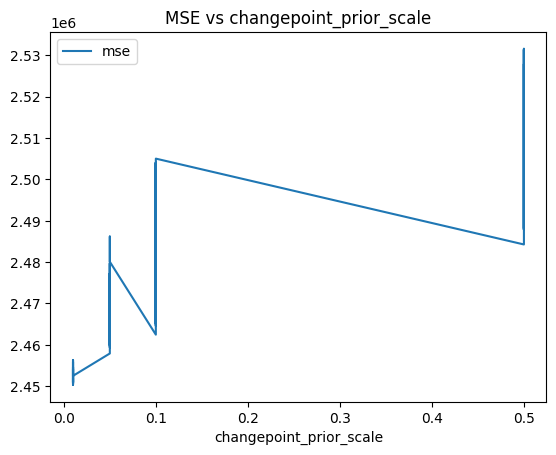

INFO:prophet:Making 33 forecasts with cutoffs between 2016-03-03 00:00:00 and 2024-01-21 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7d9db0336350>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/l9_rr575.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/k1eomp85.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/tiyl96ot.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbzbtl85n/l_ypmv2u.json
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36881', 'data', 'file=/tmp/tmpbzbtl85n/k1eomp85.json', 'init=/tmp/tmpbzbtl85n/tiyl96ot.json', 'output', 'file=/tmp/tmpbzbtl85n/prophet_modelgsddfc04/prophet_model-20240927212611.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
DEBUG:cmdstanpy:idx 0
21:26:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [

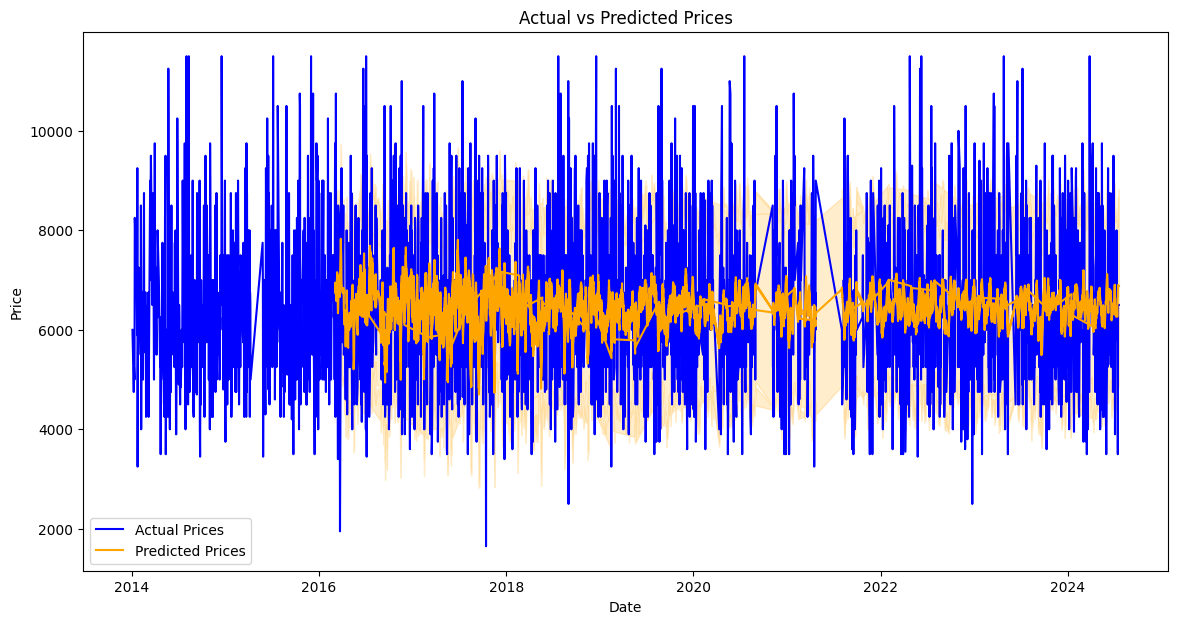

/usr/local/lib/python3.10/dist-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


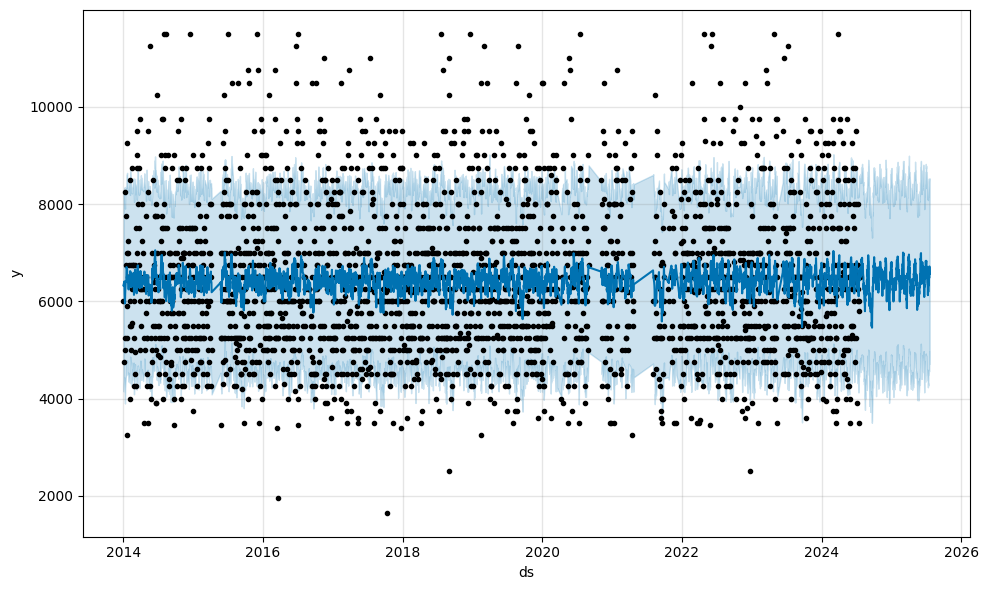

/usr/local/lib/python3.10/dist-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` o

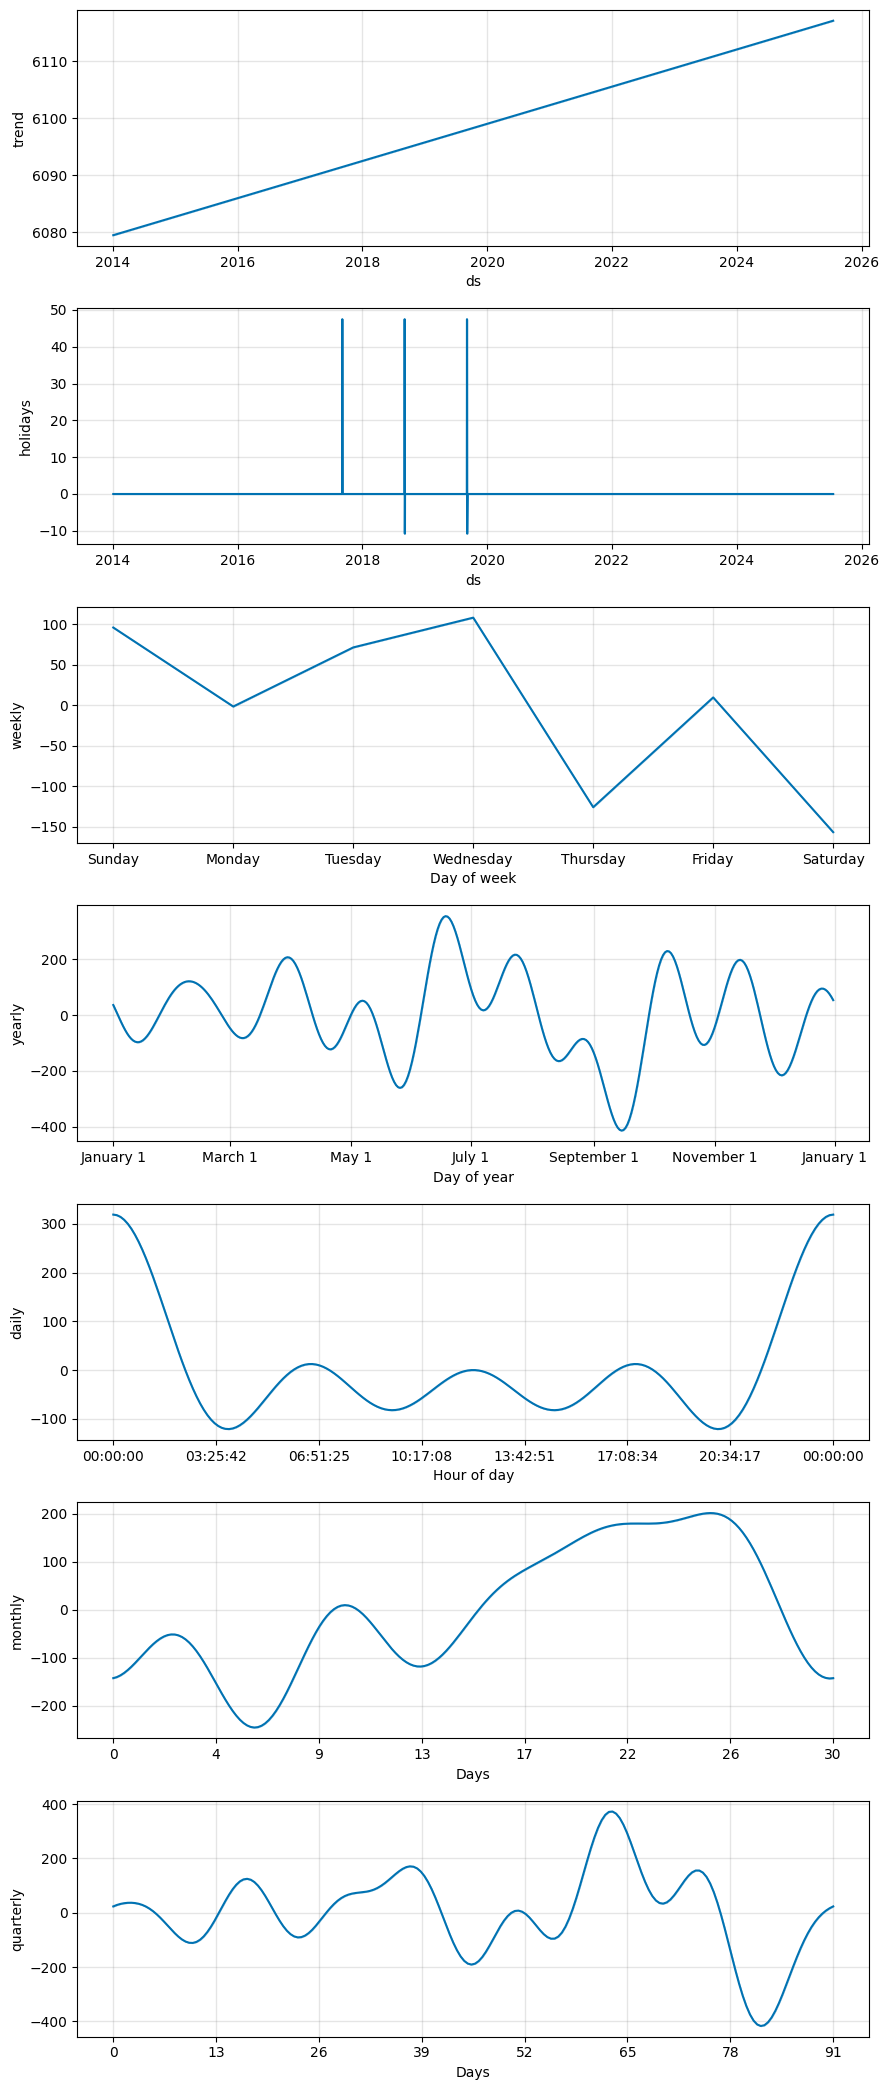

        Date  Predicted Price  Lower Bound  Upper Bound
0 2014-01-03      6327.909898  4146.594871  8260.551750
1 2014-01-08      6408.015731  4432.728720  8343.396130
2 2014-01-09      6156.822095  4170.744379  8090.741625
3 2014-01-11      5956.464746  3897.523317  7907.637890
4 2014-01-12      6170.184245  4218.988996  8288.771828


In [ ]:
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid
import pickle

# Load the data
file = '/content/apple_cleaned.csv'
data = pd.read_csv(file)

# Remove rows with NaN in the 'date' and price columns
data = data.dropna(subset=['date', 'Min Price (Rs./Quintal)', 'Max Price (Rs./Quintal)'])

# Prepare the data for Prophet
data['date'] = pd.to_datetime(data['date'])
data['average_price'] = data[['Min Price (Rs./Quintal)', 'Max Price (Rs./Quintal)']].mean(axis=1)
data_prophet = data[['date', 'average_price']].rename(columns={'date': 'ds', 'average_price': 'y'})

# Outlier Removal (adjust thresholds as per your data)
threshold_high = 15000  # Example high price threshold
threshold_low = 500     # Example low price threshold
data_prophet = data_prophet[(data_prophet['y'] < threshold_high) & (data_prophet['y'] > threshold_low)]

# Define custom seasonality (e.g., monthly seasonality)
monthly_seasonality = 30.5  # Approximate number of days in a month

# Define holidays (this is an example, adjust based on actual data)
holidays = pd.DataFrame({
    'holiday': 'apple_holiday',
    'ds': pd.to_datetime(['2017-09-05', '2018-09-05', '2019-09-05']),  # Example dates
    'lower_window': 0,
    'upper_window': 1,
})

# Initialize parameter grid for tuning with expanded parameters
param_grid = {
    'changepoint_prior_scale': [0.01, 0.05, 0.1, 0.5],
    'seasonality_prior_scale': [0.1, 1.0, 5.0, 10.0],
    'holidays_prior_scale': [0.1, 1.0, 5.0, 10.0],
}

# Create a grid search loop for hyperparameter tuning
best_model = None
best_performance = float('inf')
performance_mse_list = []

for params in ParameterGrid(param_grid):
    # Initialize and fit the Prophet model with custom seasonality, holidays, and parameters
    model = Prophet(
        daily_seasonality=True,
        yearly_seasonality=True,
        holidays=holidays,
        changepoint_prior_scale=params['changepoint_prior_scale'],
        seasonality_prior_scale=params['seasonality_prior_scale'],
        holidays_prior_scale=params['holidays_prior_scale']
    )

    # Add monthly seasonality and quarterly seasonality for testing
    model.add_seasonality(name='monthly', period=monthly_seasonality, fourier_order=5)
    model.add_seasonality(name='quarterly', period=91.25, fourier_order=8)  # Quarterly seasonality

    # Fit the model
    model.fit(data_prophet)

    # Perform cross-validation with optimized horizon and period
    df_cv = cross_validation(model, initial='730 days', period='90 days', horizon='180 days', parallel='processes')

    # Calculate performance metrics
    df_p = performance_metrics(df_cv)

    # Display the performance metrics
    print(df_p.head())  # Display the first few rows of performance metrics

    # Track best performance
    mse = df_p['mse'].mean()
    performance_mse_list.append(mse)

    if mse < best_performance:
        best_performance = mse
        best_model = model

# Display the best performance model
print(f"Best model MSE: {best_performance}")

# Plot the MSE over different hyperparameter sets
performance_data = pd.DataFrame(ParameterGrid(param_grid))
performance_data['mse'] = performance_mse_list
performance_data.plot(x='changepoint_prior_scale', y='mse', kind='line', title='MSE vs changepoint_prior_scale')
plt.show()

# Plot the actual vs predicted prices from the best model
df_cv_best = cross_validation(best_model, initial='730 days', period='90 days', horizon='180 days', parallel='processes')

plt.figure(figsize=(14, 7))
plt.plot(data_prophet['ds'], data_prophet['y'], label='Actual Prices', color='blue')
plt.plot(df_cv_best['ds'], df_cv_best['yhat'], label='Predicted Prices', color='orange')
plt.fill_between(df_cv_best['ds'], df_cv_best['yhat_lower'], df_cv_best['yhat_upper'], color='orange', alpha=0.2)
plt.title('Actual vs Predicted Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Make a future dataframe for the next 365 days using the best model
future = best_model.make_future_dataframe(periods=365)

# Predict future values
forecast = best_model.predict(future)

# Plot the forecast
best_model.plot(forecast)
plt.show()

# Plot the components (trend, weekly seasonality, yearly seasonality)
best_model.plot_components(forecast)
plt.show()

# Extract the relevant columns for predicted prices
predicted_prices = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

# Rename columns for clarity
predicted_prices.columns = ['Date', 'Predicted Price', 'Lower Bound', 'Upper Bound']

# Display the predicted prices table
print(predicted_prices.head())  # Display the first few rows of predicted prices

# Save the best model for future use
with open('best_prophet_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

# Optionally, load the model later
with open('best_prophet_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)


In [ ]:
import pickle
import pandas as pd

# Load the best model from the pkl file
with open('best_prophet_model.pkl', 'rb') as f:
    best_model = pickle.load(f)

# Create a future dataframe for the desired period (October 2024)
# We'll create future dates till the end of October 2024
future_dates = pd.date_range(start='2024-10-01', end='2024-10-31', freq='D')
future_df = pd.DataFrame(future_dates, columns=['ds'])

# Predict prices for October 2024
forecast_oct_2024 = best_model.predict(future_df)

# Extract the relevant columns (predicted price, lower, and upper bounds)
oct_2024_prices = forecast_oct_2024[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

# Rename columns for better readability
oct_2024_prices.columns = ['Date', 'Predicted Price', 'Lower Bound', 'Upper Bound']

# Display the predicted prices for October 2024
print(oct_2024_prices)


         Date  Predicted Price  Lower Bound  Upper Bound
0  2024-10-01      6822.305832  5063.773753  8669.414939
1  2024-10-02      6907.920263  5020.063118  8685.867061
2  2024-10-03      6692.058339  4783.222758  8738.236718
3  2024-10-04      6784.946245  4841.962933  8817.552056
4  2024-10-05      6515.730386  4544.311307  8389.339430
5  2024-10-06      6644.951077  4743.305850  8458.812293
6  2024-10-07      6461.995103  4516.142692  8314.073668
7  2024-10-08      6516.801387  4475.672416  8401.765972
8  2024-10-09      6581.062421  4816.427996  8465.378220
9  2024-10-10      6365.837061  4386.260410  8220.143735
10 2024-10-11      6472.167607  4422.399577  8450.627601
11 2024-10-12      6243.282503  4204.580454  8163.102625
12 2024-10-13      6454.876128  4549.169738  8261.588938
13 2024-10-14      6387.791870  4403.348513  8274.121371
14 2024-10-15      6557.319014  4613.110210  8422.746590
15 2024-10-16      6696.469565  4799.551654  8569.856507
16 2024-10-17      6498.596111 

DEBUG:cmdstanpy:input tempfile: /tmp/tmpesqz94oi/8uwz9o72.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpesqz94oi/2ut_xdkl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3359', 'data', 'file=/tmp/tmpesqz94oi/8uwz9o72.json', 'init=/tmp/tmpesqz94oi/2ut_xdkl.json', 'output', 'file=/tmp/tmpesqz94oi/prophet_modelup513xna/prophet_model-20240928140838.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:08:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:08:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 33 forecasts with cutoffs between 2016-03-03 00:00:00 and 2024-01-21 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x794eec11e860>
DEBUG:cmdstanpy:input tempfile: 

  horizon           mse         rmse         mae      mape     mdape  \
0 17 days  1.395024e+06  1181.111136  948.845524  0.168060  0.135216   
1 18 days  1.395082e+06  1181.135811  948.678910  0.170199  0.134989   
2 19 days  1.378912e+06  1174.270634  940.847531  0.168086  0.134488   
3 20 days  1.440243e+06  1200.101074  954.027452  0.174026  0.136311   
4 21 days  1.427515e+06  1194.786561  953.116059  0.173051  0.140191   

      smape  coverage  
0  0.157227  0.779549  
1  0.158145  0.787045  
2  0.156549  0.793599  
3  0.159383  0.787570  
4  0.158919  0.791149  


DEBUG:cmdstanpy:input tempfile: /tmp/tmpesqz94oi/k5qy2wi6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79139', 'data', 'file=/tmp/tmpesqz94oi/q_dq1kxm.json', 'init=/tmp/tmpesqz94oi/k5qy2wi6.json', 'output', 'file=/tmp/tmpesqz94oi/prophet_modelpafp9_io/prophet_model-20240928140852.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:08:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:08:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 33 forecasts with cutoffs between 2016-03-03 00:00:00 and 2024-01-21 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x794eb612d7b0>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpesqz94oi/m47ttwx8.json
DEBUG:cmdstanpy:input tempfile:

  horizon           mse         rmse         mae      mape     mdape  \
0 17 days  1.398282e+06  1182.489631  949.444219  0.168276  0.135358   
1 18 days  1.399091e+06  1182.831972  949.503164  0.170457  0.134873   
2 19 days  1.383308e+06  1176.140957  941.803901  0.168364  0.134219   
3 20 days  1.447475e+06  1203.110609  955.519460  0.174492  0.136227   
4 21 days  1.434389e+06  1197.659959  954.271558  0.173463  0.139391   

      smape  coverage  
0  0.157319  0.782313  
1  0.158270  0.789596  
2  0.156692  0.793599  
3  0.159599  0.787570  
4  0.159083  0.789042  


DEBUG:cmdstanpy:input tempfile: /tmp/tmpesqz94oi/jnbshzt3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27554', 'data', 'file=/tmp/tmpesqz94oi/22jxo8n4.json', 'init=/tmp/tmpesqz94oi/jnbshzt3.json', 'output', 'file=/tmp/tmpesqz94oi/prophet_modelankcv9wq/prophet_model-20240928140905.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:09:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:09:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 33 forecasts with cutoffs between 2016-03-03 00:00:00 and 2024-01-21 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x794eb5cfef80>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpesqz94oi/m9vwzpr2.json
DEBUG:cmdstanpy:input tempfile:

  horizon           mse         rmse         mae      mape     mdape  \
0 17 days  1.397132e+06  1182.003261  948.793685  0.168139  0.135158   
1 18 days  1.397439e+06  1182.133044  948.574324  0.170269  0.134476   
2 19 days  1.381140e+06  1175.219199  940.685924  0.168146  0.133686   
3 20 days  1.444092e+06  1201.703632  954.232700  0.174204  0.135884   
4 21 days  1.431173e+06  1196.316234  953.045699  0.173182  0.138841   

      smape  coverage  
0  0.157214  0.779762  
1  0.158121  0.789596  
2  0.156513  0.793483  
3  0.159398  0.785366  
4  0.158890  0.788598  


DEBUG:cmdstanpy:input tempfile: /tmp/tmpesqz94oi/e0mrkgw0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90906', 'data', 'file=/tmp/tmpesqz94oi/4qqxk_eq.json', 'init=/tmp/tmpesqz94oi/e0mrkgw0.json', 'output', 'file=/tmp/tmpesqz94oi/prophet_modelp852zkze/prophet_model-20240928140922.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:09:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:09:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 33 forecasts with cutoffs between 2016-03-03 00:00:00 and 2024-01-21 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x794eec11f820>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpesqz94oi/ksq4wrqo.json
DEBUG:cmdstanpy:input tempfile:

  horizon           mse         rmse         mae      mape     mdape  \
0 17 days  1.398267e+06  1182.483281  949.247662  0.168253  0.135607   
1 18 days  1.398157e+06  1182.436742  948.856547  0.170355  0.135046   
2 19 days  1.381798e+06  1175.498983  940.956285  0.168226  0.134380   
3 20 days  1.444593e+06  1201.912249  954.493384  0.174279  0.135871   
4 21 days  1.431666e+06  1196.522586  953.260278  0.173249  0.138903   

      smape  coverage  
0  0.157284  0.784439  
1  0.158164  0.787045  
2  0.156555  0.791048  
3  0.159439  0.787570  
4  0.158924  0.789042  


DEBUG:cmdstanpy:input tempfile: /tmp/tmpesqz94oi/9_233lif.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71778', 'data', 'file=/tmp/tmpesqz94oi/uojva0bc.json', 'init=/tmp/tmpesqz94oi/9_233lif.json', 'output', 'file=/tmp/tmpesqz94oi/prophet_modellygyfig5/prophet_model-20240928140938.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:09:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:09:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 33 forecasts with cutoffs between 2016-03-03 00:00:00 and 2024-01-21 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x794eb5e1e650>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpesqz94oi/nyjp2qx5.json
DEBUG:cmdstanpy:input tempfile:

  horizon           mse         rmse         mae      mape     mdape  \
0 17 days  1.397688e+06  1182.238612  948.737826  0.168001  0.134264   
1 18 days  1.397098e+06  1181.989013  948.038018  0.170048  0.133314   
2 19 days  1.380539e+06  1174.963347  940.085645  0.167913  0.132914   
3 20 days  1.441521e+06  1200.633453  953.274044  0.173821  0.135866   
4 21 days  1.428609e+06  1195.244394  951.902547  0.172770  0.138321   

      smape  coverage  
0  0.157193  0.784864  
1  0.158025  0.792147  
2  0.156409  0.796150  
3  0.159246  0.790121  
4  0.158705  0.791593  


DEBUG:cmdstanpy:input tempfile: /tmp/tmpesqz94oi/hx3c7pma.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77011', 'data', 'file=/tmp/tmpesqz94oi/kpn3mkc2.json', 'init=/tmp/tmpesqz94oi/hx3c7pma.json', 'output', 'file=/tmp/tmpesqz94oi/prophet_model73dihtj5/prophet_model-20240928140952.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:09:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:09:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 33 forecasts with cutoffs between 2016-03-03 00:00:00 and 2024-01-21 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x794eb612d7b0>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpesqz94oi/slgjyc2c.json
DEBUG:cmdstanpy:input tempfile:

  horizon           mse         rmse         mae      mape     mdape  \
0 17 days  1.397505e+06  1182.161007  948.743617  0.167966  0.134082   
1 18 days  1.396679e+06  1181.811583  948.004255  0.170002  0.133722   
2 19 days  1.379626e+06  1174.574751  939.997058  0.167853  0.133104   
3 20 days  1.440918e+06  1200.382270  953.115655  0.173773  0.135471   
4 21 days  1.427952e+06  1194.969394  951.729910  0.172717  0.138094   

      smape  coverage  
0  0.157195  0.779974  
1  0.158021  0.787045  
2  0.156396  0.791048  
3  0.159218  0.785019  
4  0.158674  0.791149  


DEBUG:cmdstanpy:input tempfile: /tmp/tmpesqz94oi/hhkqefdc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16592', 'data', 'file=/tmp/tmpesqz94oi/wdu5of1t.json', 'init=/tmp/tmpesqz94oi/hhkqefdc.json', 'output', 'file=/tmp/tmpesqz94oi/prophet_modeldwdwl57t/prophet_model-20240928141010.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:10:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:10:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 33 forecasts with cutoffs between 2016-03-03 00:00:00 and 2024-01-21 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x794eec11dc00>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpesqz94oi/g1fw0qh9.json
DEBUG:cmdstanpy:input tempfile:

  horizon           mse         rmse         mae      mape     mdape  \
0 17 days  1.397093e+06  1181.986742  948.305322  0.167952  0.133745   
1 18 days  1.396694e+06  1181.818223  947.732259  0.170025  0.133295   
2 19 days  1.380330e+06  1174.874551  939.942076  0.167917  0.132713   
3 20 days  1.442289e+06  1200.953212  953.199666  0.173873  0.134889   
4 21 days  1.429459e+06  1195.599952  951.952766  0.172839  0.138079   

      smape  coverage  
0  0.157123  0.779762  
1  0.157976  0.784494  
2  0.156386  0.791048  
3  0.159229  0.785019  
4  0.158707  0.788598  


DEBUG:cmdstanpy:input tempfile: /tmp/tmpesqz94oi/fgt24iwz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47490', 'data', 'file=/tmp/tmpesqz94oi/aqe1y1q_.json', 'init=/tmp/tmpesqz94oi/fgt24iwz.json', 'output', 'file=/tmp/tmpesqz94oi/prophet_models8m_4yao/prophet_model-20240928141026.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:10:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:10:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 33 forecasts with cutoffs between 2016-03-03 00:00:00 and 2024-01-21 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x794eb5cff760>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpesqz94oi/4c8isxfj.json
DEBUG:cmdstanpy:input tempfile:

  horizon           mse         rmse         mae      mape     mdape  \
0 17 days  1.398144e+06  1182.431215  948.991830  0.167987  0.133957   
1 18 days  1.397397e+06  1182.115668  948.186257  0.170016  0.133723   
2 19 days  1.380757e+06  1175.056379  940.128869  0.167861  0.132914   
3 20 days  1.441719e+06  1200.715932  953.290118  0.173771  0.135992   
4 21 days  1.428453e+06  1195.179222  951.843598  0.172702  0.138632   

      smape  coverage  
0  0.157235  0.787415  
1  0.158051  0.794698  
2  0.156418  0.798701  
3  0.159251  0.792672  
4  0.158698  0.794144  


DEBUG:cmdstanpy:input tempfile: /tmp/tmpesqz94oi/l0_ll_43.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93199', 'data', 'file=/tmp/tmpesqz94oi/xt0pacsk.json', 'init=/tmp/tmpesqz94oi/l0_ll_43.json', 'output', 'file=/tmp/tmpesqz94oi/prophet_model8vgewmvr/prophet_model-20240928141041.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:10:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:10:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 33 forecasts with cutoffs between 2016-03-03 00:00:00 and 2024-01-21 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x794f04f58b20>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpesqz94oi/wep2gbls.json
DEBUG:cmdstanpy:input tempfile:

  horizon           mse         rmse         mae      mape     mdape  \
0 17 days  1.399366e+06  1182.947862  949.094114  0.168050  0.135643   
1 18 days  1.398438e+06  1182.555782  948.263904  0.170086  0.134596   
2 19 days  1.381447e+06  1175.349707  940.065998  0.167908  0.133100   
3 20 days  1.442992e+06  1201.245875  953.390845  0.173865  0.135643   
4 21 days  1.430367e+06  1195.979557  951.973770  0.172797  0.137701   

      smape  coverage  
0  0.157241  0.782313  
1  0.158053  0.787045  
2  0.156400  0.791048  
3  0.159256  0.785019  
4  0.158708  0.788598  


DEBUG:cmdstanpy:input tempfile: /tmp/tmpesqz94oi/ay0eky0y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60938', 'data', 'file=/tmp/tmpesqz94oi/nq2wnnv6.json', 'init=/tmp/tmpesqz94oi/ay0eky0y.json', 'output', 'file=/tmp/tmpesqz94oi/prophet_modelksl6iyka/prophet_model-20240928141101.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:11:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:11:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 33 forecasts with cutoffs between 2016-03-03 00:00:00 and 2024-01-21 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x794eec11f820>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpesqz94oi/7ugo7fnl.json
DEBUG:cmdstanpy:input tempfile:

  horizon           mse         rmse         mae      mape     mdape  \
0 17 days  1.400238e+06  1183.316547  949.385480  0.168086  0.135989   
1 18 days  1.399165e+06  1182.862938  948.571572  0.170123  0.134659   
2 19 days  1.382073e+06  1175.616034  940.367418  0.167941  0.133113   
3 20 days  1.443455e+06  1201.438724  953.681913  0.173894  0.135989   
4 21 days  1.430851e+06  1196.181751  952.240223  0.172822  0.137220   

      smape  coverage  
0  0.157289  0.787202  
1  0.158104  0.792147  
2  0.156449  0.796150  
3  0.159305  0.790121  
4  0.158752  0.791593  


DEBUG:cmdstanpy:input tempfile: /tmp/tmpesqz94oi/6u8d5l4g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14142', 'data', 'file=/tmp/tmpesqz94oi/nrnstr_o.json', 'init=/tmp/tmpesqz94oi/6u8d5l4g.json', 'output', 'file=/tmp/tmpesqz94oi/prophet_modelm4mybwg6/prophet_model-20240928141119.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:11:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:11:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 33 forecasts with cutoffs between 2016-03-03 00:00:00 and 2024-01-21 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x794eb635ca90>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpesqz94oi/9efzjdw5.json
DEBUG:cmdstanpy:input tempfile:

  horizon           mse         rmse         mae      mape     mdape  \
0 17 days  1.399848e+06  1183.151605  949.381587  0.168081  0.135616   
1 18 days  1.398855e+06  1182.731853  948.605775  0.170123  0.134435   
2 19 days  1.381746e+06  1175.476769  940.404473  0.167943  0.132974   
3 20 days  1.443125e+06  1201.301582  953.694692  0.173890  0.135616   
4 21 days  1.430484e+06  1196.028303  952.242341  0.172816  0.137390   

      smape  coverage  
0  0.157288  0.784651  
1  0.158109  0.789596  
2  0.156455  0.796150  
3  0.159306  0.790121  
4  0.158752  0.791593  


DEBUG:cmdstanpy:input tempfile: /tmp/tmpesqz94oi/ht1vaqth.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44390', 'data', 'file=/tmp/tmpesqz94oi/kltaqvmf.json', 'init=/tmp/tmpesqz94oi/ht1vaqth.json', 'output', 'file=/tmp/tmpesqz94oi/prophet_modelridt0lo3/prophet_model-20240928141136.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:11:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:11:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 33 forecasts with cutoffs between 2016-03-03 00:00:00 and 2024-01-21 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x794eb5d32e30>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpesqz94oi/0eifnh7l.json
DEBUG:cmdstanpy:input tempfile:

  horizon           mse         rmse         mae      mape     mdape  \
0 17 days  1.400204e+06  1183.302065  949.376702  0.168084  0.135770   
1 18 days  1.399382e+06  1182.954859  948.678486  0.170144  0.134492   
2 19 days  1.382588e+06  1175.835080  940.577746  0.167980  0.133079   
3 20 days  1.444425e+06  1201.842474  953.957997  0.173956  0.135770   
4 21 days  1.431911e+06  1196.624982  952.540890  0.172888  0.137172   

      smape  coverage  
0  0.157287  0.782313  
1  0.158121  0.789596  
2  0.156482  0.793599  
3  0.159346  0.787570  
4  0.158798  0.791593  


DEBUG:cmdstanpy:input tempfile: /tmp/tmpesqz94oi/007l6mk_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43308', 'data', 'file=/tmp/tmpesqz94oi/3_ir6ync.json', 'init=/tmp/tmpesqz94oi/007l6mk_.json', 'output', 'file=/tmp/tmpesqz94oi/prophet_modelr0umzh03/prophet_model-20240928141151.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:11:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:11:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 33 forecasts with cutoffs between 2016-03-03 00:00:00 and 2024-01-21 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x794eb612d7b0>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpesqz94oi/ylv8_ni4.json
DEBUG:cmdstanpy:input tempfile:

  horizon           mse         rmse         mae      mape     mdape  \
0 17 days  1.413255e+06  1188.804028  952.864034  0.168800  0.132894   
1 18 days  1.411269e+06  1187.968450  952.330129  0.170910  0.131873   
2 19 days  1.395362e+06  1181.254507  945.015257  0.168841  0.130506   
3 20 days  1.459699e+06  1208.179929  958.933029  0.174997  0.131873   
4 21 days  1.448352e+06  1203.474800  957.396062  0.173891  0.133713   

      smape  coverage  
0  0.157820  0.787415  
1  0.158689  0.792147  
2  0.157183  0.791048  
3  0.160122  0.785019  
4  0.159551  0.791149  


DEBUG:cmdstanpy:input tempfile: /tmp/tmpesqz94oi/6gjks56q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91686', 'data', 'file=/tmp/tmpesqz94oi/1cjzz2au.json', 'init=/tmp/tmpesqz94oi/6gjks56q.json', 'output', 'file=/tmp/tmpesqz94oi/prophet_modeldm6y4ne2/prophet_model-20240928141210.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:12:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:12:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 33 forecasts with cutoffs between 2016-03-03 00:00:00 and 2024-01-21 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x794eb5d30e50>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpesqz94oi/xro7vwcx.json
DEBUG:cmdstanpy:input tempfile:

  horizon           mse         rmse         mae      mape     mdape  \
0 17 days  1.413369e+06  1188.852038  952.885190  0.168820  0.133578   
1 18 days  1.411428e+06  1188.035219  952.381833  0.170934  0.131566   
2 19 days  1.395433e+06  1181.284299  945.030441  0.168857  0.130639   
3 20 days  1.459726e+06  1208.191296  958.981177  0.175017  0.131566   
4 21 days  1.448327e+06  1203.464403  957.396678  0.173904  0.134479   

      smape  coverage  
0  0.157824  0.777211  
1  0.158696  0.781943  
2  0.157184  0.785946  
3  0.160129  0.779917  
4  0.159550  0.783496  


DEBUG:cmdstanpy:input tempfile: /tmp/tmpesqz94oi/uuxvdcp6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97972', 'data', 'file=/tmp/tmpesqz94oi/bhlirjzy.json', 'init=/tmp/tmpesqz94oi/uuxvdcp6.json', 'output', 'file=/tmp/tmpesqz94oi/prophet_modelf9hini3g/prophet_model-20240928141228.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:12:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:12:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 33 forecasts with cutoffs between 2016-03-03 00:00:00 and 2024-01-21 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x794eec11f820>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpesqz94oi/8z5b1cmy.json
DEBUG:cmdstanpy:input tempfile:

  horizon           mse         rmse         mae      mape     mdape  \
0 17 days  1.413182e+06  1188.773393  952.742800  0.168791  0.133695   
1 18 days  1.411182e+06  1187.931783  952.204145  0.170898  0.131234   
2 19 days  1.395415e+06  1181.276966  944.928531  0.168835  0.130177   
3 20 days  1.459510e+06  1208.101629  958.848725  0.174983  0.131234   
4 21 days  1.448108e+06  1203.373581  957.304145  0.173876  0.134540   

      smape  coverage  
0  0.157801  0.787628  
1  0.158668  0.794698  
2  0.157168  0.796150  
3  0.160110  0.790121  
4  0.159537  0.796251  


DEBUG:cmdstanpy:input tempfile: /tmp/tmpesqz94oi/kbly9xvn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29853', 'data', 'file=/tmp/tmpesqz94oi/ffat0u5g.json', 'init=/tmp/tmpesqz94oi/kbly9xvn.json', 'output', 'file=/tmp/tmpesqz94oi/prophet_modelz_k6o5w9/prophet_model-20240928141245.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:12:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:12:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 33 forecasts with cutoffs between 2016-03-03 00:00:00 and 2024-01-21 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x794eb5d32c80>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpesqz94oi/a_kf4lhd.json
DEBUG:cmdstanpy:input tempfile:

  horizon           mse         rmse         mae      mape     mdape  \
0 17 days  1.413474e+06  1188.896086  952.809387  0.168815  0.133658   
1 18 days  1.411554e+06  1188.088438  952.340224  0.170937  0.131339   
2 19 days  1.395832e+06  1181.453425  945.031895  0.168870  0.130385   
3 20 days  1.460252e+06  1208.408879  959.025236  0.175037  0.131339   
4 21 days  1.448878e+06  1203.693412  957.469303  0.173929  0.134523   

      smape  coverage  
0  0.157812  0.787415  
1  0.158690  0.792147  
2  0.157185  0.791048  
3  0.160137  0.785019  
4  0.159562  0.791149  
Best model MSE: 1556218.9771844298


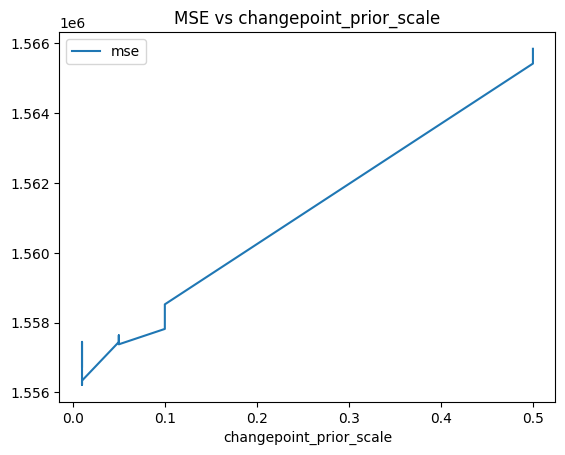

INFO:prophet:Making 33 forecasts with cutoffs between 2016-03-03 00:00:00 and 2024-01-21 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x794eb5d32410>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpesqz94oi/cct07tr_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpesqz94oi/r71r9oks.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpesqz94oi/a1dbsnjn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29276', 'data', 'file=/tmp/tmpesqz94oi/cct07tr_.json', 'init=/tmp/tmpesqz94oi/a1dbsnjn.json', 'output', 'file=/tmp/tmpesqz94oi/prophet_model92_8h54l/prophet_model-20240928141303.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
DEBUG:cmdstanpy:input tempfile: /tmp/tmpesqz94oi/w_y0lb__.json
14:13:03 - cmdstanpy - INFO - Chain [1] start processing
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:runnin

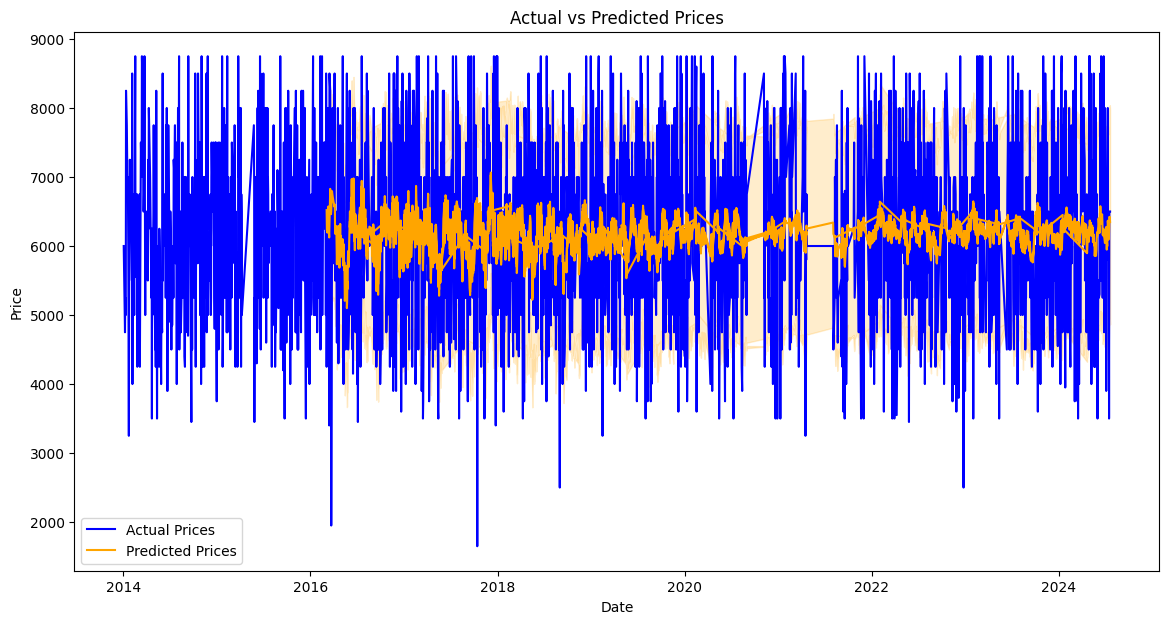

/usr/local/lib/python3.10/dist-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


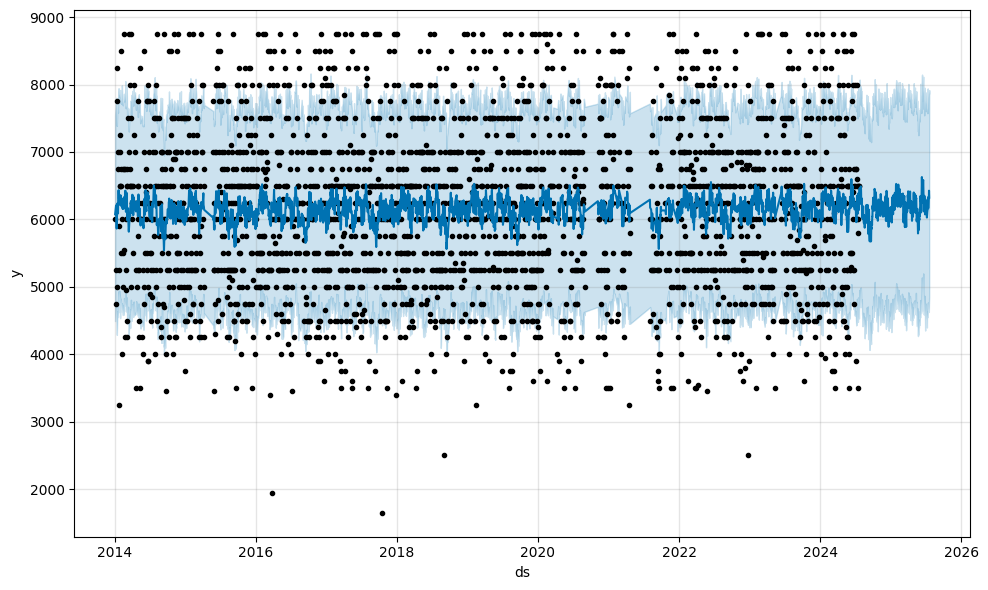

/usr/local/lib/python3.10/dist-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` o

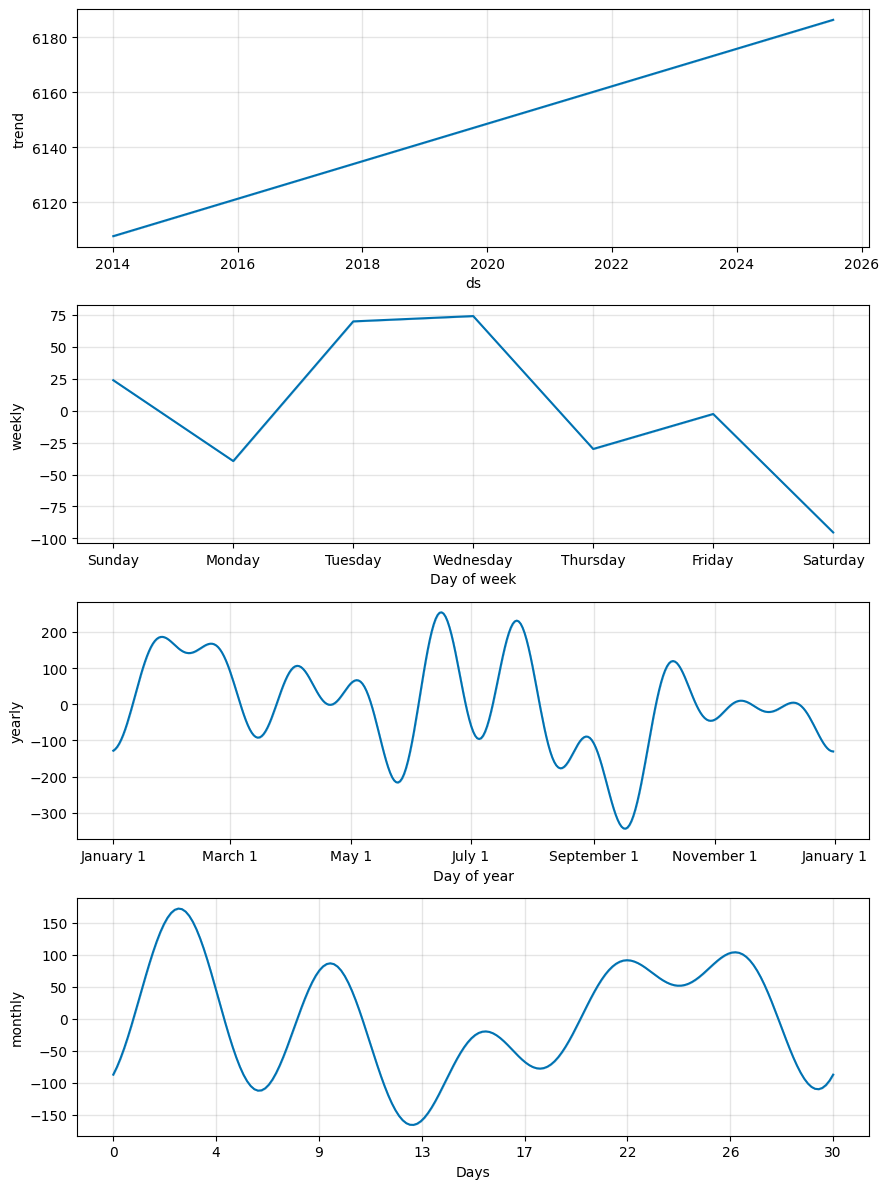

        Date  Predicted Price  Lower Bound  Upper Bound
0 2014-01-03      6075.400340  4492.205370  7540.365766
1 2014-01-08      6208.646829  4739.283691  7801.295217
2 2014-01-09      6090.659941  4560.131467  7608.968121
3 2014-01-11      5864.939076  4377.821708  7396.473328
4 2014-01-12      5988.707967  4288.102603  7387.953587


In [4]:
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid
import pickle

# Load the data
file = '/content/apple_cleaned.csv'
data = pd.read_csv(file)

# Remove rows with NaN in the 'date' and price columns
data = data.dropna(subset=['date', 'Min Price (Rs./Quintal)', 'Max Price (Rs./Quintal)'])

# Prepare the data for Prophet
data['date'] = pd.to_datetime(data['date'])
data['average_price'] = data[['Min Price (Rs./Quintal)', 'Max Price (Rs./Quintal)']].mean(axis=1)
data_prophet = data[['date', 'average_price']].rename(columns={'date': 'ds', 'average_price': 'y'})

# Outlier Removal (adjust thresholds as per your data)
threshold_high = 9000  # Example high price threshold
threshold_low = 1000     # Example low price threshold
data_prophet = data_prophet[(data_prophet['y'] < threshold_high) & (data_prophet['y'] > threshold_low)]

# Define custom seasonality (e.g., monthly seasonality)
monthly_seasonality = 30.5  # Approximate number of days in a month

# Define holidays (this is an example, adjust based on actual data)
'''holidays = pd.DataFrame({
    'holiday': 'apple_holiday',
    'ds': pd.to_datetime(['2017-09-05', '2018-09-05', '2019-09-05']),  # Example dates
    'lower_window': 0,
    'upper_window': 1,
})
'''
# Initialize parameter grid for tuning with expanded parameters
param_grid = {
    'changepoint_prior_scale': [0.01, 0.05, 0.1, 0.5],
    'seasonality_prior_scale': [0.1, 1.0, 5.0, 10.0],
    #'fourier_order': [5, 10, 15, 20],
    #'holidays_prior_scale': [0.1, 1.0, 5.0, 10.0],
}

# Create a grid search loop for hyperparameter tuning
best_model = None
best_performance = float('inf')
performance_mse_list = []

for params in ParameterGrid(param_grid):
    # Initialize and fit the Prophet model with custom seasonality, holidays, and parameters
    model = Prophet(
        daily_seasonality=False,
        yearly_seasonality=True,
        #holidays=holidays,
        changepoint_prior_scale=params['changepoint_prior_scale'],
        seasonality_prior_scale=params['seasonality_prior_scale'],
        #fourier_order=params['fourier_order'],
        #holidays_prior_scale=params['holidays_prior_scale']
    )

    # Add monthly seasonality and quarterly seasonality for testing
    model.add_seasonality(name='monthly', period=monthly_seasonality, fourier_order=5)
    model.add_seasonality(name='yearly', period=365.5, fourier_order=15)
    #model.add_seasonality(name='quarterly', period=91.25, fourier_order=8)  # Quarterly seasonality

    # Fit the model
    model.fit(data_prophet)

    # Perform cross-validation with optimized horizon and period
    df_cv = cross_validation(model, initial='730 days', period='90 days', horizon='180 days', parallel='processes')

    # Calculate performance metrics
    df_p = performance_metrics(df_cv)

    # Display the performance metrics
    print(df_p.head())  # Display the first few rows of performance metrics

    # Track best performance
    mse = df_p['mse'].mean()
    performance_mse_list.append(mse)

    if mse < best_performance:
        best_performance = mse
        best_model = model
        best_parameter = params

# Display the best performance model
print(f"Best model MSE: {best_performance}")


# Plot the MSE over different hyperparameter sets
performance_data = pd.DataFrame(ParameterGrid(param_grid))
performance_data['mse'] = performance_mse_list
performance_data.plot(x='changepoint_prior_scale', y='mse', kind='line', title='MSE vs changepoint_prior_scale')
plt.show()
performance_data.to_csv('performance_metrics.csv', index=False)

# Plot the actual vs predicted prices from the best model
df_cv_best = cross_validation(best_model, initial='730 days', period='90 days', horizon='180 days', parallel='processes')

plt.figure(figsize=(14, 7))
plt.plot(data_prophet['ds'], data_prophet['y'], label='Actual Prices', color='blue')
plt.plot(df_cv_best['ds'], df_cv_best['yhat'], label='Predicted Prices', color='orange')
plt.fill_between(df_cv_best['ds'], df_cv_best['yhat_lower'], df_cv_best['yhat_upper'], color='orange', alpha=0.2)
plt.title('Actual vs Predicted Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Make a future dataframe for the next 365 days using the best model
future = best_model.make_future_dataframe(periods=365)

# Predict future values
forecast = best_model.predict(future)

# Plot the forecast
best_model.plot(forecast)
plt.show()

# Plot the components (trend, weekly seasonality, yearly seasonality)
best_model.plot_components(forecast)
plt.show()

# Extract the relevant columns for predicted prices
predicted_prices = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

# Rename columns for clarity
predicted_prices.columns = ['Date', 'Predicted Price', 'Lower Bound', 'Upper Bound']

# Display the predicted prices table
print(predicted_prices.head())  # Display the first few rows of predicted prices

# Save the best model for future use
with open('best_prophet_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

# Optionally, load the model later
with open('best_prophet_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)


In [5]:
data.tail(5)

Grade  Min Price (Rs./Quintal)  Max Price (Rs./Quintal)  \
2762  Large                     5000                     7000   
2763  Large                     2500                     4500   
2764  Large                     4000                     9000   
2765  Large                     5500                     7500   
2766  Large                     4500                     8500   

      Modal Price (Rs./Quintal)       date  average_price  
2762                       6500 2024-07-14         6000.0  
2763                       4000 2024-07-15         3500.0  
2764                       7000 2024-07-16         6500.0  
2765                       6550 2024-07-18         6500.0  
2766                       6500 2024-07-19         6500.0

           Date  Predicted Price  Lower Bound  Upper Bound
2607 2024-09-20      5696.883382  4280.521428  7279.206417


/usr/local/lib/python3.10/dist-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


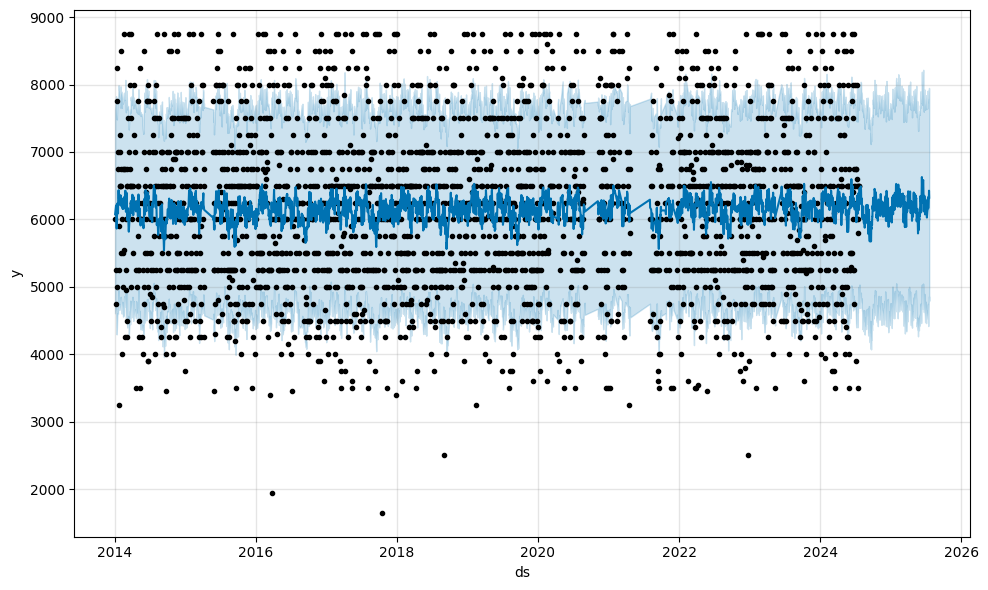

/usr/local/lib/python3.10/dist-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` o

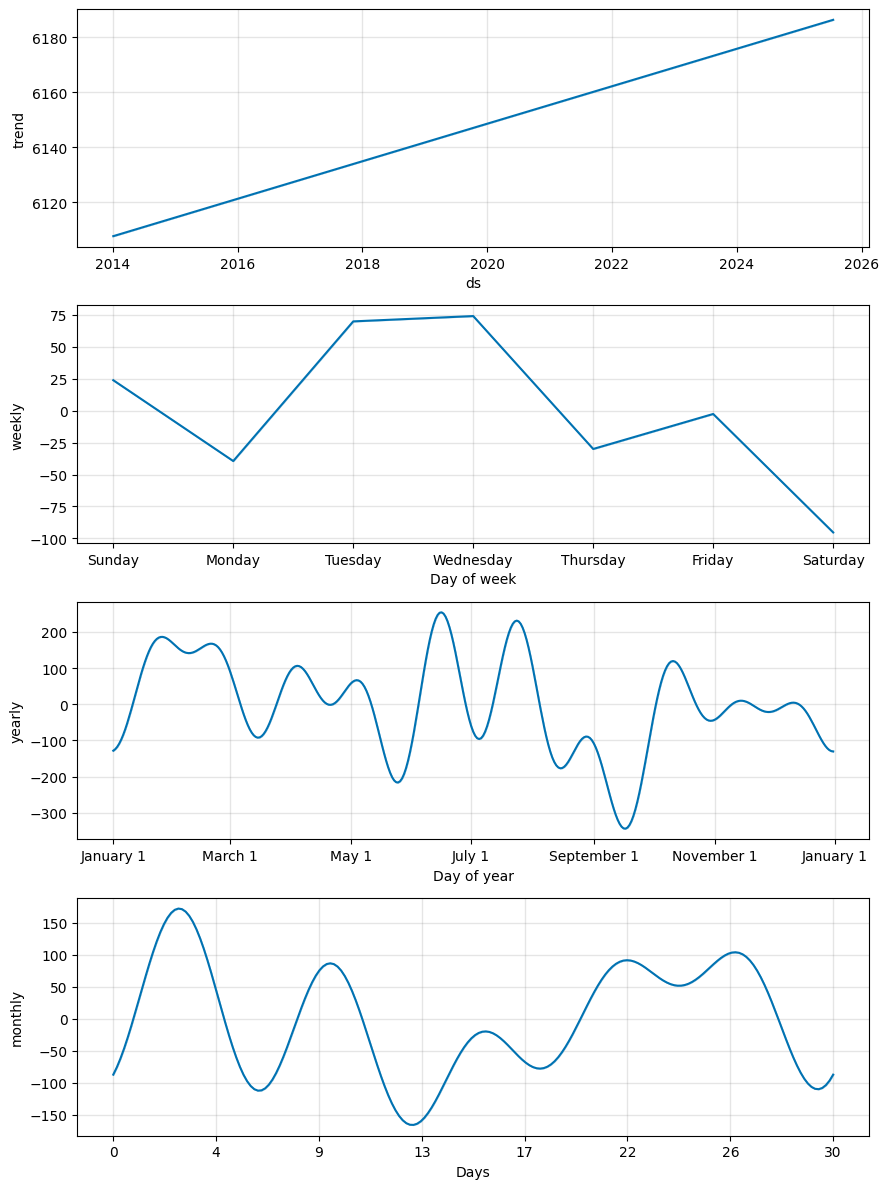

In [9]:
# Make a future dataframe for the next 365 days using the best model
future = best_model.make_future_dataframe(periods=365)

# Predict future values
forecast = best_model.predict(future)

# Extract the relevant columns for predicted prices
predicted_prices = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

# Rename columns for clarity
predicted_prices.columns = ['Date', 'Predicted Price', 'Lower Bound', 'Upper Bound']

# Display the prediction for 28-09-2024
predicted_price_on_date = predicted_prices[predicted_prices['Date'] == '2024-09-20']
print(predicted_price_on_date)

# Plot the forecast (optional)
best_model.plot(forecast)
plt.show()

# Plot the components (trend, weekly seasonality, yearly seasonality)
best_model.plot_components(forecast)
plt.show()


In [11]:
# Make a future dataframe for the next 365 days using the best model
future = best_model.make_future_dataframe(periods=365)

# Predict future values
forecast = best_model.predict(future)

# Extract the relevant columns for predicted prices
predicted_prices = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

# Rename columns for clarity
predicted_prices.columns = ['Date', 'Predicted Price', 'Lower Bound', 'Upper Bound']

# Filter for the month of September 2024
predicted_september = predicted_prices[(predicted_prices['Date'] >= '2024-09-01') &
                                       (predicted_prices['Date'] <= '2024-09-30')]

# Display the predicted prices for September 2024
print(predicted_september)




           Date  Predicted Price  Lower Bound  Upper Bound
2588 2024-09-01      6149.816219  4657.315969  7687.005990
2589 2024-09-02      6104.711359  4531.556230  7626.301887
2590 2024-09-03      6214.826841  4698.741118  7761.752164
2591 2024-09-04      6158.793175  4577.573312  7644.377289
2592 2024-09-05      5944.373362  4446.865105  7515.329229
2593 2024-09-06      5879.974736  4341.137662  7394.350178
2594 2024-09-07      5783.412315  4273.210078  7405.176612
2595 2024-09-08      5987.727578  4361.838567  7464.762848
2596 2024-09-09      6021.340166  4369.639459  7533.174899
2597 2024-09-10      6144.636870  4595.591589  7640.864070
2598 2024-09-11      6051.550652  4581.709322  7607.907520
2599 2024-09-12      5803.978918  4238.344171  7220.191603
2600 2024-09-13      5744.750335  4047.693592  7253.691676
2601 2024-09-14      5674.969253  4039.408399  7179.648472
2602 2024-09-15      5884.073321  4266.664509  7265.613969
2603 2024-09-16      5881.832659  4379.636840  7581.2935